In [1]:
import copy
import pickle
import random
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from Bio import Align

from dataset import *
from utils import *
from models import *

# 1. cov-abdab

## 1.1 EDA

In [2]:
# data = pickle.load(open("../../MSAI_Project/codes/data_files/data.json", "rb"))
# data = pickle.load(open("../../MSAI_Project/codes/data_files/data_list.pkl", "rb"))
data = pickle.load(open("./data/data_list.pkl", "rb"))
type(data), len(data)

(list, 5386)

In [3]:
# must: delete samples with CDR containing "..."
data1 = []
for i in range(len(data)):
    if ("." in data[i]["H1"]) or ("." in data[i]["H2"]) or ("." in data[i]["H3"]) or ("." in data[i]["L1"]) or ("." in data[i]["L2"]) or ("." in data[i]["L3"]):
        pass
    else:
        data1.append(data[i])
        
del data
data = data1
del data1
type(data), len(data)

(list, 5380)

In [4]:
# check . existence
for i in range(len(data)):
    if ("." in data[i]["H1"]) or ("." in data[i]["H2"]) or ("." in data[i]["H3"]) or ("." in data[i]["L1"]) or ("." in data[i]["L2"]) or ("." in data[i]["L3"]):
        print("/".join([data[i]["H1"], data[i]["H2"], data[i]["H3"], data[i]["L1"], data[i]["L2"], data[i]["L3"]]))
        print(i)

# paratope max len
maxlen = 0
for i in range(len(data)):
    cur = len(data[i]["H1"]+data[i]["H2"]+data[i]["H3"]+data[i]["L1"]+data[i]["L2"]+data[i]["L3"])
    maxlen = cur if cur > maxlen else maxlen
print("max len of paratope:", maxlen)


# check integrity of six CDRs
for i in range(len(data)):
    s = "/".join([data[i]["H1"], data[i]["H2"], data[i]["H3"], data[i]["L1"], data[i]["L2"], data[i]["L3"]])
    if len(s.split("/"))!=6:
        print(s)

max len of paratope: 69


In [5]:
data[0].keys()

dict_keys(['pdb', 'Hchain', 'Lchain', 'Achain', 'Hseq', 'Lseq', 'Aseq', 'L1', 'L2', 'L3', 'H1', 'H2', 'H3'])

In [6]:
len(data[0]["Hseq"]["J"])

123

In [7]:
data[0]

{'pdb': '7t17',
 'Hchain': 'J',
 'Lchain': 'K',
 'Achain': ['C'],
 'Hseq': {'J': [{'name': 'GLN',
    'abbr': 'Q',
    'pos': array([[ 57.69 , -27.721, 213.695],
           [ 56.713, -27.938, 214.755],
           [ 56.848, -26.882, 215.848],
           [ 57.955, -26.464, 216.188]], dtype=float32)},
   {'name': 'VAL',
    'abbr': 'V',
    'pos': array([[ 55.708, -26.454, 216.394],
           [ 55.725, -25.461, 217.46 ],
           [ 56.083, -26.137, 218.776],
           [ 55.473, -27.138, 219.173]], dtype=float32)},
   {'name': 'GLN',
    'abbr': 'Q',
    'pos': array([[ 57.085, -25.589, 219.46 ],
           [ 57.561, -26.15 , 220.715],
           [ 57.666, -25.045, 221.754],
           [ 58.003, -23.902, 221.438]], dtype=float32)},
   {'name': 'LEU',
    'abbr': 'L',
    'pos': array([[ 57.37 , -25.4  , 223.002],
           [ 57.438, -24.472, 224.121],
           [ 58.445, -24.994, 225.135],
           [ 58.476, -26.192, 225.431]], dtype=float32)},
   {'name': 'GLN',
    'abbr': 'Q',
 

(array([  3.,   0.,   0.,   0.,   0.,   0.,  18.,   0.,   0.,  77.,   0.,
          0.,  27.,   0.,   0., 131.,   0.,   0., 149.,   0.,   0., 158.,
          0.,   0.,   0., 363.,   0.,   0., 452.,   0.,   0., 474.,   0.,
          0., 340.,   0.,   0., 388.,   0.,   0., 359.,   0.,   0., 356.,
          0.,   0., 336.,   0.,   0.,   0., 457.,   0.,   0., 265.,   0.,
          0., 277.,   0.,   0.,  92.,   0.,   0., 180.,   0.,   0.,  96.,
          0.,   0., 118.,   0.,   0.,  35.,   0.,   0.,   0.,  52.,   0.,
          0., 109.,   0.,   0.,  20.,   0.,   0.,  16.,   0.,   0.,  17.,
          0.,   0.,   2.,   0.,   0.,   5.,   0.,   0.,   6.,   0.,   0.,
          2.]),
 array([37.  , 37.32, 37.64, 37.96, 38.28, 38.6 , 38.92, 39.24, 39.56,
        39.88, 40.2 , 40.52, 40.84, 41.16, 41.48, 41.8 , 42.12, 42.44,
        42.76, 43.08, 43.4 , 43.72, 44.04, 44.36, 44.68, 45.  , 45.32,
        45.64, 45.96, 46.28, 46.6 , 46.92, 47.24, 47.56, 47.88, 48.2 ,
        48.52, 48.84, 49.16, 49.48

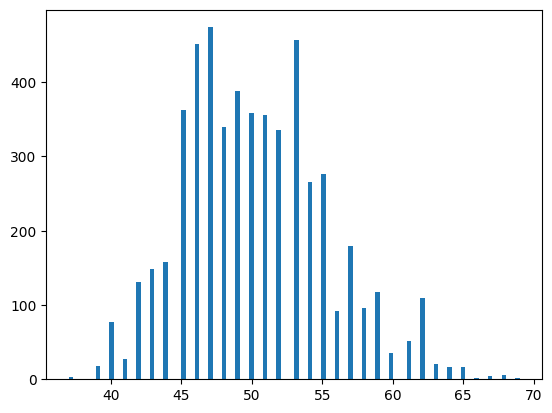

In [8]:
para_len = []
for i in range(len(data)):
    tmp = len(data[i]["L1"])+len(data[i]["L2"])+len(data[i]["L3"])+len(data[i]["H1"])+len(data[i]["H2"])+len(data[i]["H3"])
    para_len.append(tmp)
plt.hist(para_len, bins=100)

In [9]:
data[0]["Aseq"]["C"]

[{'name': 'ILE',
  'abbr': 'I',
  'pos': array([[ 81.858,  -7.199, 197.021],
         [ 81.735,  -6.449, 198.265],
         [ 80.284,  -6.421, 198.728],
         [ 79.74 ,  -5.362, 199.036]], dtype=float32)},
 {'name': 'ARG',
  'abbr': 'R',
  'pos': array([[ 79.66 ,  -7.596, 198.767],
         [ 78.278,  -7.837, 199.157],
         [ 77.269,  -7.526, 198.055],
         [ 76.075,  -7.745, 198.261]], dtype=float32)},
 {'name': 'CYS',
  'abbr': 'C',
  'pos': array([[ 77.695,  -7.022, 196.897],
         [ 76.793,  -6.774, 195.785],
         [ 77.323,  -7.296, 194.458],
         [ 76.538,  -7.469, 193.52 ]], dtype=float32)},
 {'name': 'ILE',
  'abbr': 'I',
  'pos': array([[ 78.63 ,  -7.552, 194.352],
         [ 79.196,  -8.074, 193.112],
         [ 78.916,  -9.554, 192.915],
         [ 78.921, -10.028, 191.772]], dtype=float32)},
 {'name': 'GLY',
  'abbr': 'G',
  'pos': array([[ 78.667, -10.296, 193.99 ],
         [ 78.411, -11.718, 193.885],
         [ 76.953, -12.063, 193.664],
         [ 

In [10]:
tmp = [data[0]["Aseq"][k] for k in data[0]["Aseq"]]
tmp = np.hstack(tmp)
# tmp = "/".join(tmp)
len(tmp)

392

(array([766., 232.,  43.,  92., 118., 241., 254., 229., 173., 133., 121.,
        171., 136., 121., 102., 136., 105., 152., 170., 104., 136.,  94.,
         73., 211., 128.,  95., 150.,  94.,  39., 148., 122.,  47.,  38.,
         41.,  25.,  18.,  20.,  17.,   7.,  10.,  23.,  15.,  19.,   6.,
          9.,   7.,  12.,   2.,   7.,   3.,  17.,  17.,   4.,  11.,  20.,
         12.,  11.,   4.,   2.,   9.,   5.,   7.,   5.,   7.,   6.,   0.,
          2.,   0.,   5.,   1.,   0.,   2.,   1.,   4.,   2.,   0.,   1.,
          0.,   1.,   0.,   0.,   1.,   0.,   2.,   0.,   1.,   1.,   0.,
          0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          1.]),
 array([   2.  ,   20.51,   39.02,   57.53,   76.04,   94.55,  113.06,
         131.57,  150.08,  168.59,  187.1 ,  205.61,  224.12,  242.63,
         261.14,  279.65,  298.16,  316.67,  335.18,  353.69,  372.2 ,
         390.71,  409.22,  427.73,  446.24,  464.75,  483.26,  501.77,
         520.28,  538.79,  557.3 ,

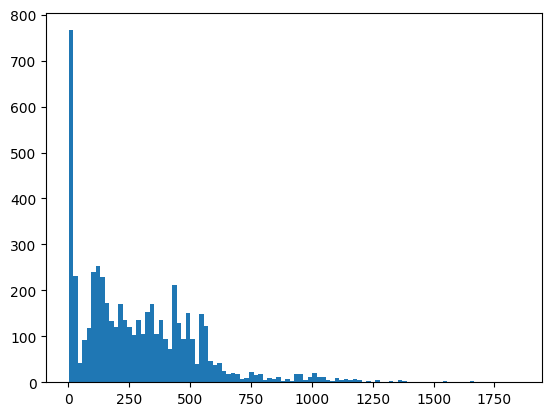

In [11]:
epi_len = []
for i in range(len(data)):
    tmp = [data[i]["Aseq"][k] for k in data[i]["Aseq"]]
    tmp = np.hstack(tmp)
    epi_len.append(len(tmp))
plt.hist(epi_len, bins=100)

(array([2.281e+03, 1.318e+03, 1.168e+03, 3.450e+02, 1.030e+02, 1.070e+02,
        3.800e+01, 1.100e+01, 7.000e+00, 2.000e+00]),
 array([   2. ,  187.1,  372.2,  557.3,  742.4,  927.5, 1112.6, 1297.7,
        1482.8, 1667.9, 1853. ]),
 <BarContainer object of 10 artists>)

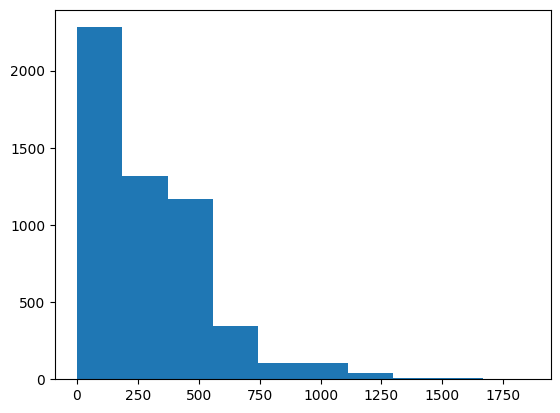

In [12]:
plt.hist(epi_len)

In [13]:
threshold = 400
print(len(epi_len))
sum([1 if epi_len[i]>threshold else 0 for i in range(len(epi_len))])

5380


1579

In [14]:
L1_len = []
L2_len = []
L3_len = []
H1_len = []
H2_len = []
H3_len = []
A_len = []

for i in range(len(data)):
    L1_len.append(len(data[i]["L1"]))
    L2_len.append(len(data[i]["L2"]))
    L3_len.append(len(data[i]["L3"]))
    H1_len.append(len(data[i]["H1"]))
    H2_len.append(len(data[i]["H2"]))
    H3_len.append(len(data[i]["H3"]))
    A_len.append(len("".join(data[i]["Aseq"])))
    # 3 antigen chains
    if len("".join(data[i]["Aseq"]))>=3:
        print(i)

49
96
117
128
179
241
407
438
488
517
527
532
554
609
615
672
813
1113
1176
1208
1216
1281
1322
1348
1381
1389
1397
1513
1590
1688
1694
1698
1702
1766
1781
1782
1796
2024
2088
2124
2131
2235
2247
2272
2386
2504
2627
2662
2693
2742
2808
2814
2898
2901
3062
3317
3331
3397
3486
3548
3598
3626
3667
3799
3920
3929
3988
4124
4222
4330
4334
4550
4626
4635
4643
4652
4666
4805
4895
4971
5035
5052
5077
5107
5113
5253
5278
5363


# debug

In [15]:
d = pickle.load(open("./data/processed_data_clip1_neg0.pkl", "rb"))
len(d)

7856

In [16]:
for i in range(len(d)):
    if "." in d[i][0] or "." in d[i][1]:
        print(i, d[i])

In [17]:
# need to remove redundant instances
# done below:
# 

## 1.2 dataset

## 1.3 Model

## 1.4 Training

In [18]:
# def my_pad_sequence(seqs):
#     max_len = max(list(map(lambda x:len(x), seqs)))
    
#     seqs = list(map(lambda x:"+"+x.strip("#")+"#"*(max_len-len(x.strip("#")))+"-", seqs))
    
#     return seqs

# def collate_fn(batch, mode=0):
    
#     # +ABCD-###
#     if mode==0:

#         paras = [b[0] for b in batch]
#         epis = [b[1] for b in batch]
#         labels = torch.hstack([b[2] for b in batch])
#         max_len = max(max(list(map(lambda x:len(x), paras))), max(list(map(lambda x:len(x), epis))))

#         paras = ["+"+i.strip("#")+"-"+"#"*(max_len-len(i.strip("#"))) for i in paras]
#         epis = ["+"+i.strip("#")+"-"+"#"*(max_len-len(i.strip("#"))) for i in epis]

#         new_batch = [paras, epis, labels]

#         return new_batch
    
#     # padding for six CDRs
#     if mode==1:
#         paras = [b[0] for b in batch]
#         paras = [(p.split("/"), max(list(map(lambda x:len(x), p.split("/"))))) for p in paras]
#         paras = list(map(my_pad_sequence, paras))
#         epis = [b[1] for b in batch]
#         labels = [b[2] for b in batch]
#         new_batch = [paras, epis, labels]

#         return new_batch

In [19]:
# config = {
#     'kfold': 10,          # 0 - full; 5 - 5fold; 10 - 10fold
#     'seq_clip_mode': 1,   # how to choose epitope: 0 - random AA sequence as epitope; 1 - k-nearest AA as epitope
#     'neg_sample_mode': 0, # how to generate negative sample: 0 - random sample with dissimilarity rate 90% 1 - random sequence;
    
#     'model_name': 'lstm'
#     'embed_size': 32, 
#     'hidden': 64, 
    
#     'batch_size': 16, 
#     'clip_norm': 1
# }

In [25]:
para_len = 72
epi_len = 48
hidden = 64 #128 #64
embed_size = 32 #16 #64
kfold = 10


# how to choose epitope: 0 - random AA sequence as epitope; 1 - k-nearest AA as epitope
seq_clip_mode = 1 #0
# how to generate negative sample: 0 - random sample with dissimilarity rate 90% 1 - random sequence;
neg_sample_mode = 0 #1

data_type = "seq" + str(seq_clip_mode) + "_" + "neg" + str(neg_sample_mode)

batch_size = 16 #128 #16
clip_norm = 1 # gradient clipping


# folds_path = None
folds_path = "./data/processed_data_clip1_neg0.pkl"


# model name
# model_name = "demo"
# model_name = "lstm"
# model_name = "mlp"
# model_name = "InteractTransformer"
# model_name = "InteractTransformerLSTM"
# model_name = "SetTransformer"
model_name = "SetModel"
# model_name = "SetModel_ablation"

os.makedirs("./results/SAbDab/{}/{}/".format(data_type, model_name), exist_ok=True)


for k_iter in range(kfold):
    
    print("=========================================================")
    print("fold {} as val set".format(k_iter))
    
    train_dataset = SAbDabDataset(data=data, epi_seq_length=epi_len, \
                                  seq_clip_mode=seq_clip_mode, neg_sample_mode=neg_sample_mode, \
                                  kfold=kfold, holdout_fold=k_iter, is_train_test_full="train", is_shuffle=False, \
                                  folds_path=folds_path, save_path=None, K=48, data_augment=False, augment_ratio=0.5)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, \
                                               collate_fn=collate_fn)

    test_dataset = SAbDabDataset(data=data, epi_seq_length=epi_len, \
                                 seq_clip_mode=seq_clip_mode, neg_sample_mode=neg_sample_mode, \
                                 kfold=kfold, holdout_fold=k_iter, is_train_test_full="val", is_shuffle=False, \
                                 folds_path="./data/processed_data_clip{}_neg{}.pkl".format(seq_clip_mode, neg_sample_mode), \
                                 save_path=None)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, \
                                              collate_fn=collate_fn)
    
    if model_name=="demo":
        model = BiLSTM_demo(embed_size=32, hidden=64, num_layers=1, dropout=0.5, use_pretrain=False).cuda()
        epochs = 100
        lr = 6e-5

    elif model_name=="lstm":
        model = BiLSTM(embed_size=32, hidden=64, num_layers=1, dropout=0.5, use_pretrain=False).cuda()
        epochs = 100
        lr = 6e-5
    
    elif model_name=="mlp":
        model = BiMLP(embed_size=embed_size, hidden=hidden, num_layers=1, dropout=0.1, use_pretrain=False).cuda()
        epochs = 100
        lr = 1e-2
    
    elif model_name=="InteractTransformer":
        model = InteractTransformer(embed_size=32, 
                                    num_encoder_layers=1, 
                                    nhead=2, 
                                    dropout=0.3).cuda()
        epochs = 1000
        lr = 6e-5
        
    elif model_name=="InteractTransformerLSTM":
        model = InteractTransformerLSTM(embed_size=32, 
                                        hidden=64, 
                                        num_encoder_layers=1, 
                                        num_lstm_layers=1, 
                                        nhead=2, 
                                        dropout=0.5, 
                                        use_coattn=False).cuda()
        epochs = 150
        lr = 6e-5
        
    elif model_name=="SetTransformer":
        model = SetTransformer(dim_input=32, 
                               num_outputs=32, 
                               dim_output=32, 
                               dim_hidden=64, 
                               num_inds=6, 
                               num_heads=4, 
                               ln=True, 
                               dropout=0.5).cuda()
        epochs = 200
        lr = 1e-4
        
        
    elif model_name=="SetModel":
        model = SetModel(embed_size=32, 
                         hidden=64, 
                         num_layers=1, 
                         dropout=0.3, 
                         k4kmer=3, 
                         use_pretrain=False, 
                         use_coattn=True, 
                         seq_encoder_type="transformer", 
                         num_heads=2, 
                         num_inds=6, 
                         num_outputs=6, 
                         ln=True).cuda()
        epochs = 1000
        lr = 3e-5
        
    elif model_name=="SetModel_ablation":
        model = SetModel_ablation(embed_size=32, 
                         hidden=64, 
                         num_layers=2, 
                         dropout=0.5, 
                         k4kmer=7, 
                         use_pretrain=False, 
                         use_coattn=False, 
                         use_kmer_embed=True, 
                         use_seq_encoder=False, 
                         seq_encoder_type="lstm", 
                         num_heads=4, 
                         num_inds=6, 
                         num_outputs=6, 
                         ln=True).cuda()
        epochs = 150
        lr = 6e-5

    else:
        pass
    
#     model = AlternateCoattnModel(embed_size=embed_size, seq_length=para_len, num_alternates=3, dropout=0.1).cuda()

    print("model parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-6, last_epoch=-1)

    loss_buf = []
    val_loss_buf = []
    val_acc_buf = []
    val_f1_buf = []
    val_auc_buf = []
    best_val_loss = float("inf")
    
    for epoch in range(epochs):

        loss_tmp = []
        for i, (para, epi, label) in enumerate(tqdm(train_loader)):
            optimizer.zero_grad()

            pred = model(para, epi)

            loss = criterion(pred.view(-1), label.view(-1).cuda())

            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)

            optimizer.step()

            loss_tmp.append(loss.item())
        
        loss_buf.append(np.mean(loss_tmp))

    #     scheduler.step()
        print("lr: ", optimizer.param_groups[0]['lr'])

        with torch.no_grad():

            model.eval()

            preds = []
            labels = []
            val_loss_tmp = []
            for i, (para, epi, label) in enumerate(tqdm(test_loader)):

                pred = model(para, epi)
                val_loss = criterion(pred.view(-1), label.view(-1).cuda())

                preds.append(pred.detach().cpu().view(-1))
                labels.append(label.view(-1))
                val_loss_tmp.append(val_loss.item())
            
            preds = torch.hstack(preds).view(-1)
            labels = torch.hstack(labels).view(-1)

            acc = accuracy_score(y_true=labels, y_pred=torch.round(preds))
            f1 = f1_score(y_true=labels, y_pred=torch.round(preds))
            auc = roc_auc_score(y_true=labels, y_score=preds)

            val_acc_buf.append(acc)
            val_f1_buf.append(f1)
            val_auc_buf.append(auc)
            val_loss_buf.append(np.mean(val_loss_tmp))

            print("Epoch {}: \n Train Loss\t{:.4f} \n Val Loss\t{:.4f} \n Val Acc\t{:.4f} \n Val F1\t\t{:.4f} \n Val AUC\t{:.4f}".format(epoch, np.mean(loss_buf), np.mean(val_loss_buf), acc, f1, auc))
            
            if np.mean(val_loss_tmp)<best_val_loss:
                best_val_loss = np.mean(val_loss_tmp)
                torch.save(model, "./results/SAbDab/{}/{}/model_{}_best.pth".format(data_type, model_name, k_iter))
                np.save("./results/SAbDab/{}/{}/val_acc_{}_best.npy".format(data_type, model_name, k_iter), acc)
                np.save("./results/SAbDab/{}/{}/val_f1_{}_best.npy".format(data_type, model_name, k_iter), f1)
                np.save("./results/SAbDab/{}/{}/val_auc_{}_best.npy".format(data_type, model_name, k_iter), auc)

        torch.cuda.empty_cache()
                
        model.train()
        

    
    torch.save(model, "./results/SAbDab/{}/{}/model_{}.pth".format(data_type, model_name, k_iter))
    np.save("./results/SAbDab/{}/{}/loss_buf_{}.npy".format(data_type, model_name, k_iter), np.array(loss_buf))
    np.save("./results/SAbDab/{}/{}/val_loss_buf_{}.npy".format(data_type, model_name, k_iter), np.array(val_loss_buf))
    np.save("./results/SAbDab/{}/{}/val_acc_buf_{}.npy".format(data_type, model_name, k_iter), np.array(val_acc_buf))
    np.save("./results/SAbDab/{}/{}/val_f1_buf_{}.npy".format(data_type, model_name, k_iter), np.array(val_f1_buf))
    np.save("./results/SAbDab/{}/{}/val_auc_buf_{}.npy".format(data_type, model_name, k_iter), np.array(val_auc_buf))
    
    
#     break

fold 0 as val set
loading preprocessed data from ./data/processed_data_clip1_neg0.pkl
loading preprocessed data from ./data/processed_data_clip1_neg0.pkl
model parameters:  82979


100%|████████████████████████████████████████| 442/442 [00:01<00:00, 316.77it/s]


lr:  6e-05


100%|█████████████████████████████████████████| 50/50 [00:00<00:00, 1086.13it/s]


Epoch 0: 
 Train Loss	0.6347 
 Val Loss	0.8089 
 Val Acc	0.5427 
 Val F1		0.0000 
 Val AUC	0.5129


100%|████████████████████████████████████████| 442/442 [00:01<00:00, 316.78it/s]


lr:  6e-05


100%|█████████████████████████████████████████| 50/50 [00:00<00:00, 1050.75it/s]


Epoch 1: 
 Train Loss	0.6245 
 Val Loss	0.8066 
 Val Acc	0.5427 
 Val F1		0.0000 
 Val AUC	0.5241


 29%|███████████▌                            | 128/442 [00:00<00:00, 324.19it/s]


KeyboardInterrupt: 

In [ ]:
model

In [30]:
for batch in train_loader:
    break
batch

[['+GGSISSGDSY/IYYSGST/ARHVGDLRVNDAFDI/SSNIGNNF/DSD/GTWDRSLSVVV-########',
  '+GGSISSGDSY/IYYSGST/ARHVGDLRVNDAFDI/SSNIGNNF/DSD/GTWDRSLSVVV-########',
  '+GGSISSGDSY/IYYSGST/ARHVGDLRVNDAFDI/SSNIGNNF/DSD/GTWDRSLSVVV-########',
  '+GGSISSGDSY/IYYSGST/ARHVGDLRVNDAFDI/SSNIGNNF/DSD/GTWDRSLSVVV-########',
  '+GFSLSSYP/IGTSGNI/ARGLYNDYTV/QSVYNKNY/SAS/LGSYDQAAHA-################',
  '+GFSLSSYP/IGTSGNI/ARGLYNDYTV/QSVYNKNY/SAS/LGSYDQAAHA-################',
  '+GYTFTAYY/INPNTGDT/AKDLTLMYVFDSGWARGAHDYYGMDV/NSDVGTFDL/EGS/SSYAGSVV-',
  '+GYTFTAYY/INPNTGDT/AKDLTLMYVFDSGWARGAHDYYGMDV/NSDVGTFDL/EGS/SSYAGSVV-',
  '+GDSISTNNG/INGRSGST/AFFWSTYYKRFDV/QSVDSR/DVS/HQENDWPWT-##############',
  '+GDSISTNNG/INGRSGST/AFFWSTYYKRFDV/QSVDSR/DVS/HQENDWPWT-##############',
  '+GFAFSSFG/ISSGSGTI/VRSIYYYGSSPFDF/KSLLHSNGNTY/RMS/MQHLEYPLT-#########',
  '+GFAFSSFG/ISSGSGTI/VRSIYYYGSSPFDF/KSLLHSNGNTY/RMS/MQHLEYPLT-#########',
  '+GFTFSDYG/ISNMAYSI/TRAIFDYAGYWYFDV/ESVEYYGTSL/GAS/QQSTKVPWT-#########',
  '+GFTFSDYG/ISNMAYSI/TRA

In [31]:
for batch in test_loader:
    break
batch

[['+GYTFTRYW/IYPGSNIT/AREGIYDGYFPLFPY/SSVSSGN/RTS/QQWSGYPWT-#####',
  '+GYSFTSYW/VYPGDSHT/TRSGFDYGNED/ESVDSYGNSF/RAS/QQSNEDPYT-######',
  '+GYSFTSYW/VYPGDSHT/TRSGFDYGNED/ESVDSYGNSF/RAS/QQSNEDPYT-######',
  '+GYTFTRFG/ISGYTGDT/VRNRVQMEVSPATQSTWYMDL/QDISRW/AAS/QQGSTFPYT-',
  '+GYTFTDYY/IVPNNGDT/ARFSNYVYPFDY/QDISNF/YTS/QQGNTLPLT-#########',
  '+GYTFTDYY/IVPNNGDT/ARFSNYVYPFDY/QDISNF/YTS/QQGNTLPLT-#########',
  '+GYTFTGYY/INPNSGDT/ARWDWGQYWFFDL/QSVRSSY/GAS/QHMYT-###########',
  '+GFPMSESYF/VIHTGTT/VRIRGGSSNWLDP/DSILRSAF/DDR/AAWNGRLSAFV-####',
  '+GFPMSESYF/VIHTGTT/VRIRGGSSNWLDP/DSILRSAF/DDR/AAWNGRLSAFV-####',
  '+GFTFSDAW/IRNKVNNHAT/TGLTFDY/ESVDNYGISS/AAS/QQSKGVPYT-########',
  '+GFTLSSYQ/ITGRGGVT/AKPALDSDQCGFPEAGCIDA/DSYY/GND/GAYDSSGGGGI-#',
  '+GFAFSSFG/ISSGSGTI/VRSIYYYGSSPFDF/KSLLHSNGNTY/RMS/MQHLEYPLT-##',
  '+GFAFSSFG/ISSGSGTI/VRSIYYYGSSPFDF/KSLLHSNGNTY/RMS/MQHLEYPLT-##',
  '+GFTFSSYP/INNGGGNP/IRQYYGFDY/QTIVHSNGKIY/RVS/FQGSHVPWT-#######',
  '+GYTFTDYY/ISPYNGGT/VYDLYYFDY/QRISND/YAS/QQSNS

In [32]:
len(train_dataset), len(test_dataset)

(7065, 785)

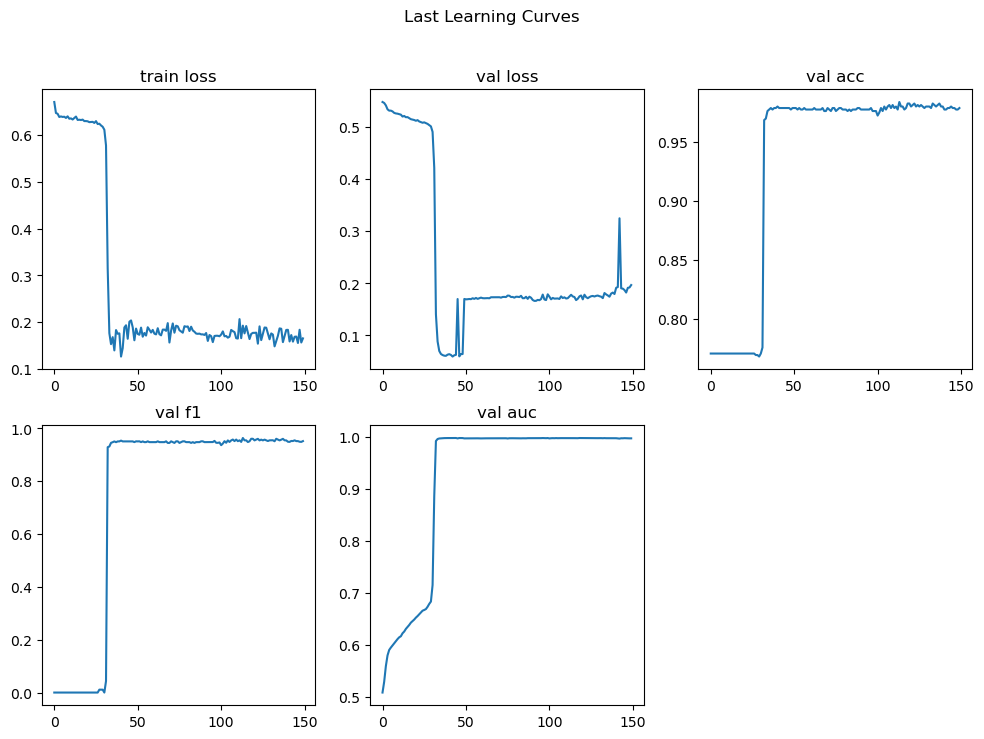

In [33]:
plt.figure(figsize=(12,8))

plt.subplot(231)
plt.plot(loss_buf)
plt.title("train loss")

plt.subplot(232)
plt.plot(val_loss_buf)
plt.title("val loss")

plt.subplot(233)
plt.plot(val_acc_buf)
plt.title("val acc")

plt.subplot(234)
plt.plot(val_f1_buf)
plt.title("val f1")

plt.subplot(235)
plt.plot(val_auc_buf)
plt.title("val auc")

plt.suptitle("Last Learning Curves")
plt.show()

In [34]:
val_acc_mean = []
val_f1_mean = []
val_auc_mean = []

for i in range(10):
    
    val_acc_i = np.load("./results/SAbDab/{}/{}/val_acc_{}_best.npy".format(data_type, model_name, i))
    val_acc_mean.append(val_acc_i)
    
    val_f1_i = np.load("./results/SAbDab/{}/{}/val_f1_{}_best.npy".format(data_type, model_name, i))
    val_f1_mean.append(val_f1_i)
    
    val_auc_i = np.load("./results/SAbDab/{}/{}/val_auc_{}_best.npy".format(data_type, model_name, i))
    val_auc_mean.append(val_auc_i)
    
    break
    
print("val acc mean: ", np.mean(val_acc_mean))
print("val f1 mean: ", np.mean(val_f1_mean))
print("val auc mean: ", np.mean(val_auc_mean))

val acc mean:  0.9732484076433121
val f1 mean:  0.9703808180535965
val auc mean:  0.9960178900702265


BiLSTM
- val acc mean:  0.9752300070771409
- val f1 mean:  0.9596004547190097
- val auc mean:  0.9961982339896467

demo - BiLSTM + remove "/"
- val acc mean:  0.9753715498938429
- val f1 mean:  0.9598416847843452
- val auc mean:  0.9965583867631231

InteractTransformer
- non-convergence @ first 10 epochs

InteractTransformerLSTM
- val acc mean:  0.9732484076433121
- val f1 mean:  0.9703808180535965
- val auc mean:  0.9960178900702265

SetTransformer
- val acc mean:  0.6771408351026185
- val f1 mean:  0.04578574402452007
- val auc mean:  0.5926709617479097

SetModel
- val acc mean:  0.9732484076433122
- val f1 mean:  0.9560846468263452
- val auc mean:  0.9952099378558822

SetModel_ablation
- use kmer & no seq_encoder
- val acc mean:  0.6771408351026186
- val f1 mean:  0.07555667240028481
- val auc mean:  0.6110399605027198

### BiLSTM

5fold

SAbDab: random AA for epitope seq_clip_mode=1

- 负样本-数据集中随机采样 neg_sample_mode=0
- val acc mean:  0.5003266448903407
- val f1 mean:  0.4014024178914616


- 负样本-随机序列 neg_sample_mode=1
- val acc mean:  0.7940270648623425
- val f1 mean:  0.765332158051016

use_pretrain
seq1 neg0
- 

### InteractTransformer

10fold

- CoV-AbDab [参数量 115571]
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017

5fold

SAbDab: random AA for epitope seq_clip_mode=0

- 负样本-数据集中随机采样 neg_sample_mode=0
- val acc mean:  0.5050863275781614
- val f1 mean:  0.26889531502460473
- 应当比随机序列做样本更难，因为抗体序列间的差异很小，只在关键区域有差异；其次是随机的AA所以序列不完整且没有生物意义，导致难分类；


- 负样本-随机序列 neg_sample_mode=1
- val acc mean:  0.8476901539897341
- val f1 mean:  0.8243978319230338
- 随机序列作为负样本用于测试可能不鲁棒，模型可能学得烂但测得高 -- 如何评估？-> 取k近邻的AA为epitope，该数据应当具有意义

5fold

SAbDab: k-nearest AA for epitope seq_clip_mode=1

- 负样本-数据集中随机采样 neg_sample_mode=0
- val acc mean:  0.5047130191320578
- val f1 mean:  0.3031313875079131


- 负样本-随机序列 neg_sample_mode=1
- val acc mean:  0.7128324778348111
- val f1 mean:  0.6669602710083161
- 存在过拟合导致崩掉的现象 (e.g. epoch1、epoch10)
- share modules [参数量 634930]
- val acc mean:  0.5620158656089593
- val f1 mean:  0.5473767284795179

### BiInteractTransformer

5fold

SAbDab: k-nearest AA for epitope seq_clip_mode=1

- 负样本-数据集中随机采样 neg_sample_mode=0
- val acc mean:  0.5009799346710219
- val f1 mean:  0.44771116164979696


- 负样本-随机序列 neg_sample_mode=1
- val acc mean:  0.6001866542230518
- val f1 mean:  0.7264313877322651
- share modules [参数量 1267059]
- val acc mean:  0.8121325244983668
- val f1 mean:  0.8445375055084579

### InteractCoattnTransformer

5fold

SAbDab: k-nearest AA for epitope seq_clip_mode=1

- 负样本-数据集中随机采样 neg_sample_mode=0
- [参数量 367858]
- val acc mean:  0.50648623425105
- val f1 mean:  0.47167367326203075


- 负样本-随机序列 neg_sample_mode=1
- val acc mean:  0.561455902939804
- val f1 mean:  0.4968735319816034
- share modules [参数量 647410]
- val acc mean:  0.7028464769015399
- val f1 mean:  0.6089746640207852
- share modules [参数量 251122]
- val acc mean:  0.643210452636491
- val f1 mean:  0.6049936565494491

### SetTransformer

5fold

SAbDab: k-nearest AA for epitope seq_clip_mode=1

- 负样本-数据集中随机采样 neg_sample_mode=0
- val acc mean:  0.5085394307046197
- val f1 mean:  0.45360035038396046


- 负样本-随机序列 neg_sample_mode=1
- val acc mean:  0.9564162389174055
- val f1 mean:  0.9517408054109368

### SetCoAttnTransformer

5fold

SAbDab: k-nearest AA for epitope seq_clip_mode=1

- 负样本-数据集中随机采样 neg_sample_mode=0



- 负样本-随机序列 neg_sample_mode=1
- val acc mean:  0.9985067662155857
- val f1 mean:  0.9985067657686753

### AlternateCoAttnModel

1 & 0
- val acc mean:  0.5012599160055997
- val f1 mean:  0.24524917697199666

# full training

In [76]:
def evaluate(model_name, data_type="seq1_neg0", use_pair=False):
    
    print("======================================")
    print("=================={}================".format(model_name))
    print("======================================")
    
    if use_pair==False:
        val_acc = np.load("./results/SAbDab/full/{}/{}/val_acc_buf.npy".format(data_type, model_name))
        val_f1 = np.load("./results/SAbDab/full/{}/{}/val_f1_buf.npy".format(data_type, model_name))
        val_auc = np.load("./results/SAbDab/full/{}/{}/val_auc_buf.npy".format(data_type, model_name))
        
    loss_buf = np.load("./results/SAbDab/full/{}/{}/loss_buf.npy".format(data_type, model_name))
    val_loss_buf = np.load("./results/SAbDab/full/{}/{}/val_loss_buf.npy".format(data_type, model_name))
    
    plt.figure(figsize=(12,8))

    plt.subplot(231)
    plt.plot(loss_buf)
    plt.title("train loss")

    plt.subplot(232)
    plt.plot(val_loss_buf)
    plt.title("val loss")

    if use_pair==False:
    
        plt.subplot(233)
        plt.plot(val_acc_buf)
        plt.title("val acc")

        plt.subplot(234)
        plt.plot(val_f1_buf)
        plt.title("val f1")

        plt.subplot(235)
        plt.plot(val_auc_buf)
        plt.title("val auc")

    plt.suptitle("Last Learning Curves")
    plt.show()


    if use_pair==False:
        val_acc = np.load("./results/SAbDab/full/{}/{}/val_acc_best.npy".format(data_type, model_name))

        val_f1 = np.load("./results/SAbDab/full/{}/{}/val_f1_best.npy".format(data_type, model_name))

        val_auc = np.load("./results/SAbDab/full/{}/{}/val_auc_best.npy".format(data_type, model_name))


        print("val acc mean: ", np.mean(val_acc))
        print("val f1 mean: ", np.mean(val_f1))
        print("val auc mean: ", np.mean(val_auc))

training lstm_encoder on SAbDab-full
loading preprocessed data from ./data/processed_data_clip1_neg0_usepairTrue.pkl
model parameters:  56000
Epoch 0


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.43it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.93it/s]


Epoch 0: 
 Train Loss	0.7206 
 Val Loss	0.8138

Epoch 1


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.30it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 123.28it/s]


Epoch 1: 
 Train Loss	0.7115 
 Val Loss	0.8011

Epoch 2


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 81.74it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.47it/s]


Epoch 2: 
 Train Loss	0.6919 
 Val Loss	0.7799

Epoch 3


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.47it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 124.12it/s]


Epoch 3: 
 Train Loss	0.6710 
 Val Loss	0.7636

Epoch 4


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.62it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 117.49it/s]


Epoch 4: 
 Train Loss	0.6547 
 Val Loss	0.7515

Epoch 5


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.57it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.22it/s]


Epoch 5: 
 Train Loss	0.6425 
 Val Loss	0.7423

Epoch 6


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.49it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.01it/s]


Epoch 6: 
 Train Loss	0.6330 
 Val Loss	0.7352

Epoch 7


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.50it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 113.32it/s]


Epoch 7: 
 Train Loss	0.6256 
 Val Loss	0.7295

Epoch 8


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.04it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 110.55it/s]


Epoch 8: 
 Train Loss	0.6198 
 Val Loss	0.7251

Epoch 9


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 77.05it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.13it/s]


Epoch 9: 
 Train Loss	0.6152 
 Val Loss	0.7215

Epoch 10


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.66it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 253.84it/s]


Epoch 10: 
 Train Loss	0.6117 
 Val Loss	0.7186

Epoch 11


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.93it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 223.46it/s]


Epoch 11: 
 Train Loss	0.6090 
 Val Loss	0.7162

Epoch 12


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.00it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.20it/s]


Epoch 12: 
 Train Loss	0.6068 
 Val Loss	0.7143

Epoch 13


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.32it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 110.40it/s]


Epoch 13: 
 Train Loss	0.6048 
 Val Loss	0.7126

Epoch 14


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.17it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.17it/s]


Epoch 14: 
 Train Loss	0.6031 
 Val Loss	0.7111

Epoch 15


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.74it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.65it/s]


Epoch 15: 
 Train Loss	0.6015 
 Val Loss	0.7099

Epoch 16


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.19it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 544.75it/s]


Epoch 16: 
 Train Loss	0.5999 
 Val Loss	0.7087

Epoch 17


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.84it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.00it/s]


Epoch 17: 
 Train Loss	0.5984 
 Val Loss	0.7076

Epoch 18


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.25it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.94it/s]


Epoch 18: 
 Train Loss	0.5968 
 Val Loss	0.7067

Epoch 19


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.80it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.55it/s]


Epoch 19: 
 Train Loss	0.5951 
 Val Loss	0.7057

Epoch 20


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.78it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.76it/s]


Epoch 20: 
 Train Loss	0.5935 
 Val Loss	0.7048

Epoch 21


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.12it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 159.54it/s]


Epoch 21: 
 Train Loss	0.5917 
 Val Loss	0.7040

Epoch 22


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.30it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.86it/s]


Epoch 22: 
 Train Loss	0.5899 
 Val Loss	0.7031

Epoch 23


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.64it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 112.61it/s]


Epoch 23: 
 Train Loss	0.5881 
 Val Loss	0.7023

Epoch 24


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.66it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.26it/s]


Epoch 24: 
 Train Loss	0.5862 
 Val Loss	0.7015

Epoch 25


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.40it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 130.06it/s]


Epoch 25: 
 Train Loss	0.5844 
 Val Loss	0.7007

Epoch 26


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.18it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.94it/s]


Epoch 26: 
 Train Loss	0.5825 
 Val Loss	0.6999

Epoch 27


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.45it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 258.82it/s]


Epoch 27: 
 Train Loss	0.5806 
 Val Loss	0.6991

Epoch 28


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.32it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 152.90it/s]


Epoch 28: 
 Train Loss	0.5787 
 Val Loss	0.6983

Epoch 29


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.86it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.69it/s]


Epoch 29: 
 Train Loss	0.5768 
 Val Loss	0.6975

Epoch 30


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.94it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 201.39it/s]


Epoch 30: 
 Train Loss	0.5747 
 Val Loss	0.6967

Epoch 31


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 73.71it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 114.31it/s]


Epoch 31: 
 Train Loss	0.5726 
 Val Loss	0.6959

Epoch 32


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.87it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.85it/s]


Epoch 32: 
 Train Loss	0.5704 
 Val Loss	0.6950

Epoch 33


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.04it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 110.17it/s]


Epoch 33: 
 Train Loss	0.5681 
 Val Loss	0.6941

Epoch 34


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.47it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.34it/s]


Epoch 34: 
 Train Loss	0.5657 
 Val Loss	0.6932

Epoch 35


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.56it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.87it/s]


Epoch 35: 
 Train Loss	0.5633 
 Val Loss	0.6922

Epoch 36


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 77.43it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 113.86it/s]


Epoch 36: 
 Train Loss	0.5608 
 Val Loss	0.6912

Epoch 37


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.93it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 497.20it/s]


Epoch 37: 
 Train Loss	0.5582 
 Val Loss	0.6904

Epoch 38


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 73.20it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 247.00it/s]


Epoch 38: 
 Train Loss	0.5557 
 Val Loss	0.6898

Epoch 39


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.99it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.87it/s]


Epoch 39: 
 Train Loss	0.5532 
 Val Loss	0.6896

Epoch 40


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.79it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 130.81it/s]


Epoch 40: 
 Train Loss	0.5508 
 Val Loss	0.6896

Epoch 41


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 73.99it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.74it/s]


Epoch 41: 
 Train Loss	0.5484 
 Val Loss	0.6901

Epoch 42


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.29it/s]


lr:  0.0001


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 99.85it/s]


Epoch 42: 
 Train Loss	0.5462 
 Val Loss	0.6907

Epoch 43


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.25it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 128.46it/s]


Epoch 43: 
 Train Loss	0.5440 
 Val Loss	0.6916

Epoch 44


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.84it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.52it/s]


Epoch 44: 
 Train Loss	0.5419 
 Val Loss	0.6925

Epoch 45


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.02it/s]


lr:  0.0001


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 99.54it/s]


Epoch 45: 
 Train Loss	0.5398 
 Val Loss	0.6936

Epoch 46


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 77.31it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.54it/s]


Epoch 46: 
 Train Loss	0.5378 
 Val Loss	0.6948

Epoch 47


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.88it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 138.19it/s]


Epoch 47: 
 Train Loss	0.5358 
 Val Loss	0.6962

Epoch 48


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.06it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 493.14it/s]


Epoch 48: 
 Train Loss	0.5338 
 Val Loss	0.6975

Epoch 49


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.87it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 270.30it/s]


Epoch 49: 
 Train Loss	0.5318 
 Val Loss	0.6989

Epoch 50


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.48it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.77it/s]


Epoch 50: 
 Train Loss	0.5299 
 Val Loss	0.7003

Epoch 51


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.05it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.55it/s]


Epoch 51: 
 Train Loss	0.5280 
 Val Loss	0.7016

Epoch 52


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.31it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 127.27it/s]


Epoch 52: 
 Train Loss	0.5261 
 Val Loss	0.7029

Epoch 53


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.38it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.77it/s]


Epoch 53: 
 Train Loss	0.5242 
 Val Loss	0.7042

Epoch 54


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.79it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.90it/s]


Epoch 54: 
 Train Loss	0.5223 
 Val Loss	0.7054

Epoch 55


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 73.63it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 184.10it/s]


Epoch 55: 
 Train Loss	0.5204 
 Val Loss	0.7065

Epoch 56


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.32it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 107.38it/s]


Epoch 56: 
 Train Loss	0.5184 
 Val Loss	0.7075

Epoch 57


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.95it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 134.65it/s]


Epoch 57: 
 Train Loss	0.5165 
 Val Loss	0.7085

Epoch 58


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.69it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.88it/s]


Epoch 58: 
 Train Loss	0.5145 
 Val Loss	0.7095

Epoch 59


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 77.31it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.74it/s]


Epoch 59: 
 Train Loss	0.5125 
 Val Loss	0.7105

Epoch 60


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.54it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 126.64it/s]


Epoch 60: 
 Train Loss	0.5106 
 Val Loss	0.7115

Epoch 61


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.59it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.90it/s]


Epoch 61: 
 Train Loss	0.5086 
 Val Loss	0.7125

Epoch 62


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.60it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 269.10it/s]


Epoch 62: 
 Train Loss	0.5066 
 Val Loss	0.7136

Epoch 63


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.40it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 120.74it/s]


Epoch 63: 
 Train Loss	0.5046 
 Val Loss	0.7147

Epoch 64


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.09it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.88it/s]


Epoch 64: 
 Train Loss	0.5027 
 Val Loss	0.7158

Epoch 65


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.88it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.07it/s]


Epoch 65: 
 Train Loss	0.5008 
 Val Loss	0.7168

Epoch 66


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.55it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.43it/s]


Epoch 66: 
 Train Loss	0.4989 
 Val Loss	0.7177

Epoch 67


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 80.22it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 120.08it/s]


Epoch 67: 
 Train Loss	0.4970 
 Val Loss	0.7185

Epoch 68


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 73.99it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 225.94it/s]


Epoch 68: 
 Train Loss	0.4952 
 Val Loss	0.7192

Epoch 69


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.37it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.01it/s]


Epoch 69: 
 Train Loss	0.4934 
 Val Loss	0.7198

Epoch 70


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.06it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.63it/s]


Epoch 70: 
 Train Loss	0.4916 
 Val Loss	0.7203

Epoch 71


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.97it/s]


lr:  0.0001


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 99.95it/s]


Epoch 71: 
 Train Loss	0.4899 
 Val Loss	0.7207

Epoch 72


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.43it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 106.35it/s]


Epoch 72: 
 Train Loss	0.4881 
 Val Loss	0.7212

Epoch 73


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.59it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.36it/s]


Epoch 73: 
 Train Loss	0.4864 
 Val Loss	0.7216

Epoch 74


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.38it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 119.22it/s]


Epoch 74: 
 Train Loss	0.4847 
 Val Loss	0.7220

Epoch 75


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.56it/s]


lr:  0.0001


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 99.46it/s]


Epoch 75: 
 Train Loss	0.4830 
 Val Loss	0.7224

Epoch 76


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.40it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.32it/s]


Epoch 76: 
 Train Loss	0.4814 
 Val Loss	0.7227

Epoch 77


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.68it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.73it/s]


Epoch 77: 
 Train Loss	0.4798 
 Val Loss	0.7230

Epoch 78


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.59it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 331.19it/s]


Epoch 78: 
 Train Loss	0.4782 
 Val Loss	0.7232

Epoch 79


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.75it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.11it/s]


Epoch 79: 
 Train Loss	0.4766 
 Val Loss	0.7233

Epoch 80


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.67it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.08it/s]


Epoch 80: 
 Train Loss	0.4751 
 Val Loss	0.7234

Epoch 81


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 80.47it/s]


lr:  0.0001


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 99.69it/s]


Epoch 81: 
 Train Loss	0.4736 
 Val Loss	0.7233

Epoch 82


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.09it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.73it/s]


Epoch 82: 
 Train Loss	0.4721 
 Val Loss	0.7232

Epoch 83


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.99it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 113.75it/s]


Epoch 83: 
 Train Loss	0.4706 
 Val Loss	0.7231

Epoch 84


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.77it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.69it/s]


Epoch 84: 
 Train Loss	0.4691 
 Val Loss	0.7230

Epoch 85


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.42it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 107.48it/s]


Epoch 85: 
 Train Loss	0.4676 
 Val Loss	0.7229

Epoch 86


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.53it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 128.03it/s]


Epoch 86: 
 Train Loss	0.4661 
 Val Loss	0.7229

Epoch 87


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.50it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 134.53it/s]


Epoch 87: 
 Train Loss	0.4646 
 Val Loss	0.7229

Epoch 88


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.11it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.16it/s]


Epoch 88: 
 Train Loss	0.4631 
 Val Loss	0.7230

Epoch 89


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.18it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 146.19it/s]


Epoch 89: 
 Train Loss	0.4616 
 Val Loss	0.7231

Epoch 90


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.64it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 117.21it/s]


Epoch 90: 
 Train Loss	0.4601 
 Val Loss	0.7232

Epoch 91


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.97it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 223.90it/s]


Epoch 91: 
 Train Loss	0.4586 
 Val Loss	0.7234

Epoch 92


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.40it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 251.04it/s]


Epoch 92: 
 Train Loss	0.4571 
 Val Loss	0.7235

Epoch 93


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.77it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 132.79it/s]


Epoch 93: 
 Train Loss	0.4556 
 Val Loss	0.7237

Epoch 94


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.00it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 123.02it/s]


Epoch 94: 
 Train Loss	0.4541 
 Val Loss	0.7240

Epoch 95


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 73.57it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 299.88it/s]


Epoch 95: 
 Train Loss	0.4525 
 Val Loss	0.7244

Epoch 96


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.14it/s]


lr:  0.0001


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 99.74it/s]


Epoch 96: 
 Train Loss	0.4510 
 Val Loss	0.7248

Epoch 97


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.51it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.86it/s]


Epoch 97: 
 Train Loss	0.4494 
 Val Loss	0.7252

Epoch 98


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.40it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 542.34it/s]


Epoch 98: 
 Train Loss	0.4477 
 Val Loss	0.7256

Epoch 99


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.03it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 230.65it/s]


Epoch 99: 
 Train Loss	0.4461 
 Val Loss	0.7259

Epoch 100


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.12it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 225.99it/s]


Epoch 100: 
 Train Loss	0.4444 
 Val Loss	0.7261

Epoch 101


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.36it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 127.18it/s]


Epoch 101: 
 Train Loss	0.4428 
 Val Loss	0.7262

Epoch 102


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.37it/s]


lr:  0.0001


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 99.51it/s]


Epoch 102: 
 Train Loss	0.4411 
 Val Loss	0.7262

Epoch 103


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 77.88it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 444.64it/s]


Epoch 103: 
 Train Loss	0.4394 
 Val Loss	0.7263

Epoch 104


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.60it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.82it/s]


Epoch 104: 
 Train Loss	0.4377 
 Val Loss	0.7265

Epoch 105


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.41it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.00it/s]


Epoch 105: 
 Train Loss	0.4360 
 Val Loss	0.7266

Epoch 106


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.82it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.72it/s]


Epoch 106: 
 Train Loss	0.4342 
 Val Loss	0.7267

Epoch 107


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 77.05it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 125.55it/s]


Epoch 107: 
 Train Loss	0.4325 
 Val Loss	0.7268

Epoch 108


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 77.77it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.43it/s]


Epoch 108: 
 Train Loss	0.4307 
 Val Loss	0.7269

Epoch 109


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.25it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.66it/s]


Epoch 109: 
 Train Loss	0.4290 
 Val Loss	0.7269

Epoch 110


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.33it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.14it/s]


Epoch 110: 
 Train Loss	0.4272 
 Val Loss	0.7270

Epoch 111


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.28it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.20it/s]


Epoch 111: 
 Train Loss	0.4255 
 Val Loss	0.7270

Epoch 112


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.14it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.01it/s]


Epoch 112: 
 Train Loss	0.4238 
 Val Loss	0.7270

Epoch 113


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.97it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 133.04it/s]


Epoch 113: 
 Train Loss	0.4220 
 Val Loss	0.7270

Epoch 114


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.24it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 125.53it/s]


Epoch 114: 
 Train Loss	0.4202 
 Val Loss	0.7270

Epoch 115


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 73.94it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 134.51it/s]


Epoch 115: 
 Train Loss	0.4185 
 Val Loss	0.7270

Epoch 116


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.77it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.51it/s]


Epoch 116: 
 Train Loss	0.4167 
 Val Loss	0.7270

Epoch 117


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.06it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.70it/s]


Epoch 117: 
 Train Loss	0.4150 
 Val Loss	0.7269

Epoch 118


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.94it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 107.98it/s]


Epoch 118: 
 Train Loss	0.4133 
 Val Loss	0.7267

Epoch 119


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.04it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.91it/s]


Epoch 119: 
 Train Loss	0.4115 
 Val Loss	0.7265

Epoch 120


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.41it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 130.16it/s]


Epoch 120: 
 Train Loss	0.4099 
 Val Loss	0.7263

Epoch 121


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.51it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 108.21it/s]


Epoch 121: 
 Train Loss	0.4082 
 Val Loss	0.7260

Epoch 122


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.13it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 113.35it/s]


Epoch 122: 
 Train Loss	0.4065 
 Val Loss	0.7257

Epoch 123


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.95it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 115.73it/s]


Epoch 123: 
 Train Loss	0.4048 
 Val Loss	0.7255

Epoch 124


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.26it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.06it/s]


Epoch 124: 
 Train Loss	0.4031 
 Val Loss	0.7253

Epoch 125


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.14it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.08it/s]


Epoch 125: 
 Train Loss	0.4014 
 Val Loss	0.7252

Epoch 126


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.31it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 174.59it/s]


Epoch 126: 
 Train Loss	0.3998 
 Val Loss	0.7250

Epoch 127


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.13it/s]


lr:  0.0001


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 99.58it/s]


Epoch 127: 
 Train Loss	0.3981 
 Val Loss	0.7249

Epoch 128


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.69it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.95it/s]


Epoch 128: 
 Train Loss	0.3964 
 Val Loss	0.7247

Epoch 129


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.38it/s]


lr:  0.0001


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 99.99it/s]


Epoch 129: 
 Train Loss	0.3947 
 Val Loss	0.7246

Epoch 130


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 77.02it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 255.58it/s]


Epoch 130: 
 Train Loss	0.3930 
 Val Loss	0.7245

Epoch 131


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 73.74it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 135.30it/s]


Epoch 131: 
 Train Loss	0.3913 
 Val Loss	0.7245

Epoch 132


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.16it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.62it/s]


Epoch 132: 
 Train Loss	0.3896 
 Val Loss	0.7245

Epoch 133


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.16it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.32it/s]


Epoch 133: 
 Train Loss	0.3879 
 Val Loss	0.7245

Epoch 134


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.46it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 136.59it/s]


Epoch 134: 
 Train Loss	0.3862 
 Val Loss	0.7244

Epoch 135


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.63it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 107.72it/s]


Epoch 135: 
 Train Loss	0.3846 
 Val Loss	0.7243

Epoch 136


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.16it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.00it/s]


Epoch 136: 
 Train Loss	0.3829 
 Val Loss	0.7242

Epoch 137


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.81it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 117.78it/s]


Epoch 137: 
 Train Loss	0.3813 
 Val Loss	0.7242

Epoch 138


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.07it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.90it/s]


Epoch 138: 
 Train Loss	0.3797 
 Val Loss	0.7241

Epoch 139


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.66it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.40it/s]


Epoch 139: 
 Train Loss	0.3781 
 Val Loss	0.7241

Epoch 140


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.73it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.11it/s]


Epoch 140: 
 Train Loss	0.3765 
 Val Loss	0.7241

Epoch 141


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.32it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.18it/s]


Epoch 141: 
 Train Loss	0.3748 
 Val Loss	0.7240

Epoch 142


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 78.17it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.84it/s]


Epoch 142: 
 Train Loss	0.3732 
 Val Loss	0.7238

Epoch 143


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.63it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.16it/s]


Epoch 143: 
 Train Loss	0.3716 
 Val Loss	0.7237

Epoch 144


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.02it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.37it/s]


Epoch 144: 
 Train Loss	0.3700 
 Val Loss	0.7235

Epoch 145


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.35it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.83it/s]


Epoch 145: 
 Train Loss	0.3685 
 Val Loss	0.7234

Epoch 146


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 77.38it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 132.05it/s]


Epoch 146: 
 Train Loss	0.3669 
 Val Loss	0.7232

Epoch 147


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.54it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 114.52it/s]


Epoch 147: 
 Train Loss	0.3653 
 Val Loss	0.7230

Epoch 148


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.30it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 138.65it/s]


Epoch 148: 
 Train Loss	0.3637 
 Val Loss	0.7228

Epoch 149


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.08it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.01it/s]


Epoch 149: 
 Train Loss	0.3621 
 Val Loss	0.7227

Epoch 150


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 77.23it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.26it/s]


Epoch 150: 
 Train Loss	0.3605 
 Val Loss	0.7224

Epoch 151


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.26it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 150.71it/s]


Epoch 151: 
 Train Loss	0.3590 
 Val Loss	0.7222

Epoch 152


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.29it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.14it/s]


Epoch 152: 
 Train Loss	0.3574 
 Val Loss	0.7221

Epoch 153


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.93it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 405.06it/s]


Epoch 153: 
 Train Loss	0.3559 
 Val Loss	0.7220

Epoch 154


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 78.50it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 135.81it/s]


Epoch 154: 
 Train Loss	0.3544 
 Val Loss	0.7218

Epoch 155


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.53it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.97it/s]


Epoch 155: 
 Train Loss	0.3528 
 Val Loss	0.7217

Epoch 156


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.29it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 108.20it/s]


Epoch 156: 
 Train Loss	0.3513 
 Val Loss	0.7214

Epoch 157


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.52it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.83it/s]


Epoch 157: 
 Train Loss	0.3498 
 Val Loss	0.7212

Epoch 158


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.87it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.99it/s]


Epoch 158: 
 Train Loss	0.3483 
 Val Loss	0.7210

Epoch 159


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 78.71it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.87it/s]


Epoch 159: 
 Train Loss	0.3469 
 Val Loss	0.7207

Epoch 160


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.50it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.66it/s]


Epoch 160: 
 Train Loss	0.3454 
 Val Loss	0.7206

Epoch 161


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 77.26it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 508.96it/s]


Epoch 161: 
 Train Loss	0.3440 
 Val Loss	0.7204

Epoch 162


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.47it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.82it/s]


Epoch 162: 
 Train Loss	0.3425 
 Val Loss	0.7202

Epoch 163


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.96it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.82it/s]


Epoch 163: 
 Train Loss	0.3411 
 Val Loss	0.7200

Epoch 164


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.42it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.87it/s]


Epoch 164: 
 Train Loss	0.3397 
 Val Loss	0.7200

Epoch 165


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.09it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 116.93it/s]


Epoch 165: 
 Train Loss	0.3383 
 Val Loss	0.7198

Epoch 166


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.40it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.03it/s]


Epoch 166: 
 Train Loss	0.3368 
 Val Loss	0.7198

Epoch 167


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.26it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 141.10it/s]


Epoch 167: 
 Train Loss	0.3354 
 Val Loss	0.7199

Epoch 168


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.19it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 124.50it/s]


Epoch 168: 
 Train Loss	0.3340 
 Val Loss	0.7199

Epoch 169


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.75it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.86it/s]


Epoch 169: 
 Train Loss	0.3326 
 Val Loss	0.7202

Epoch 170


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.20it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 125.64it/s]


Epoch 170: 
 Train Loss	0.3312 
 Val Loss	0.7202

Epoch 171


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 73.50it/s]


lr:  0.0001


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 99.80it/s]


Epoch 171: 
 Train Loss	0.3298 
 Val Loss	0.7205

Epoch 172


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 77.14it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.26it/s]


Epoch 172: 
 Train Loss	0.3285 
 Val Loss	0.7207

Epoch 173


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.42it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 383.26it/s]


Epoch 173: 
 Train Loss	0.3271 
 Val Loss	0.7209

Epoch 174


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.61it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 127.71it/s]


Epoch 174: 
 Train Loss	0.3257 
 Val Loss	0.7211

Epoch 175


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.84it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 141.86it/s]


Epoch 175: 
 Train Loss	0.3244 
 Val Loss	0.7213

Epoch 176


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.88it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 124.10it/s]


Epoch 176: 
 Train Loss	0.3230 
 Val Loss	0.7216

Epoch 177


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.19it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.34it/s]


Epoch 177: 
 Train Loss	0.3217 
 Val Loss	0.7224

Epoch 178


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.19it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.56it/s]


Epoch 178: 
 Train Loss	0.3204 
 Val Loss	0.7231

Epoch 179


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.12it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 124.31it/s]


Epoch 179: 
 Train Loss	0.3191 
 Val Loss	0.7240

Epoch 180


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.64it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 105.69it/s]


Epoch 180: 
 Train Loss	0.3178 
 Val Loss	0.7247

Epoch 181


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.45it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 134.89it/s]


Epoch 181: 
 Train Loss	0.3165 
 Val Loss	0.7253

Epoch 182


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.85it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 588.24it/s]


Epoch 182: 
 Train Loss	0.3152 
 Val Loss	0.7261

Epoch 183


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 78.75it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.21it/s]


Epoch 183: 
 Train Loss	0.3139 
 Val Loss	0.7265

Epoch 184


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.18it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.86it/s]


Epoch 184: 
 Train Loss	0.3127 
 Val Loss	0.7273

Epoch 185


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.38it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 127.75it/s]


Epoch 185: 
 Train Loss	0.3114 
 Val Loss	0.7279

Epoch 186


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.40it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.09it/s]


Epoch 186: 
 Train Loss	0.3102 
 Val Loss	0.7280

Epoch 187


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.58it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.61it/s]


Epoch 187: 
 Train Loss	0.3089 
 Val Loss	0.7283

Epoch 188


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.28it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.40it/s]


Epoch 188: 
 Train Loss	0.3076 
 Val Loss	0.7288

Epoch 189


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.41it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 129.05it/s]


Epoch 189: 
 Train Loss	0.3064 
 Val Loss	0.7291

Epoch 190


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.26it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.66it/s]


Epoch 190: 
 Train Loss	0.3052 
 Val Loss	0.7295

Epoch 191


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.24it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.16it/s]


Epoch 191: 
 Train Loss	0.3039 
 Val Loss	0.7300

Epoch 192


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 77.19it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.57it/s]


Epoch 192: 
 Train Loss	0.3027 
 Val Loss	0.7305

Epoch 193


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.43it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 124.55it/s]


Epoch 193: 
 Train Loss	0.3015 
 Val Loss	0.7313

Epoch 194


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.50it/s]


lr:  0.0001


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 99.73it/s]


Epoch 194: 
 Train Loss	0.3003 
 Val Loss	0.7318

Epoch 195


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.65it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.66it/s]


Epoch 195: 
 Train Loss	0.2991 
 Val Loss	0.7323

Epoch 196


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.06it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.87it/s]


Epoch 196: 
 Train Loss	0.2979 
 Val Loss	0.7333

Epoch 197


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 77.88it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.71it/s]


Epoch 197: 
 Train Loss	0.2967 
 Val Loss	0.7339

Epoch 198


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.97it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.70it/s]


Epoch 198: 
 Train Loss	0.2955 
 Val Loss	0.7347

Epoch 199


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.35it/s]


lr:  0.0001


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 99.87it/s]


Epoch 199: 
 Train Loss	0.2944 
 Val Loss	0.7355

Epoch 200


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.88it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.53it/s]


Epoch 200: 
 Train Loss	0.2932 
 Val Loss	0.7367

Epoch 201


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 73.76it/s]


lr:  0.0001


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 99.86it/s]


Epoch 201: 
 Train Loss	0.2921 
 Val Loss	0.7373

Epoch 202


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.32it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.47it/s]


Epoch 202: 
 Train Loss	0.2909 
 Val Loss	0.7386

Epoch 203


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.48it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 139.58it/s]


Epoch 203: 
 Train Loss	0.2898 
 Val Loss	0.7395

Epoch 204


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.00it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 144.12it/s]


Epoch 204: 
 Train Loss	0.2887 
 Val Loss	0.7405

Epoch 205


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.53it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 136.49it/s]


Epoch 205: 
 Train Loss	0.2875 
 Val Loss	0.7412

Epoch 206


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.80it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 407.59it/s]


Epoch 206: 
 Train Loss	0.2864 
 Val Loss	0.7418

Epoch 207


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.96it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.76it/s]


Epoch 207: 
 Train Loss	0.2853 
 Val Loss	0.7425

Epoch 208


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.27it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.41it/s]


Epoch 208: 
 Train Loss	0.2843 
 Val Loss	0.7432

Epoch 209


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.82it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.15it/s]


Epoch 209: 
 Train Loss	0.2832 
 Val Loss	0.7442

Epoch 210


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.32it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.64it/s]


Epoch 210: 
 Train Loss	0.2821 
 Val Loss	0.7448

Epoch 211


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.95it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 163.98it/s]


Epoch 211: 
 Train Loss	0.2810 
 Val Loss	0.7455

Epoch 212


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 73.40it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 230.74it/s]


Epoch 212: 
 Train Loss	0.2800 
 Val Loss	0.7460

Epoch 213


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.79it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.58it/s]


Epoch 213: 
 Train Loss	0.2789 
 Val Loss	0.7466

Epoch 214


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.94it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 117.46it/s]


Epoch 214: 
 Train Loss	0.2779 
 Val Loss	0.7473

Epoch 215


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.54it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.02it/s]


Epoch 215: 
 Train Loss	0.2769 
 Val Loss	0.7482

Epoch 216


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.87it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 348.49it/s]


Epoch 216: 
 Train Loss	0.2759 
 Val Loss	0.7487

Epoch 217


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.77it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 172.61it/s]


Epoch 217: 
 Train Loss	0.2749 
 Val Loss	0.7497

Epoch 218


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 79.31it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 345.19it/s]


Epoch 218: 
 Train Loss	0.2739 
 Val Loss	0.7506

Epoch 219


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.54it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.04it/s]


Epoch 219: 
 Train Loss	0.2729 
 Val Loss	0.7512

Epoch 220


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.27it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 124.57it/s]


Epoch 220: 
 Train Loss	0.2719 
 Val Loss	0.7517

Epoch 221


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.42it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 120.21it/s]


Epoch 221: 
 Train Loss	0.2709 
 Val Loss	0.7524

Epoch 222


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.07it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 109.82it/s]


Epoch 222: 
 Train Loss	0.2699 
 Val Loss	0.7534

Epoch 223


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.71it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.82it/s]


Epoch 223: 
 Train Loss	0.2690 
 Val Loss	0.7539

Epoch 224


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.85it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.48it/s]


Epoch 224: 
 Train Loss	0.2680 
 Val Loss	0.7546

Epoch 225


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.18it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.81it/s]


Epoch 225: 
 Train Loss	0.2670 
 Val Loss	0.7553

Epoch 226


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.97it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 442.20it/s]


Epoch 226: 
 Train Loss	0.2661 
 Val Loss	0.7559

Epoch 227


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.51it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 284.79it/s]


Epoch 227: 
 Train Loss	0.2652 
 Val Loss	0.7566

Epoch 228


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.23it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.10it/s]


Epoch 228: 
 Train Loss	0.2642 
 Val Loss	0.7573

Epoch 229


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.19it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.84it/s]


Epoch 229: 
 Train Loss	0.2634 
 Val Loss	0.7577

Epoch 230


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.42it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.92it/s]


Epoch 230: 
 Train Loss	0.2624 
 Val Loss	0.7584

Epoch 231


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.46it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 125.38it/s]


Epoch 231: 
 Train Loss	0.2615 
 Val Loss	0.7590

Epoch 232


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.52it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 502.17it/s]


Epoch 232: 
 Train Loss	0.2606 
 Val Loss	0.7596

Epoch 233


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 79.05it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.94it/s]


Epoch 233: 
 Train Loss	0.2597 
 Val Loss	0.7606

Epoch 234


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.92it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 133.54it/s]


Epoch 234: 
 Train Loss	0.2588 
 Val Loss	0.7617

Epoch 235


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.89it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.97it/s]


Epoch 235: 
 Train Loss	0.2580 
 Val Loss	0.7622

Epoch 236


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.32it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 107.36it/s]


Epoch 236: 
 Train Loss	0.2571 
 Val Loss	0.7631

Epoch 237


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.33it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 150.97it/s]


Epoch 237: 
 Train Loss	0.2562 
 Val Loss	0.7637

Epoch 238


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.79it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 125.48it/s]


Epoch 238: 
 Train Loss	0.2554 
 Val Loss	0.7644

Epoch 239


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.84it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 243.40it/s]


Epoch 239: 
 Train Loss	0.2545 
 Val Loss	0.7649

Epoch 240


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.34it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.75it/s]


Epoch 240: 
 Train Loss	0.2536 
 Val Loss	0.7657

Epoch 241


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.18it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.91it/s]


Epoch 241: 
 Train Loss	0.2528 
 Val Loss	0.7663

Epoch 242


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 77.18it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.28it/s]


Epoch 242: 
 Train Loss	0.2519 
 Val Loss	0.7669

Epoch 243


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.71it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.52it/s]


Epoch 243: 
 Train Loss	0.2511 
 Val Loss	0.7676

Epoch 244


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.71it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 135.97it/s]


Epoch 244: 
 Train Loss	0.2503 
 Val Loss	0.7683

Epoch 245


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.50it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 123.20it/s]


Epoch 245: 
 Train Loss	0.2494 
 Val Loss	0.7686

Epoch 246


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.33it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.46it/s]


Epoch 246: 
 Train Loss	0.2486 
 Val Loss	0.7692

Epoch 247


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.48it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.90it/s]


Epoch 247: 
 Train Loss	0.2478 
 Val Loss	0.7701

Epoch 248


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.54it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.51it/s]


Epoch 248: 
 Train Loss	0.2470 
 Val Loss	0.7708

Epoch 249


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 77.02it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.64it/s]


Epoch 249: 
 Train Loss	0.2462 
 Val Loss	0.7712

Epoch 250


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.24it/s]


lr:  0.0001


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 99.83it/s]


Epoch 250: 
 Train Loss	0.2453 
 Val Loss	0.7717

Epoch 251


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 77.10it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.90it/s]


Epoch 251: 
 Train Loss	0.2446 
 Val Loss	0.7725

Epoch 252


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.09it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 115.40it/s]


Epoch 252: 
 Train Loss	0.2438 
 Val Loss	0.7729

Epoch 253


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.28it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.02it/s]


Epoch 253: 
 Train Loss	0.2430 
 Val Loss	0.7731

Epoch 254


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.15it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 141.28it/s]


Epoch 254: 
 Train Loss	0.2422 
 Val Loss	0.7735

Epoch 255


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.84it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.42it/s]


Epoch 255: 
 Train Loss	0.2415 
 Val Loss	0.7742

Epoch 256


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.33it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.84it/s]


Epoch 256: 
 Train Loss	0.2407 
 Val Loss	0.7748

Epoch 257


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.02it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 182.99it/s]


Epoch 257: 
 Train Loss	0.2399 
 Val Loss	0.7760

Epoch 258


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.02it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 201.85it/s]


Epoch 258: 
 Train Loss	0.2392 
 Val Loss	0.7766

Epoch 259


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.51it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 120.60it/s]


Epoch 259: 
 Train Loss	0.2384 
 Val Loss	0.7776

Epoch 260


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.93it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 120.01it/s]


Epoch 260: 
 Train Loss	0.2377 
 Val Loss	0.7782

Epoch 261


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.08it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.39it/s]


Epoch 261: 
 Train Loss	0.2370 
 Val Loss	0.7790

Epoch 262


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 79.50it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 107.36it/s]


Epoch 262: 
 Train Loss	0.2363 
 Val Loss	0.7794

Epoch 263


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.39it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 146.61it/s]


Epoch 263: 
 Train Loss	0.2355 
 Val Loss	0.7797

Epoch 264


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 73.46it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 150.55it/s]


Epoch 264: 
 Train Loss	0.2348 
 Val Loss	0.7807

Epoch 265


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.18it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 131.16it/s]


Epoch 265: 
 Train Loss	0.2341 
 Val Loss	0.7817

Epoch 266


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.87it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 118.11it/s]


Epoch 266: 
 Train Loss	0.2334 
 Val Loss	0.7826

Epoch 267


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.28it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 445.75it/s]


Epoch 267: 
 Train Loss	0.2327 
 Val Loss	0.7831

Epoch 268


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.41it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.20it/s]


Epoch 268: 
 Train Loss	0.2320 
 Val Loss	0.7838

Epoch 269


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.47it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 140.25it/s]


Epoch 269: 
 Train Loss	0.2313 
 Val Loss	0.7848

Epoch 270


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.65it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.16it/s]


Epoch 270: 
 Train Loss	0.2306 
 Val Loss	0.7853

Epoch 271


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 78.95it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.67it/s]


Epoch 271: 
 Train Loss	0.2299 
 Val Loss	0.7859

Epoch 272


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.81it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 120.85it/s]


Epoch 272: 
 Train Loss	0.2292 
 Val Loss	0.7862

Epoch 273


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.85it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 113.41it/s]


Epoch 273: 
 Train Loss	0.2285 
 Val Loss	0.7870

Epoch 274


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.17it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.93it/s]


Epoch 274: 
 Train Loss	0.2278 
 Val Loss	0.7872

Epoch 275


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.87it/s]


lr:  0.0001


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 99.90it/s]


Epoch 275: 
 Train Loss	0.2272 
 Val Loss	0.7873

Epoch 276


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 77.19it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.34it/s]


Epoch 276: 
 Train Loss	0.2265 
 Val Loss	0.7874

Epoch 277


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.47it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 133.58it/s]


Epoch 277: 
 Train Loss	0.2258 
 Val Loss	0.7877

Epoch 278


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.64it/s]


lr:  0.0001


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 99.94it/s]


Epoch 278: 
 Train Loss	0.2252 
 Val Loss	0.7883

Epoch 279


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.61it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 391.59it/s]


Epoch 279: 
 Train Loss	0.2245 
 Val Loss	0.7890

Epoch 280


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.52it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 117.38it/s]


Epoch 280: 
 Train Loss	0.2239 
 Val Loss	0.7903

Epoch 281


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.76it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.35it/s]


Epoch 281: 
 Train Loss	0.2232 
 Val Loss	0.7907

Epoch 282


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.80it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.79it/s]


Epoch 282: 
 Train Loss	0.2226 
 Val Loss	0.7914

Epoch 283


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.99it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.76it/s]


Epoch 283: 
 Train Loss	0.2219 
 Val Loss	0.7919

Epoch 284


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.23it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.42it/s]


Epoch 284: 
 Train Loss	0.2213 
 Val Loss	0.7922

Epoch 285


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.82it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.20it/s]


Epoch 285: 
 Train Loss	0.2207 
 Val Loss	0.7927

Epoch 286


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 77.00it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 128.66it/s]


Epoch 286: 
 Train Loss	0.2200 
 Val Loss	0.7930

Epoch 287


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.53it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.49it/s]


Epoch 287: 
 Train Loss	0.2194 
 Val Loss	0.7936

Epoch 288


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.94it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.87it/s]


Epoch 288: 
 Train Loss	0.2188 
 Val Loss	0.7941

Epoch 289


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.13it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.39it/s]


Epoch 289: 
 Train Loss	0.2182 
 Val Loss	0.7944

Epoch 290


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.22it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 113.90it/s]


Epoch 290: 
 Train Loss	0.2176 
 Val Loss	0.7952

Epoch 291


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.91it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.63it/s]


Epoch 291: 
 Train Loss	0.2170 
 Val Loss	0.7956

Epoch 292


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 79.57it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.73it/s]


Epoch 292: 
 Train Loss	0.2164 
 Val Loss	0.7960

Epoch 293


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.31it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 112.50it/s]


Epoch 293: 
 Train Loss	0.2157 
 Val Loss	0.7964

Epoch 294


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.32it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 108.13it/s]


Epoch 294: 
 Train Loss	0.2152 
 Val Loss	0.7968

Epoch 295


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.06it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 148.06it/s]


Epoch 295: 
 Train Loss	0.2146 
 Val Loss	0.7972

Epoch 296


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.49it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 232.64it/s]


Epoch 296: 
 Train Loss	0.2140 
 Val Loss	0.7976

Epoch 297


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.61it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 145.09it/s]


Epoch 297: 
 Train Loss	0.2134 
 Val Loss	0.7979

Epoch 298


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.84it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 113.91it/s]


Epoch 298: 
 Train Loss	0.2128 
 Val Loss	0.7982

Epoch 299


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.20it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 127.04it/s]


Epoch 299: 
 Train Loss	0.2122 
 Val Loss	0.7984

Epoch 300


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.85it/s]


lr:  0.0001


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 99.84it/s]


Epoch 300: 
 Train Loss	0.2117 
 Val Loss	0.7988

Epoch 301


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.70it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 224.68it/s]


Epoch 301: 
 Train Loss	0.2111 
 Val Loss	0.7992

Epoch 302


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.09it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.84it/s]


Epoch 302: 
 Train Loss	0.2105 
 Val Loss	0.7992

Epoch 303


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.38it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 124.61it/s]


Epoch 303: 
 Train Loss	0.2099 
 Val Loss	0.7997

Epoch 304


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.59it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.87it/s]


Epoch 304: 
 Train Loss	0.2094 
 Val Loss	0.8000

Epoch 305


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 80.66it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.51it/s]


Epoch 305: 
 Train Loss	0.2088 
 Val Loss	0.8002

Epoch 306


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.29it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 127.52it/s]


Epoch 306: 
 Train Loss	0.2082 
 Val Loss	0.8004

Epoch 307


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 73.19it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 206.35it/s]


Epoch 307: 
 Train Loss	0.2077 
 Val Loss	0.8010

Epoch 308


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 73.39it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 115.73it/s]


Epoch 308: 
 Train Loss	0.2071 
 Val Loss	0.8015

Epoch 309


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.89it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.93it/s]


Epoch 309: 
 Train Loss	0.2066 
 Val Loss	0.8020

Epoch 310


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.46it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.86it/s]


Epoch 310: 
 Train Loss	0.2060 
 Val Loss	0.8026

Epoch 311


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.20it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 512.20it/s]


Epoch 311: 
 Train Loss	0.2055 
 Val Loss	0.8029

Epoch 312


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.05it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.65it/s]


Epoch 312: 
 Train Loss	0.2050 
 Val Loss	0.8033

Epoch 313


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.99it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 136.21it/s]


Epoch 313: 
 Train Loss	0.2044 
 Val Loss	0.8040

Epoch 314


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 73.84it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 108.73it/s]


Epoch 314: 
 Train Loss	0.2039 
 Val Loss	0.8045

Epoch 315


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 77.16it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 121.81it/s]


Epoch 315: 
 Train Loss	0.2034 
 Val Loss	0.8047

Epoch 316


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.40it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 540.28it/s]


Epoch 316: 
 Train Loss	0.2028 
 Val Loss	0.8046

Epoch 317


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.66it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.66it/s]


Epoch 317: 
 Train Loss	0.2023 
 Val Loss	0.8047

Epoch 318


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.12it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.33it/s]


Epoch 318: 
 Train Loss	0.2018 
 Val Loss	0.8052

Epoch 319


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 77.47it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 181.73it/s]


Epoch 319: 
 Train Loss	0.2013 
 Val Loss	0.8055

Epoch 320


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 80.66it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.91it/s]


Epoch 320: 
 Train Loss	0.2007 
 Val Loss	0.8063

Epoch 321


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.61it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 139.17it/s]


Epoch 321: 
 Train Loss	0.2002 
 Val Loss	0.8066

Epoch 322


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.34it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 107.95it/s]


Epoch 322: 
 Train Loss	0.1997 
 Val Loss	0.8070

Epoch 323


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.34it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.02it/s]


Epoch 323: 
 Train Loss	0.1992 
 Val Loss	0.8072

Epoch 324


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.06it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.70it/s]


Epoch 324: 
 Train Loss	0.1987 
 Val Loss	0.8074

Epoch 325


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.60it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 106.15it/s]


Epoch 325: 
 Train Loss	0.1982 
 Val Loss	0.8074

Epoch 326


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.60it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 126.73it/s]


Epoch 326: 
 Train Loss	0.1977 
 Val Loss	0.8078

Epoch 327


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.07it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.12it/s]


Epoch 327: 
 Train Loss	0.1972 
 Val Loss	0.8078

Epoch 328


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.58it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.26it/s]


Epoch 328: 
 Train Loss	0.1967 
 Val Loss	0.8082

Epoch 329


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 73.92it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 124.76it/s]


Epoch 329: 
 Train Loss	0.1962 
 Val Loss	0.8084

Epoch 330


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.96it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 113.51it/s]


Epoch 330: 
 Train Loss	0.1957 
 Val Loss	0.8085

Epoch 331


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.62it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 132.89it/s]


Epoch 331: 
 Train Loss	0.1952 
 Val Loss	0.8090

Epoch 332


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.40it/s]


lr:  0.0001


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 99.78it/s]


Epoch 332: 
 Train Loss	0.1948 
 Val Loss	0.8096

Epoch 333


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.88it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 121.27it/s]


Epoch 333: 
 Train Loss	0.1943 
 Val Loss	0.8097

Epoch 334


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 79.49it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 135.88it/s]


Epoch 334: 
 Train Loss	0.1938 
 Val Loss	0.8102

Epoch 335


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.07it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 189.53it/s]


Epoch 335: 
 Train Loss	0.1933 
 Val Loss	0.8108

Epoch 336


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.20it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.40it/s]


Epoch 336: 
 Train Loss	0.1929 
 Val Loss	0.8112

Epoch 337


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.31it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.73it/s]


Epoch 337: 
 Train Loss	0.1924 
 Val Loss	0.8119

Epoch 338


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.94it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 125.51it/s]


Epoch 338: 
 Train Loss	0.1919 
 Val Loss	0.8120

Epoch 339


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.02it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 135.76it/s]


Epoch 339: 
 Train Loss	0.1915 
 Val Loss	0.8130

Epoch 340


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.64it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 111.69it/s]


Epoch 340: 
 Train Loss	0.1910 
 Val Loss	0.8137

Epoch 341


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.47it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.84it/s]


Epoch 341: 
 Train Loss	0.1905 
 Val Loss	0.8142

Epoch 342


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.15it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 141.45it/s]


Epoch 342: 
 Train Loss	0.1901 
 Val Loss	0.8144

Epoch 343


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.07it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.80it/s]


Epoch 343: 
 Train Loss	0.1896 
 Val Loss	0.8141

Epoch 344


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.59it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 125.84it/s]


Epoch 344: 
 Train Loss	0.1892 
 Val Loss	0.8145

Epoch 345


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.29it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.83it/s]


Epoch 345: 
 Train Loss	0.1887 
 Val Loss	0.8151

Epoch 346


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.83it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.04it/s]


Epoch 346: 
 Train Loss	0.1883 
 Val Loss	0.8149

Epoch 347


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.58it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 334.67it/s]


Epoch 347: 
 Train Loss	0.1878 
 Val Loss	0.8158

Epoch 348


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.45it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 365.67it/s]


Epoch 348: 
 Train Loss	0.1874 
 Val Loss	0.8161

Epoch 349


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.96it/s]


lr:  0.0001


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 99.90it/s]


Epoch 349: 
 Train Loss	0.1870 
 Val Loss	0.8161

Epoch 350


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.78it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.66it/s]


Epoch 350: 
 Train Loss	0.1866 
 Val Loss	0.8164

Epoch 351


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.72it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.34it/s]


Epoch 351: 
 Train Loss	0.1861 
 Val Loss	0.8167

Epoch 352


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.33it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 122.67it/s]


Epoch 352: 
 Train Loss	0.1857 
 Val Loss	0.8172

Epoch 353


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.21it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.66it/s]


Epoch 353: 
 Train Loss	0.1853 
 Val Loss	0.8177

Epoch 354


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.13it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.97it/s]


Epoch 354: 
 Train Loss	0.1848 
 Val Loss	0.8180

Epoch 355


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.82it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.82it/s]


Epoch 355: 
 Train Loss	0.1844 
 Val Loss	0.8186

Epoch 356


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.70it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.25it/s]


Epoch 356: 
 Train Loss	0.1840 
 Val Loss	0.8186

Epoch 357


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.78it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.64it/s]


Epoch 357: 
 Train Loss	0.1836 
 Val Loss	0.8189

Epoch 358


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.79it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.81it/s]


Epoch 358: 
 Train Loss	0.1833 
 Val Loss	0.8194

Epoch 359


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.52it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 105.66it/s]


Epoch 359: 
 Train Loss	0.1831 
 Val Loss	0.8196

Epoch 360


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 73.83it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 121.25it/s]


Epoch 360: 
 Train Loss	0.1827 
 Val Loss	0.8196

Epoch 361


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.95it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 134.23it/s]


Epoch 361: 
 Train Loss	0.1822 
 Val Loss	0.8200

Epoch 362


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.99it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 130.58it/s]


Epoch 362: 
 Train Loss	0.1818 
 Val Loss	0.8200

Epoch 363


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 78.52it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 261.07it/s]


Epoch 363: 
 Train Loss	0.1814 
 Val Loss	0.8206

Epoch 364


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.25it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.45it/s]


Epoch 364: 
 Train Loss	0.1810 
 Val Loss	0.8210

Epoch 365


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.96it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 141.29it/s]


Epoch 365: 
 Train Loss	0.1806 
 Val Loss	0.8216

Epoch 366


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.06it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 124.36it/s]


Epoch 366: 
 Train Loss	0.1802 
 Val Loss	0.8217

Epoch 367


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.33it/s]


lr:  0.0001


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 99.86it/s]


Epoch 367: 
 Train Loss	0.1798 
 Val Loss	0.8218

Epoch 368


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.26it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 483.76it/s]


Epoch 368: 
 Train Loss	0.1794 
 Val Loss	0.8219

Epoch 369


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.05it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 129.69it/s]


Epoch 369: 
 Train Loss	0.1790 
 Val Loss	0.8220

Epoch 370


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.71it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.34it/s]


Epoch 370: 
 Train Loss	0.1786 
 Val Loss	0.8225

Epoch 371


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.23it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.68it/s]


Epoch 371: 
 Train Loss	0.1782 
 Val Loss	0.8230

Epoch 372


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 73.78it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 335.53it/s]


Epoch 372: 
 Train Loss	0.1778 
 Val Loss	0.8233

Epoch 373


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.81it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.91it/s]


Epoch 373: 
 Train Loss	0.1777 
 Val Loss	0.8241

Epoch 374


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.55it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 124.95it/s]


Epoch 374: 
 Train Loss	0.1775 
 Val Loss	0.8243

Epoch 375


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.53it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 127.73it/s]


Epoch 375: 
 Train Loss	0.1771 
 Val Loss	0.8250

Epoch 376


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.05it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 312.18it/s]


Epoch 376: 
 Train Loss	0.1767 
 Val Loss	0.8256

Epoch 377


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 73.84it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 243.91it/s]


Epoch 377: 
 Train Loss	0.1763 
 Val Loss	0.8260

Epoch 378


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.67it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 197.48it/s]


Epoch 378: 
 Train Loss	0.1760 
 Val Loss	0.8261

Epoch 379


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.88it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 157.77it/s]


Epoch 379: 
 Train Loss	0.1756 
 Val Loss	0.8263

Epoch 380


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 73.80it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 105.59it/s]


Epoch 380: 
 Train Loss	0.1752 
 Val Loss	0.8268

Epoch 381


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.91it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 105.22it/s]


Epoch 381: 
 Train Loss	0.1748 
 Val Loss	0.8274

Epoch 382


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.61it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.75it/s]


Epoch 382: 
 Train Loss	0.1744 
 Val Loss	0.8277

Epoch 383


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.81it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.74it/s]


Epoch 383: 
 Train Loss	0.1741 
 Val Loss	0.8281

Epoch 384


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.52it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.39it/s]


Epoch 384: 
 Train Loss	0.1737 
 Val Loss	0.8287

Epoch 385


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.19it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.13it/s]


Epoch 385: 
 Train Loss	0.1733 
 Val Loss	0.8285

Epoch 386


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.19it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 120.85it/s]


Epoch 386: 
 Train Loss	0.1729 
 Val Loss	0.8292

Epoch 387


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.86it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.60it/s]


Epoch 387: 
 Train Loss	0.1726 
 Val Loss	0.8295

Epoch 388


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.07it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 124.42it/s]


Epoch 388: 
 Train Loss	0.1722 
 Val Loss	0.8294

Epoch 389


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.63it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.76it/s]


Epoch 389: 
 Train Loss	0.1719 
 Val Loss	0.8297

Epoch 390


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.70it/s]


lr:  0.0001


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 99.81it/s]


Epoch 390: 
 Train Loss	0.1715 
 Val Loss	0.8298

Epoch 391


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 77.28it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 145.05it/s]


Epoch 391: 
 Train Loss	0.1713 
 Val Loss	0.8296

Epoch 392


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.75it/s]


lr:  0.0001


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 99.74it/s]


Epoch 392: 
 Train Loss	0.1710 
 Val Loss	0.8296

Epoch 393


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.55it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.89it/s]


Epoch 393: 
 Train Loss	0.1706 
 Val Loss	0.8295

Epoch 394


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 77.01it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 124.07it/s]


Epoch 394: 
 Train Loss	0.1703 
 Val Loss	0.8292

Epoch 395


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.41it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 116.04it/s]


Epoch 395: 
 Train Loss	0.1699 
 Val Loss	0.8290

Epoch 396


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.78it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.71it/s]


Epoch 396: 
 Train Loss	0.1696 
 Val Loss	0.8289

Epoch 397


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.72it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.94it/s]


Epoch 397: 
 Train Loss	0.1692 
 Val Loss	0.8287

Epoch 398


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.60it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.00it/s]


Epoch 398: 
 Train Loss	0.1689 
 Val Loss	0.8290

Epoch 399


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.38it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 131.20it/s]


Epoch 399: 
 Train Loss	0.1685 
 Val Loss	0.8293

Epoch 400


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.18it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.37it/s]


Epoch 400: 
 Train Loss	0.1682 
 Val Loss	0.8298

Epoch 401


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.93it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.16it/s]


Epoch 401: 
 Train Loss	0.1678 
 Val Loss	0.8296

Epoch 402


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.67it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 122.78it/s]


Epoch 402: 
 Train Loss	0.1675 
 Val Loss	0.8298

Epoch 403


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.78it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.42it/s]


Epoch 403: 
 Train Loss	0.1671 
 Val Loss	0.8302

Epoch 404


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.00it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 130.79it/s]


Epoch 404: 
 Train Loss	0.1668 
 Val Loss	0.8304

Epoch 405


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.73it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.89it/s]


Epoch 405: 
 Train Loss	0.1665 
 Val Loss	0.8306

Epoch 406


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 79.18it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.83it/s]


Epoch 406: 
 Train Loss	0.1661 
 Val Loss	0.8306

Epoch 407


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.41it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 123.28it/s]


Epoch 407: 
 Train Loss	0.1658 
 Val Loss	0.8304

Epoch 408


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.56it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 136.10it/s]


Epoch 408: 
 Train Loss	0.1655 
 Val Loss	0.8304

Epoch 409


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.28it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 128.69it/s]


Epoch 409: 
 Train Loss	0.1651 
 Val Loss	0.8306

Epoch 410


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.66it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.02it/s]


Epoch 410: 
 Train Loss	0.1648 
 Val Loss	0.8306

Epoch 411


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.39it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.32it/s]


Epoch 411: 
 Train Loss	0.1645 
 Val Loss	0.8307

Epoch 412


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.99it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.59it/s]


Epoch 412: 
 Train Loss	0.1641 
 Val Loss	0.8306

Epoch 413


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.31it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 138.54it/s]


Epoch 413: 
 Train Loss	0.1638 
 Val Loss	0.8306

Epoch 414


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.40it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.86it/s]


Epoch 414: 
 Train Loss	0.1635 
 Val Loss	0.8312

Epoch 415


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.29it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.37it/s]


Epoch 415: 
 Train Loss	0.1632 
 Val Loss	0.8313

Epoch 416


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 77.19it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.47it/s]


Epoch 416: 
 Train Loss	0.1629 
 Val Loss	0.8314

Epoch 417


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.47it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 111.68it/s]


Epoch 417: 
 Train Loss	0.1625 
 Val Loss	0.8315

Epoch 418


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.26it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 127.05it/s]


Epoch 418: 
 Train Loss	0.1622 
 Val Loss	0.8319

Epoch 419


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.46it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.01it/s]


Epoch 419: 
 Train Loss	0.1619 
 Val Loss	0.8318

Epoch 420


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.40it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.63it/s]


Epoch 420: 
 Train Loss	0.1616 
 Val Loss	0.8319

Epoch 421


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.58it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 123.71it/s]


Epoch 421: 
 Train Loss	0.1613 
 Val Loss	0.8325

Epoch 422


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.27it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 151.61it/s]


Epoch 422: 
 Train Loss	0.1610 
 Val Loss	0.8326

Epoch 423


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.26it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.11it/s]


Epoch 423: 
 Train Loss	0.1607 
 Val Loss	0.8324

Epoch 424


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.84it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 109.64it/s]


Epoch 424: 
 Train Loss	0.1603 
 Val Loss	0.8325

Epoch 425


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.52it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 129.97it/s]


Epoch 425: 
 Train Loss	0.1602 
 Val Loss	0.8326

Epoch 426


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.16it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.87it/s]


Epoch 426: 
 Train Loss	0.1599 
 Val Loss	0.8328

Epoch 427


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 77.18it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.48it/s]


Epoch 427: 
 Train Loss	0.1596 
 Val Loss	0.8327

Epoch 428


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 77.84it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 140.62it/s]


Epoch 428: 
 Train Loss	0.1593 
 Val Loss	0.8328

Epoch 429


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.86it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.68it/s]


Epoch 429: 
 Train Loss	0.1590 
 Val Loss	0.8327

Epoch 430


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.67it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 144.29it/s]


Epoch 430: 
 Train Loss	0.1587 
 Val Loss	0.8326

Epoch 431


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.21it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 170.88it/s]


Epoch 431: 
 Train Loss	0.1583 
 Val Loss	0.8327

Epoch 432


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 77.02it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 143.87it/s]


Epoch 432: 
 Train Loss	0.1580 
 Val Loss	0.8328

Epoch 433


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.18it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.85it/s]


Epoch 433: 
 Train Loss	0.1578 
 Val Loss	0.8326

Epoch 434


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.75it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 120.81it/s]


Epoch 434: 
 Train Loss	0.1575 
 Val Loss	0.8325

Epoch 435


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.95it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.86it/s]


Epoch 435: 
 Train Loss	0.1572 
 Val Loss	0.8324

Epoch 436


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.08it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 137.11it/s]


Epoch 436: 
 Train Loss	0.1569 
 Val Loss	0.8324

Epoch 437


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 73.86it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.93it/s]


Epoch 437: 
 Train Loss	0.1566 
 Val Loss	0.8323

Epoch 438


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.50it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 216.36it/s]


Epoch 438: 
 Train Loss	0.1563 
 Val Loss	0.8321

Epoch 439


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.95it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.63it/s]


Epoch 439: 
 Train Loss	0.1560 
 Val Loss	0.8322

Epoch 440


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.51it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 404.56it/s]


Epoch 440: 
 Train Loss	0.1557 
 Val Loss	0.8320

Epoch 441


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.19it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.71it/s]


Epoch 441: 
 Train Loss	0.1554 
 Val Loss	0.8321

Epoch 442


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 78.13it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 124.25it/s]


Epoch 442: 
 Train Loss	0.1551 
 Val Loss	0.8320

Epoch 443


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.13it/s]


lr:  0.0001


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 99.72it/s]


Epoch 443: 
 Train Loss	0.1548 
 Val Loss	0.8323

Epoch 444


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.17it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.98it/s]


Epoch 444: 
 Train Loss	0.1546 
 Val Loss	0.8322

Epoch 445


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.25it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.72it/s]


Epoch 445: 
 Train Loss	0.1543 
 Val Loss	0.8320

Epoch 446


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.89it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.88it/s]


Epoch 446: 
 Train Loss	0.1540 
 Val Loss	0.8322

Epoch 447


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.67it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.34it/s]


Epoch 447: 
 Train Loss	0.1537 
 Val Loss	0.8323

Epoch 448


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.58it/s]


lr:  0.0001


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 99.64it/s]


Epoch 448: 
 Train Loss	0.1534 
 Val Loss	0.8323

Epoch 449


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.68it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 447.25it/s]


Epoch 449: 
 Train Loss	0.1531 
 Val Loss	0.8323

Epoch 450


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.04it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.93it/s]


Epoch 450: 
 Train Loss	0.1529 
 Val Loss	0.8327

Epoch 451


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.36it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 113.92it/s]


Epoch 451: 
 Train Loss	0.1526 
 Val Loss	0.8328

Epoch 452


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.36it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 455.72it/s]


Epoch 452: 
 Train Loss	0.1523 
 Val Loss	0.8329

Epoch 453


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.20it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.55it/s]


Epoch 453: 
 Train Loss	0.1520 
 Val Loss	0.8333

Epoch 454


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.42it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.06it/s]


Epoch 454: 
 Train Loss	0.1518 
 Val Loss	0.8335

Epoch 455


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.59it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.58it/s]


Epoch 455: 
 Train Loss	0.1515 
 Val Loss	0.8335

Epoch 456


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.36it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.60it/s]


Epoch 456: 
 Train Loss	0.1512 
 Val Loss	0.8335

Epoch 457


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 73.93it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 114.47it/s]


Epoch 457: 
 Train Loss	0.1510 
 Val Loss	0.8338

Epoch 458


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 73.48it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.56it/s]


Epoch 458: 
 Train Loss	0.1507 
 Val Loss	0.8337

Epoch 459


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 77.21it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.74it/s]


Epoch 459: 
 Train Loss	0.1504 
 Val Loss	0.8343

Epoch 460


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.31it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 117.30it/s]


Epoch 460: 
 Train Loss	0.1502 
 Val Loss	0.8346

Epoch 461


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.42it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 125.07it/s]


Epoch 461: 
 Train Loss	0.1499 
 Val Loss	0.8351

Epoch 462


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.91it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 192.35it/s]


Epoch 462: 
 Train Loss	0.1496 
 Val Loss	0.8351

Epoch 463


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.21it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.12it/s]


Epoch 463: 
 Train Loss	0.1494 
 Val Loss	0.8352

Epoch 464


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.68it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 139.16it/s]


Epoch 464: 
 Train Loss	0.1491 
 Val Loss	0.8354

Epoch 465


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 73.53it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.50it/s]


Epoch 465: 
 Train Loss	0.1488 
 Val Loss	0.8356

Epoch 466


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.40it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.01it/s]


Epoch 466: 
 Train Loss	0.1486 
 Val Loss	0.8360

Epoch 467


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.24it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 129.47it/s]


Epoch 467: 
 Train Loss	0.1483 
 Val Loss	0.8363

Epoch 468


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.51it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.42it/s]


Epoch 468: 
 Train Loss	0.1481 
 Val Loss	0.8364

Epoch 469


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.30it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.27it/s]


Epoch 469: 
 Train Loss	0.1478 
 Val Loss	0.8369

Epoch 470


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.59it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 114.09it/s]


Epoch 470: 
 Train Loss	0.1476 
 Val Loss	0.8371

Epoch 471


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.59it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.07it/s]


Epoch 471: 
 Train Loss	0.1473 
 Val Loss	0.8371

Epoch 472


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.65it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 169.65it/s]


Epoch 472: 
 Train Loss	0.1471 
 Val Loss	0.8374

Epoch 473


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.25it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.22it/s]


Epoch 473: 
 Train Loss	0.1468 
 Val Loss	0.8375

Epoch 474


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.59it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 127.27it/s]


Epoch 474: 
 Train Loss	0.1466 
 Val Loss	0.8376

Epoch 475


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.15it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 105.01it/s]


Epoch 475: 
 Train Loss	0.1463 
 Val Loss	0.8377

Epoch 476


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.51it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.51it/s]


Epoch 476: 
 Train Loss	0.1461 
 Val Loss	0.8381

Epoch 477


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.35it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 124.65it/s]


Epoch 477: 
 Train Loss	0.1458 
 Val Loss	0.8381

Epoch 478


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 77.26it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 260.31it/s]


Epoch 478: 
 Train Loss	0.1456 
 Val Loss	0.8386

Epoch 479


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.18it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 136.79it/s]


Epoch 479: 
 Train Loss	0.1453 
 Val Loss	0.8387

Epoch 480


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.61it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.15it/s]


Epoch 480: 
 Train Loss	0.1451 
 Val Loss	0.8387

Epoch 481


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.23it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.78it/s]


Epoch 481: 
 Train Loss	0.1448 
 Val Loss	0.8387

Epoch 482


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.27it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.88it/s]


Epoch 482: 
 Train Loss	0.1446 
 Val Loss	0.8392

Epoch 483


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 74.87it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 121.78it/s]


Epoch 483: 
 Train Loss	0.1443 
 Val Loss	0.8393

Epoch 484


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.05it/s]


lr:  0.0001


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 99.86it/s]


Epoch 484: 
 Train Loss	0.1441 
 Val Loss	0.8393

Epoch 485


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 77.81it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.59it/s]


Epoch 485: 
 Train Loss	0.1439 
 Val Loss	0.8397

Epoch 486


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.61it/s]


lr:  0.0001


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 99.78it/s]


Epoch 486: 
 Train Loss	0.1436 
 Val Loss	0.8398

Epoch 487


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 77.63it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.15it/s]


Epoch 487: 
 Train Loss	0.1434 
 Val Loss	0.8399

Epoch 488


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.14it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.66it/s]


Epoch 488: 
 Train Loss	0.1431 
 Val Loss	0.8398

Epoch 489


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.21it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 119.28it/s]


Epoch 489: 
 Train Loss	0.1429 
 Val Loss	0.8397

Epoch 490


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.28it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.90it/s]


Epoch 490: 
 Train Loss	0.1427 
 Val Loss	0.8398

Epoch 491


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.08it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 112.76it/s]


Epoch 491: 
 Train Loss	0.1425 
 Val Loss	0.8401

Epoch 492


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.68it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.99it/s]


Epoch 492: 
 Train Loss	0.1422 
 Val Loss	0.8402

Epoch 493


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.15it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 133.90it/s]


Epoch 493: 
 Train Loss	0.1420 
 Val Loss	0.8401

Epoch 494


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.21it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 470.70it/s]


Epoch 494: 
 Train Loss	0.1418 
 Val Loss	0.8401

Epoch 495


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.00it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.53it/s]


Epoch 495: 
 Train Loss	0.1415 
 Val Loss	0.8397

Epoch 496


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.31it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.85it/s]


Epoch 496: 
 Train Loss	0.1413 
 Val Loss	0.8395

Epoch 497


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 76.51it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.48it/s]


Epoch 497: 
 Train Loss	0.1411 
 Val Loss	0.8396

Epoch 498


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 75.67it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.77it/s]


Epoch 498: 
 Train Loss	0.1408 
 Val Loss	0.8397

Epoch 499


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 77.22it/s]


lr:  0.0001


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.64it/s]


Epoch 499: 
 Train Loss	0.1406 
 Val Loss	0.8401

==================lstm_encoder================


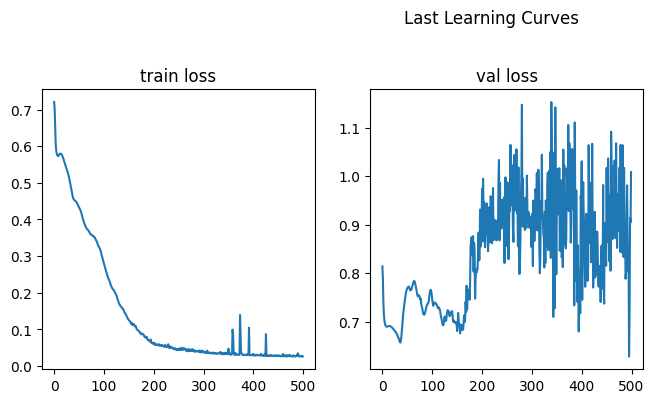

training InteractTransformer_encoder on SAbDab-full
loading preprocessed data from ./data/processed_data_clip1_neg0_usepairTrue.pkl
model parameters:  138368
Epoch 0


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.94it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.00it/s]


Epoch 0: 
 Train Loss	0.7027 
 Val Loss	1.0884

Epoch 1


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.31it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.33it/s]


Epoch 1: 
 Train Loss	0.6760 
 Val Loss	1.1015

Epoch 2


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.36it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 112.04it/s]


Epoch 2: 
 Train Loss	0.6536 
 Val Loss	1.1077

Epoch 3


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.63it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.83it/s]


Epoch 3: 
 Train Loss	0.6364 
 Val Loss	1.1130

Epoch 4


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.43it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 145.72it/s]


Epoch 4: 
 Train Loss	0.6229 
 Val Loss	1.1160

Epoch 5


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.09it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 139.09it/s]


Epoch 5: 
 Train Loss	0.6108 
 Val Loss	1.1212

Epoch 6


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.05it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 110.56it/s]


Epoch 6: 
 Train Loss	0.6003 
 Val Loss	1.1245

Epoch 7


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.41it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 202.92it/s]


Epoch 7: 
 Train Loss	0.5910 
 Val Loss	1.1260

Epoch 8


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.23it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 581.50it/s]


Epoch 8: 
 Train Loss	0.5826 
 Val Loss	1.1263

Epoch 9


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 90.38it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 562.89it/s]


Epoch 9: 
 Train Loss	0.5748 
 Val Loss	1.1261

Epoch 10


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.12it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.44it/s]


Epoch 10: 
 Train Loss	0.5675 
 Val Loss	1.1249

Epoch 11


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.14it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 138.23it/s]


Epoch 11: 
 Train Loss	0.5609 
 Val Loss	1.1228

Epoch 12


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.20it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 484.53it/s]


Epoch 12: 
 Train Loss	0.5549 
 Val Loss	1.1192

Epoch 13


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.67it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 330.56it/s]


Epoch 13: 
 Train Loss	0.5491 
 Val Loss	1.1158

Epoch 14


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.29it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.93it/s]


Epoch 14: 
 Train Loss	0.5439 
 Val Loss	1.1120

Epoch 15


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.64it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.37it/s]


Epoch 15: 
 Train Loss	0.5390 
 Val Loss	1.1082

Epoch 16


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.14it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.87it/s]


Epoch 16: 
 Train Loss	0.5345 
 Val Loss	1.1043

Epoch 17


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.60it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.39it/s]


Epoch 17: 
 Train Loss	0.5303 
 Val Loss	1.1004

Epoch 18


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 90.73it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.99it/s]


Epoch 18: 
 Train Loss	0.5264 
 Val Loss	1.0969

Epoch 19


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.26it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 139.96it/s]


Epoch 19: 
 Train Loss	0.5227 
 Val Loss	1.0935

Epoch 20


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.60it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.99it/s]


Epoch 20: 
 Train Loss	0.5192 
 Val Loss	1.0904

Epoch 21


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 94.23it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 119.86it/s]


Epoch 21: 
 Train Loss	0.5160 
 Val Loss	1.0869

Epoch 22


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 94.57it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 138.84it/s]


Epoch 22: 
 Train Loss	0.5130 
 Val Loss	1.0835

Epoch 23


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.27it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 331.71it/s]


Epoch 23: 
 Train Loss	0.5102 
 Val Loss	1.0800

Epoch 24


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.98it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.98it/s]


Epoch 24: 
 Train Loss	0.5075 
 Val Loss	1.0766

Epoch 25


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.36it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.43it/s]


Epoch 25: 
 Train Loss	0.5049 
 Val Loss	1.0737

Epoch 26


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 94.13it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.51it/s]


Epoch 26: 
 Train Loss	0.5025 
 Val Loss	1.0707

Epoch 27


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.35it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 105.02it/s]


Epoch 27: 
 Train Loss	0.5002 
 Val Loss	1.0678

Epoch 28


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.37it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.19it/s]


Epoch 28: 
 Train Loss	0.4979 
 Val Loss	1.0648

Epoch 29


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.19it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 233.34it/s]


Epoch 29: 
 Train Loss	0.4958 
 Val Loss	1.0618

Epoch 30


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.71it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 526.40it/s]


Epoch 30: 
 Train Loss	0.4938 
 Val Loss	1.0590

Epoch 31


100%|████████████████████████████████████████| 334/334 [00:03<00:00, 109.12it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.18it/s]


Epoch 31: 
 Train Loss	0.4918 
 Val Loss	1.0566

Epoch 32


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.00it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 105.12it/s]


Epoch 32: 
 Train Loss	0.4899 
 Val Loss	1.0544

Epoch 33


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.04it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 251.47it/s]


Epoch 33: 
 Train Loss	0.4881 
 Val Loss	1.0522

Epoch 34


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 90.81it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 136.52it/s]


Epoch 34: 
 Train Loss	0.4862 
 Val Loss	1.0502

Epoch 35


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 94.24it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 194.45it/s]


Epoch 35: 
 Train Loss	0.4846 
 Val Loss	1.0483

Epoch 36


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.64it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 335.34it/s]


Epoch 36: 
 Train Loss	0.4829 
 Val Loss	1.0465

Epoch 37


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.00it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.00it/s]


Epoch 37: 
 Train Loss	0.4814 
 Val Loss	1.0447

Epoch 38


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.83it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 139.38it/s]


Epoch 38: 
 Train Loss	0.4798 
 Val Loss	1.0429

Epoch 39


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.20it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 111.80it/s]


Epoch 39: 
 Train Loss	0.4784 
 Val Loss	1.0412

Epoch 40


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.93it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 196.90it/s]


Epoch 40: 
 Train Loss	0.4770 
 Val Loss	1.0396

Epoch 41


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.36it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.87it/s]


Epoch 41: 
 Train Loss	0.4755 
 Val Loss	1.0381

Epoch 42


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.10it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.72it/s]


Epoch 42: 
 Train Loss	0.4741 
 Val Loss	1.0363

Epoch 43


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.57it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 136.00it/s]


Epoch 43: 
 Train Loss	0.4728 
 Val Loss	1.0346

Epoch 44


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 97.85it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 140.52it/s]


Epoch 44: 
 Train Loss	0.4715 
 Val Loss	1.0331

Epoch 45


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.54it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 123.15it/s]


Epoch 45: 
 Train Loss	0.4703 
 Val Loss	1.0314

Epoch 46


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.23it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 112.02it/s]


Epoch 46: 
 Train Loss	0.4691 
 Val Loss	1.0301

Epoch 47


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.62it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 165.01it/s]


Epoch 47: 
 Train Loss	0.4678 
 Val Loss	1.0286

Epoch 48


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.32it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 180.25it/s]


Epoch 48: 
 Train Loss	0.4666 
 Val Loss	1.0272

Epoch 49


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.97it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.41it/s]


Epoch 49: 
 Train Loss	0.4655 
 Val Loss	1.0260

Epoch 50


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.52it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 121.93it/s]


Epoch 50: 
 Train Loss	0.4644 
 Val Loss	1.0248

Epoch 51


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.51it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 238.54it/s]


Epoch 51: 
 Train Loss	0.4634 
 Val Loss	1.0237

Epoch 52


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.45it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 111.90it/s]


Epoch 52: 
 Train Loss	0.4623 
 Val Loss	1.0225

Epoch 53


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.98it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.87it/s]


Epoch 53: 
 Train Loss	0.4613 
 Val Loss	1.0212

Epoch 54


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 90.96it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 334.59it/s]


Epoch 54: 
 Train Loss	0.4603 
 Val Loss	1.0202

Epoch 55


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.73it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.79it/s]


Epoch 55: 
 Train Loss	0.4593 
 Val Loss	1.0191

Epoch 56


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 94.31it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.81it/s]


Epoch 56: 
 Train Loss	0.4583 
 Val Loss	1.0180

Epoch 57


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 90.53it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 427.39it/s]


Epoch 57: 
 Train Loss	0.4573 
 Val Loss	1.0170

Epoch 58


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.99it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.48it/s]


Epoch 58: 
 Train Loss	0.4564 
 Val Loss	1.0160

Epoch 59


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 94.24it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.89it/s]


Epoch 59: 
 Train Loss	0.4554 
 Val Loss	1.0151

Epoch 60


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 90.89it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.03it/s]


Epoch 60: 
 Train Loss	0.4545 
 Val Loss	1.0141

Epoch 61


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.56it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.98it/s]


Epoch 61: 
 Train Loss	0.4536 
 Val Loss	1.0132

Epoch 62


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 95.31it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.77it/s]


Epoch 62: 
 Train Loss	0.4527 
 Val Loss	1.0122

Epoch 63


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.79it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 105.29it/s]


Epoch 63: 
 Train Loss	0.4518 
 Val Loss	1.0114

Epoch 64


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.43it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 515.08it/s]


Epoch 64: 
 Train Loss	0.4510 
 Val Loss	1.0104

Epoch 65


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.95it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 127.35it/s]


Epoch 65: 
 Train Loss	0.4502 
 Val Loss	1.0096

Epoch 66


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 94.12it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 105.08it/s]


Epoch 66: 
 Train Loss	0.4493 
 Val Loss	1.0088

Epoch 67


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.08it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 105.19it/s]


Epoch 67: 
 Train Loss	0.4485 
 Val Loss	1.0081

Epoch 68


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.61it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.27it/s]


Epoch 68: 
 Train Loss	0.4477 
 Val Loss	1.0072

Epoch 69


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 94.04it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.98it/s]


Epoch 69: 
 Train Loss	0.4469 
 Val Loss	1.0065

Epoch 70


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.67it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.95it/s]


Epoch 70: 
 Train Loss	0.4462 
 Val Loss	1.0057

Epoch 71


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.76it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.78it/s]


Epoch 71: 
 Train Loss	0.4453 
 Val Loss	1.0049

Epoch 72


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.72it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.11it/s]


Epoch 72: 
 Train Loss	0.4446 
 Val Loss	1.0043

Epoch 73


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.10it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 148.19it/s]


Epoch 73: 
 Train Loss	0.4438 
 Val Loss	1.0036

Epoch 74


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.02it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 218.82it/s]


Epoch 74: 
 Train Loss	0.4430 
 Val Loss	1.0030

Epoch 75


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.73it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 110.43it/s]


Epoch 75: 
 Train Loss	0.4423 
 Val Loss	1.0022

Epoch 76


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 90.27it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.27it/s]


Epoch 76: 
 Train Loss	0.4415 
 Val Loss	1.0014

Epoch 77


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.47it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.66it/s]


Epoch 77: 
 Train Loss	0.4408 
 Val Loss	1.0007

Epoch 78


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.21it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 105.22it/s]


Epoch 78: 
 Train Loss	0.4401 
 Val Loss	0.9999

Epoch 79


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.30it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 146.26it/s]


Epoch 79: 
 Train Loss	0.4394 
 Val Loss	0.9993

Epoch 80


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.23it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.88it/s]


Epoch 80: 
 Train Loss	0.4387 
 Val Loss	0.9986

Epoch 81


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 94.41it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.02it/s]


Epoch 81: 
 Train Loss	0.4380 
 Val Loss	0.9978

Epoch 82


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.80it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 143.77it/s]


Epoch 82: 
 Train Loss	0.4373 
 Val Loss	0.9971

Epoch 83


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.94it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 240.38it/s]


Epoch 83: 
 Train Loss	0.4366 
 Val Loss	0.9965

Epoch 84


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.87it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 327.11it/s]


Epoch 84: 
 Train Loss	0.4360 
 Val Loss	0.9958

Epoch 85


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.11it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 119.85it/s]


Epoch 85: 
 Train Loss	0.4353 
 Val Loss	0.9952

Epoch 86


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.09it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.99it/s]


Epoch 86: 
 Train Loss	0.4346 
 Val Loss	0.9945

Epoch 87


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.48it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.48it/s]


Epoch 87: 
 Train Loss	0.4340 
 Val Loss	0.9940

Epoch 88


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.82it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 114.47it/s]


Epoch 88: 
 Train Loss	0.4333 
 Val Loss	0.9933

Epoch 89


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.48it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 105.18it/s]


Epoch 89: 
 Train Loss	0.4326 
 Val Loss	0.9925

Epoch 90


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.29it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.25it/s]


Epoch 90: 
 Train Loss	0.4319 
 Val Loss	0.9918

Epoch 91


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.45it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.92it/s]


Epoch 91: 
 Train Loss	0.4313 
 Val Loss	0.9911

Epoch 92


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.60it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.65it/s]


Epoch 92: 
 Train Loss	0.4306 
 Val Loss	0.9906

Epoch 93


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.06it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.29it/s]


Epoch 93: 
 Train Loss	0.4301 
 Val Loss	0.9900

Epoch 94


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.46it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 146.33it/s]


Epoch 94: 
 Train Loss	0.4294 
 Val Loss	0.9894

Epoch 95


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.74it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.58it/s]


Epoch 95: 
 Train Loss	0.4288 
 Val Loss	0.9887

Epoch 96


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.68it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 235.68it/s]


Epoch 96: 
 Train Loss	0.4282 
 Val Loss	0.9881

Epoch 97


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.92it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 105.27it/s]


Epoch 97: 
 Train Loss	0.4276 
 Val Loss	0.9875

Epoch 98


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.24it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.78it/s]


Epoch 98: 
 Train Loss	0.4271 
 Val Loss	0.9867

Epoch 99


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.78it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.17it/s]


Epoch 99: 
 Train Loss	0.4265 
 Val Loss	0.9860

Epoch 100


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.18it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.98it/s]


Epoch 100: 
 Train Loss	0.4259 
 Val Loss	0.9852

Epoch 101


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 94.88it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 105.12it/s]


Epoch 101: 
 Train Loss	0.4253 
 Val Loss	0.9844

Epoch 102


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 94.86it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 121.74it/s]


Epoch 102: 
 Train Loss	0.4247 
 Val Loss	0.9835

Epoch 103


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.88it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.40it/s]


Epoch 103: 
 Train Loss	0.4241 
 Val Loss	0.9827

Epoch 104


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.17it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.85it/s]


Epoch 104: 
 Train Loss	0.4235 
 Val Loss	0.9820

Epoch 105


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 94.07it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.17it/s]


Epoch 105: 
 Train Loss	0.4230 
 Val Loss	0.9812

Epoch 106


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.73it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 124.34it/s]


Epoch 106: 
 Train Loss	0.4225 
 Val Loss	0.9804

Epoch 107


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.86it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 127.61it/s]


Epoch 107: 
 Train Loss	0.4219 
 Val Loss	0.9795

Epoch 108


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.43it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 130.91it/s]


Epoch 108: 
 Train Loss	0.4214 
 Val Loss	0.9786

Epoch 109


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 94.86it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 138.71it/s]


Epoch 109: 
 Train Loss	0.4208 
 Val Loss	0.9778

Epoch 110


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.69it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 114.91it/s]


Epoch 110: 
 Train Loss	0.4203 
 Val Loss	0.9769

Epoch 111


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.88it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 215.27it/s]


Epoch 111: 
 Train Loss	0.4197 
 Val Loss	0.9760

Epoch 112


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.41it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 204.26it/s]


Epoch 112: 
 Train Loss	0.4192 
 Val Loss	0.9751

Epoch 113


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.33it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.95it/s]


Epoch 113: 
 Train Loss	0.4187 
 Val Loss	0.9744

Epoch 114


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.77it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 107.32it/s]


Epoch 114: 
 Train Loss	0.4182 
 Val Loss	0.9736

Epoch 115


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.55it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.75it/s]


Epoch 115: 
 Train Loss	0.4176 
 Val Loss	0.9728

Epoch 116


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.10it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.98it/s]


Epoch 116: 
 Train Loss	0.4172 
 Val Loss	0.9720

Epoch 117


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.26it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.31it/s]


Epoch 117: 
 Train Loss	0.4166 
 Val Loss	0.9713

Epoch 118


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.77it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 154.01it/s]


Epoch 118: 
 Train Loss	0.4161 
 Val Loss	0.9705

Epoch 119


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 90.82it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 130.60it/s]


Epoch 119: 
 Train Loss	0.4156 
 Val Loss	0.9699

Epoch 120


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.57it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.80it/s]


Epoch 120: 
 Train Loss	0.4151 
 Val Loss	0.9693

Epoch 121


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.30it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.17it/s]


Epoch 121: 
 Train Loss	0.4146 
 Val Loss	0.9684

Epoch 122


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.07it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 142.52it/s]


Epoch 122: 
 Train Loss	0.4141 
 Val Loss	0.9677

Epoch 123


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.38it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 176.81it/s]


Epoch 123: 
 Train Loss	0.4136 
 Val Loss	0.9671

Epoch 124


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 97.76it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 588.49it/s]


Epoch 124: 
 Train Loss	0.4131 
 Val Loss	0.9665

Epoch 125


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.02it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 152.63it/s]


Epoch 125: 
 Train Loss	0.4126 
 Val Loss	0.9658

Epoch 126


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 94.22it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 117.41it/s]


Epoch 126: 
 Train Loss	0.4121 
 Val Loss	0.9653

Epoch 127


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.63it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 112.24it/s]


Epoch 127: 
 Train Loss	0.4116 
 Val Loss	0.9647

Epoch 128


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.81it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 132.54it/s]


Epoch 128: 
 Train Loss	0.4112 
 Val Loss	0.9642

Epoch 129


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.25it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.24it/s]


Epoch 129: 
 Train Loss	0.4107 
 Val Loss	0.9635

Epoch 130


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 94.30it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 204.03it/s]


Epoch 130: 
 Train Loss	0.4102 
 Val Loss	0.9630

Epoch 131


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 90.65it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 264.43it/s]


Epoch 131: 
 Train Loss	0.4098 
 Val Loss	0.9625

Epoch 132


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.58it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 105.11it/s]


Epoch 132: 
 Train Loss	0.4093 
 Val Loss	0.9619

Epoch 133


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 96.31it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.57it/s]


Epoch 133: 
 Train Loss	0.4088 
 Val Loss	0.9614

Epoch 134


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.94it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.94it/s]


Epoch 134: 
 Train Loss	0.4084 
 Val Loss	0.9609

Epoch 135


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.27it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.99it/s]


Epoch 135: 
 Train Loss	0.4080 
 Val Loss	0.9605

Epoch 136


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.78it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.97it/s]


Epoch 136: 
 Train Loss	0.4075 
 Val Loss	0.9599

Epoch 137


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.65it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 108.73it/s]


Epoch 137: 
 Train Loss	0.4071 
 Val Loss	0.9595

Epoch 138


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.91it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 146.40it/s]


Epoch 138: 
 Train Loss	0.4066 
 Val Loss	0.9589

Epoch 139


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.94it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 105.20it/s]


Epoch 139: 
 Train Loss	0.4062 
 Val Loss	0.9586

Epoch 140


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.11it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 145.38it/s]


Epoch 140: 
 Train Loss	0.4058 
 Val Loss	0.9582

Epoch 141


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 90.59it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.65it/s]


Epoch 141: 
 Train Loss	0.4054 
 Val Loss	0.9578

Epoch 142


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.55it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 105.07it/s]


Epoch 142: 
 Train Loss	0.4050 
 Val Loss	0.9574

Epoch 143


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.80it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.15it/s]


Epoch 143: 
 Train Loss	0.4045 
 Val Loss	0.9571

Epoch 144


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 90.20it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 130.24it/s]


Epoch 144: 
 Train Loss	0.4041 
 Val Loss	0.9566

Epoch 145


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.06it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 142.35it/s]


Epoch 145: 
 Train Loss	0.4037 
 Val Loss	0.9563

Epoch 146


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.45it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 300.00it/s]


Epoch 146: 
 Train Loss	0.4033 
 Val Loss	0.9559

Epoch 147


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.09it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.39it/s]


Epoch 147: 
 Train Loss	0.4028 
 Val Loss	0.9555

Epoch 148


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.85it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 122.22it/s]


Epoch 148: 
 Train Loss	0.4024 
 Val Loss	0.9552

Epoch 149


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.19it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.42it/s]


Epoch 149: 
 Train Loss	0.4020 
 Val Loss	0.9549

Epoch 150


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.21it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 121.66it/s]


Epoch 150: 
 Train Loss	0.4017 
 Val Loss	0.9546

Epoch 151


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.11it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 235.90it/s]


Epoch 151: 
 Train Loss	0.4012 
 Val Loss	0.9544

Epoch 152


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 94.00it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 133.57it/s]


Epoch 152: 
 Train Loss	0.4008 
 Val Loss	0.9541

Epoch 153


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.01it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.79it/s]


Epoch 153: 
 Train Loss	0.4004 
 Val Loss	0.9538

Epoch 154


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.19it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 298.73it/s]


Epoch 154: 
 Train Loss	0.4000 
 Val Loss	0.9536

Epoch 155


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.32it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 120.52it/s]


Epoch 155: 
 Train Loss	0.3996 
 Val Loss	0.9533

Epoch 156


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.45it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 141.64it/s]


Epoch 156: 
 Train Loss	0.3992 
 Val Loss	0.9530

Epoch 157


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.66it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 122.72it/s]


Epoch 157: 
 Train Loss	0.3987 
 Val Loss	0.9526

Epoch 158


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.04it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 202.23it/s]


Epoch 158: 
 Train Loss	0.3983 
 Val Loss	0.9522

Epoch 159


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 94.02it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 139.21it/s]


Epoch 159: 
 Train Loss	0.3979 
 Val Loss	0.9519

Epoch 160


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.12it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 146.79it/s]


Epoch 160: 
 Train Loss	0.3975 
 Val Loss	0.9515

Epoch 161


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.43it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 105.20it/s]


Epoch 161: 
 Train Loss	0.3971 
 Val Loss	0.9512

Epoch 162


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.53it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 112.64it/s]


Epoch 162: 
 Train Loss	0.3968 
 Val Loss	0.9510

Epoch 163


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.36it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 143.55it/s]


Epoch 163: 
 Train Loss	0.3964 
 Val Loss	0.9507

Epoch 164


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.41it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 637.03it/s]


Epoch 164: 
 Train Loss	0.3961 
 Val Loss	0.9503

Epoch 165


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 89.97it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 139.99it/s]


Epoch 165: 
 Train Loss	0.3957 
 Val Loss	0.9501

Epoch 166


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.76it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 148.10it/s]


Epoch 166: 
 Train Loss	0.3953 
 Val Loss	0.9500

Epoch 167


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 90.95it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.06it/s]


Epoch 167: 
 Train Loss	0.3949 
 Val Loss	0.9497

Epoch 168


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 94.23it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 125.54it/s]


Epoch 168: 
 Train Loss	0.3946 
 Val Loss	0.9494

Epoch 169


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.58it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 177.30it/s]


Epoch 169: 
 Train Loss	0.3942 
 Val Loss	0.9492

Epoch 170


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.79it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 179.95it/s]


Epoch 170: 
 Train Loss	0.3938 
 Val Loss	0.9489

Epoch 171


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.48it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 138.91it/s]


Epoch 171: 
 Train Loss	0.3935 
 Val Loss	0.9486

Epoch 172


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 89.97it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.83it/s]


Epoch 172: 
 Train Loss	0.3931 
 Val Loss	0.9482

Epoch 173


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.53it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 175.93it/s]


Epoch 173: 
 Train Loss	0.3928 
 Val Loss	0.9479

Epoch 174


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 94.18it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.89it/s]


Epoch 174: 
 Train Loss	0.3924 
 Val Loss	0.9477

Epoch 175


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.91it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 105.19it/s]


Epoch 175: 
 Train Loss	0.3920 
 Val Loss	0.9475

Epoch 176


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.83it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.19it/s]


Epoch 176: 
 Train Loss	0.3917 
 Val Loss	0.9473

Epoch 177


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 94.90it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 136.76it/s]


Epoch 177: 
 Train Loss	0.3913 
 Val Loss	0.9471

Epoch 178


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.25it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 150.71it/s]


Epoch 178: 
 Train Loss	0.3910 
 Val Loss	0.9468

Epoch 179


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.89it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.86it/s]


Epoch 179: 
 Train Loss	0.3906 
 Val Loss	0.9466

Epoch 180


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.71it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 138.34it/s]


Epoch 180: 
 Train Loss	0.3903 
 Val Loss	0.9463

Epoch 181


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.59it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.92it/s]


Epoch 181: 
 Train Loss	0.3899 
 Val Loss	0.9462

Epoch 182


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.62it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 108.48it/s]


Epoch 182: 
 Train Loss	0.3896 
 Val Loss	0.9461

Epoch 183


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.96it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 131.25it/s]


Epoch 183: 
 Train Loss	0.3892 
 Val Loss	0.9459

Epoch 184


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.74it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 105.00it/s]


Epoch 184: 
 Train Loss	0.3889 
 Val Loss	0.9456

Epoch 185


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.11it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.57it/s]


Epoch 185: 
 Train Loss	0.3885 
 Val Loss	0.9453

Epoch 186


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 94.73it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.79it/s]


Epoch 186: 
 Train Loss	0.3882 
 Val Loss	0.9450

Epoch 187


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 94.05it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.96it/s]


Epoch 187: 
 Train Loss	0.3879 
 Val Loss	0.9447

Epoch 188


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.70it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.38it/s]


Epoch 188: 
 Train Loss	0.3875 
 Val Loss	0.9443

Epoch 189


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 89.61it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.45it/s]


Epoch 189: 
 Train Loss	0.3872 
 Val Loss	0.9440

Epoch 190


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.70it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 106.61it/s]


Epoch 190: 
 Train Loss	0.3868 
 Val Loss	0.9438

Epoch 191


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.84it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.84it/s]


Epoch 191: 
 Train Loss	0.3865 
 Val Loss	0.9436

Epoch 192


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.33it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 115.93it/s]


Epoch 192: 
 Train Loss	0.3861 
 Val Loss	0.9434

Epoch 193


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.38it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.72it/s]


Epoch 193: 
 Train Loss	0.3858 
 Val Loss	0.9432

Epoch 194


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.45it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 119.98it/s]


Epoch 194: 
 Train Loss	0.3855 
 Val Loss	0.9428

Epoch 195


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.70it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.18it/s]


Epoch 195: 
 Train Loss	0.3852 
 Val Loss	0.9426

Epoch 196


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.86it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.19it/s]


Epoch 196: 
 Train Loss	0.3848 
 Val Loss	0.9422

Epoch 197


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.48it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 151.43it/s]


Epoch 197: 
 Train Loss	0.3845 
 Val Loss	0.9419

Epoch 198


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.76it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.36it/s]


Epoch 198: 
 Train Loss	0.3842 
 Val Loss	0.9416

Epoch 199


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.57it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.05it/s]


Epoch 199: 
 Train Loss	0.3839 
 Val Loss	0.9414

Epoch 200


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 90.98it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.05it/s]


Epoch 200: 
 Train Loss	0.3835 
 Val Loss	0.9409

Epoch 201


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.36it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.23it/s]


Epoch 201: 
 Train Loss	0.3832 
 Val Loss	0.9406

Epoch 202


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.70it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 140.29it/s]


Epoch 202: 
 Train Loss	0.3829 
 Val Loss	0.9403

Epoch 203


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 97.33it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 105.07it/s]


Epoch 203: 
 Train Loss	0.3825 
 Val Loss	0.9401

Epoch 204


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 94.30it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.01it/s]


Epoch 204: 
 Train Loss	0.3822 
 Val Loss	0.9398

Epoch 205


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.14it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.20it/s]


Epoch 205: 
 Train Loss	0.3819 
 Val Loss	0.9396

Epoch 206


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.13it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.89it/s]


Epoch 206: 
 Train Loss	0.3816 
 Val Loss	0.9393

Epoch 207


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.24it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 147.05it/s]


Epoch 207: 
 Train Loss	0.3812 
 Val Loss	0.9390

Epoch 208


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.21it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 128.62it/s]


Epoch 208: 
 Train Loss	0.3809 
 Val Loss	0.9386

Epoch 209


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.26it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.35it/s]


Epoch 209: 
 Train Loss	0.3806 
 Val Loss	0.9383

Epoch 210


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 94.80it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 105.30it/s]


Epoch 210: 
 Train Loss	0.3803 
 Val Loss	0.9379

Epoch 211


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.45it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.02it/s]


Epoch 211: 
 Train Loss	0.3800 
 Val Loss	0.9375

Epoch 212


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.93it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 105.06it/s]


Epoch 212: 
 Train Loss	0.3797 
 Val Loss	0.9372

Epoch 213


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.82it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.26it/s]


Epoch 213: 
 Train Loss	0.3794 
 Val Loss	0.9368

Epoch 214


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.37it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.83it/s]


Epoch 214: 
 Train Loss	0.3791 
 Val Loss	0.9364

Epoch 215


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.64it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.80it/s]


Epoch 215: 
 Train Loss	0.3788 
 Val Loss	0.9360

Epoch 216


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.03it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 145.53it/s]


Epoch 216: 
 Train Loss	0.3785 
 Val Loss	0.9355

Epoch 217


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.08it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.09it/s]


Epoch 217: 
 Train Loss	0.3782 
 Val Loss	0.9351

Epoch 218


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.45it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.86it/s]


Epoch 218: 
 Train Loss	0.3779 
 Val Loss	0.9345

Epoch 219


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.42it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 126.09it/s]


Epoch 219: 
 Train Loss	0.3776 
 Val Loss	0.9341

Epoch 220


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 94.06it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.34it/s]


Epoch 220: 
 Train Loss	0.3774 
 Val Loss	0.9336

Epoch 221


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.65it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.18it/s]


Epoch 221: 
 Train Loss	0.3770 
 Val Loss	0.9332

Epoch 222


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.80it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 141.36it/s]


Epoch 222: 
 Train Loss	0.3768 
 Val Loss	0.9328

Epoch 223


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.94it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 116.59it/s]


Epoch 223: 
 Train Loss	0.3765 
 Val Loss	0.9324

Epoch 224


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 90.29it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 605.70it/s]


Epoch 224: 
 Train Loss	0.3762 
 Val Loss	0.9320

Epoch 225


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.66it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 156.01it/s]


Epoch 225: 
 Train Loss	0.3759 
 Val Loss	0.9315

Epoch 226


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.35it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 117.14it/s]


Epoch 226: 
 Train Loss	0.3756 
 Val Loss	0.9311

Epoch 227


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 90.97it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 125.05it/s]


Epoch 227: 
 Train Loss	0.3753 
 Val Loss	0.9306

Epoch 228


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.58it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 141.57it/s]


Epoch 228: 
 Train Loss	0.3751 
 Val Loss	0.9302

Epoch 229


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.70it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 141.35it/s]


Epoch 229: 
 Train Loss	0.3748 
 Val Loss	0.9298

Epoch 230


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.95it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 215.29it/s]


Epoch 230: 
 Train Loss	0.3745 
 Val Loss	0.9293

Epoch 231


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 90.57it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 145.52it/s]


Epoch 231: 
 Train Loss	0.3742 
 Val Loss	0.9289

Epoch 232


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 90.67it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.90it/s]


Epoch 232: 
 Train Loss	0.3739 
 Val Loss	0.9285

Epoch 233


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.02it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 105.07it/s]


Epoch 233: 
 Train Loss	0.3737 
 Val Loss	0.9281

Epoch 234


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 89.98it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.69it/s]


Epoch 234: 
 Train Loss	0.3734 
 Val Loss	0.9278

Epoch 235


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.00it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 105.42it/s]


Epoch 235: 
 Train Loss	0.3731 
 Val Loss	0.9274

Epoch 236


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 89.46it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.17it/s]


Epoch 236: 
 Train Loss	0.3728 
 Val Loss	0.9270

Epoch 237


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.23it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.13it/s]


Epoch 237: 
 Train Loss	0.3726 
 Val Loss	0.9266

Epoch 238


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.05it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.94it/s]


Epoch 238: 
 Train Loss	0.3723 
 Val Loss	0.9262

Epoch 239


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.34it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 240.79it/s]


Epoch 239: 
 Train Loss	0.3720 
 Val Loss	0.9258

Epoch 240


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.47it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.67it/s]


Epoch 240: 
 Train Loss	0.3718 
 Val Loss	0.9254

Epoch 241


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.09it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 240.34it/s]


Epoch 241: 
 Train Loss	0.3715 
 Val Loss	0.9251

Epoch 242


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.14it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.97it/s]


Epoch 242: 
 Train Loss	0.3712 
 Val Loss	0.9246

Epoch 243


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.59it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 118.49it/s]


Epoch 243: 
 Train Loss	0.3709 
 Val Loss	0.9243

Epoch 244


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.50it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.49it/s]


Epoch 244: 
 Train Loss	0.3707 
 Val Loss	0.9239

Epoch 245


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.78it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.93it/s]


Epoch 245: 
 Train Loss	0.3704 
 Val Loss	0.9235

Epoch 246


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 94.29it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.33it/s]


Epoch 246: 
 Train Loss	0.3701 
 Val Loss	0.9231

Epoch 247


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.79it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 135.66it/s]


Epoch 247: 
 Train Loss	0.3699 
 Val Loss	0.9228

Epoch 248


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.95it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 124.34it/s]


Epoch 248: 
 Train Loss	0.3696 
 Val Loss	0.9224

Epoch 249


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.68it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 135.75it/s]


Epoch 249: 
 Train Loss	0.3694 
 Val Loss	0.9220

Epoch 250


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.88it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 129.08it/s]


Epoch 250: 
 Train Loss	0.3691 
 Val Loss	0.9217

Epoch 251


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 94.02it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.97it/s]


Epoch 251: 
 Train Loss	0.3688 
 Val Loss	0.9214

Epoch 252


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 94.12it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 108.80it/s]


Epoch 252: 
 Train Loss	0.3686 
 Val Loss	0.9210

Epoch 253


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.26it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.75it/s]


Epoch 253: 
 Train Loss	0.3683 
 Val Loss	0.9207

Epoch 254


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.41it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.80it/s]


Epoch 254: 
 Train Loss	0.3681 
 Val Loss	0.9204

Epoch 255


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 94.51it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 375.02it/s]


Epoch 255: 
 Train Loss	0.3678 
 Val Loss	0.9202

Epoch 256


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 90.65it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.39it/s]


Epoch 256: 
 Train Loss	0.3676 
 Val Loss	0.9198

Epoch 257


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.25it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.72it/s]


Epoch 257: 
 Train Loss	0.3673 
 Val Loss	0.9196

Epoch 258


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.65it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 106.19it/s]


Epoch 258: 
 Train Loss	0.3671 
 Val Loss	0.9192

Epoch 259


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.16it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 139.37it/s]


Epoch 259: 
 Train Loss	0.3668 
 Val Loss	0.9189

Epoch 260


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.70it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 189.06it/s]


Epoch 260: 
 Train Loss	0.3666 
 Val Loss	0.9185

Epoch 261


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.07it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 111.83it/s]


Epoch 261: 
 Train Loss	0.3663 
 Val Loss	0.9182

Epoch 262


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.45it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.25it/s]


Epoch 262: 
 Train Loss	0.3661 
 Val Loss	0.9179

Epoch 263


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.23it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 240.16it/s]


Epoch 263: 
 Train Loss	0.3658 
 Val Loss	0.9176

Epoch 264


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 95.34it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.87it/s]


Epoch 264: 
 Train Loss	0.3656 
 Val Loss	0.9173

Epoch 265


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 90.78it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 262.88it/s]


Epoch 265: 
 Train Loss	0.3654 
 Val Loss	0.9170

Epoch 266


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.25it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 149.85it/s]


Epoch 266: 
 Train Loss	0.3651 
 Val Loss	0.9168

Epoch 267


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.24it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 129.57it/s]


Epoch 267: 
 Train Loss	0.3649 
 Val Loss	0.9164

Epoch 268


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.94it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 119.43it/s]


Epoch 268: 
 Train Loss	0.3646 
 Val Loss	0.9162

Epoch 269


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.89it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 139.05it/s]


Epoch 269: 
 Train Loss	0.3644 
 Val Loss	0.9158

Epoch 270


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 90.96it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.86it/s]


Epoch 270: 
 Train Loss	0.3642 
 Val Loss	0.9155

Epoch 271


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.43it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.94it/s]


Epoch 271: 
 Train Loss	0.3639 
 Val Loss	0.9153

Epoch 272


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.38it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 683.42it/s]


Epoch 272: 
 Train Loss	0.3637 
 Val Loss	0.9149

Epoch 273


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.63it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 119.63it/s]


Epoch 273: 
 Train Loss	0.3635 
 Val Loss	0.9145

Epoch 274


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.60it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 141.99it/s]


Epoch 274: 
 Train Loss	0.3632 
 Val Loss	0.9141

Epoch 275


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.14it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 145.41it/s]


Epoch 275: 
 Train Loss	0.3630 
 Val Loss	0.9138

Epoch 276


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.82it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.03it/s]


Epoch 276: 
 Train Loss	0.3628 
 Val Loss	0.9135

Epoch 277


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.36it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 119.87it/s]


Epoch 277: 
 Train Loss	0.3625 
 Val Loss	0.9132

Epoch 278


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.58it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 108.65it/s]


Epoch 278: 
 Train Loss	0.3623 
 Val Loss	0.9130

Epoch 279


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.86it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.19it/s]


Epoch 279: 
 Train Loss	0.3621 
 Val Loss	0.9126

Epoch 280


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.15it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 137.39it/s]


Epoch 280: 
 Train Loss	0.3619 
 Val Loss	0.9124

Epoch 281


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.11it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 216.63it/s]


Epoch 281: 
 Train Loss	0.3616 
 Val Loss	0.9121

Epoch 282


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 96.14it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.75it/s]


Epoch 282: 
 Train Loss	0.3614 
 Val Loss	0.9119

Epoch 283


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.55it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.76it/s]


Epoch 283: 
 Train Loss	0.3612 
 Val Loss	0.9115

Epoch 284


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 90.38it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 175.45it/s]


Epoch 284: 
 Train Loss	0.3610 
 Val Loss	0.9112

Epoch 285


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.24it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.75it/s]


Epoch 285: 
 Train Loss	0.3607 
 Val Loss	0.9109

Epoch 286


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.53it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 105.18it/s]


Epoch 286: 
 Train Loss	0.3605 
 Val Loss	0.9106

Epoch 287


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.71it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 121.76it/s]


Epoch 287: 
 Train Loss	0.3603 
 Val Loss	0.9103

Epoch 288


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.93it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.99it/s]


Epoch 288: 
 Train Loss	0.3600 
 Val Loss	0.9100

Epoch 289


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.04it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 115.16it/s]


Epoch 289: 
 Train Loss	0.3598 
 Val Loss	0.9096

Epoch 290


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.44it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.82it/s]


Epoch 290: 
 Train Loss	0.3596 
 Val Loss	0.9093

Epoch 291


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.05it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 105.17it/s]


Epoch 291: 
 Train Loss	0.3594 
 Val Loss	0.9090

Epoch 292


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.59it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 127.41it/s]


Epoch 292: 
 Train Loss	0.3592 
 Val Loss	0.9086

Epoch 293


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.38it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 114.07it/s]


Epoch 293: 
 Train Loss	0.3590 
 Val Loss	0.9081

Epoch 294


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 94.25it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 113.96it/s]


Epoch 294: 
 Train Loss	0.3587 
 Val Loss	0.9078

Epoch 295


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.64it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.38it/s]


Epoch 295: 
 Train Loss	0.3585 
 Val Loss	0.9074

Epoch 296


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.27it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 109.02it/s]


Epoch 296: 
 Train Loss	0.3583 
 Val Loss	0.9071

Epoch 297


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.40it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 193.27it/s]


Epoch 297: 
 Train Loss	0.3580 
 Val Loss	0.9067

Epoch 298


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.15it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.04it/s]


Epoch 298: 
 Train Loss	0.3578 
 Val Loss	0.9064

Epoch 299


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.13it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.14it/s]


Epoch 299: 
 Train Loss	0.3576 
 Val Loss	0.9060

Epoch 300


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.70it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 105.20it/s]


Epoch 300: 
 Train Loss	0.3574 
 Val Loss	0.9055

Epoch 301


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.25it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.62it/s]


Epoch 301: 
 Train Loss	0.3572 
 Val Loss	0.9051

Epoch 302


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 94.70it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.92it/s]


Epoch 302: 
 Train Loss	0.3570 
 Val Loss	0.9048

Epoch 303


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.18it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.36it/s]


Epoch 303: 
 Train Loss	0.3568 
 Val Loss	0.9045

Epoch 304


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 90.94it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.97it/s]


Epoch 304: 
 Train Loss	0.3566 
 Val Loss	0.9041

Epoch 305


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.27it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 124.99it/s]


Epoch 305: 
 Train Loss	0.3563 
 Val Loss	0.9037

Epoch 306


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.22it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 108.86it/s]


Epoch 306: 
 Train Loss	0.3561 
 Val Loss	0.9032

Epoch 307


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.72it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 124.19it/s]


Epoch 307: 
 Train Loss	0.3559 
 Val Loss	0.9028

Epoch 308


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.74it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 129.58it/s]


Epoch 308: 
 Train Loss	0.3557 
 Val Loss	0.9027

Epoch 309


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.50it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 136.69it/s]


Epoch 309: 
 Train Loss	0.3555 
 Val Loss	0.9023

Epoch 310


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.62it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 137.53it/s]


Epoch 310: 
 Train Loss	0.3553 
 Val Loss	0.9020

Epoch 311


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.33it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 123.10it/s]


Epoch 311: 
 Train Loss	0.3551 
 Val Loss	0.9017

Epoch 312


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 94.00it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.61it/s]


Epoch 312: 
 Train Loss	0.3549 
 Val Loss	0.9015

Epoch 313


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.71it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.92it/s]


Epoch 313: 
 Train Loss	0.3546 
 Val Loss	0.9012

Epoch 314


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.51it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 114.86it/s]


Epoch 314: 
 Train Loss	0.3544 
 Val Loss	0.9009

Epoch 315


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.90it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 120.69it/s]


Epoch 315: 
 Train Loss	0.3542 
 Val Loss	0.9007

Epoch 316


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.80it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.28it/s]


Epoch 316: 
 Train Loss	0.3540 
 Val Loss	0.9004

Epoch 317


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.56it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 156.62it/s]


Epoch 317: 
 Train Loss	0.3538 
 Val Loss	0.9002

Epoch 318


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.63it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 127.55it/s]


Epoch 318: 
 Train Loss	0.3536 
 Val Loss	0.9000

Epoch 319


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.31it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.93it/s]


Epoch 319: 
 Train Loss	0.3534 
 Val Loss	0.8998

Epoch 320


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.14it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 114.74it/s]


Epoch 320: 
 Train Loss	0.3532 
 Val Loss	0.8996

Epoch 321


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 94.22it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 136.25it/s]


Epoch 321: 
 Train Loss	0.3531 
 Val Loss	0.8993

Epoch 322


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.67it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 134.36it/s]


Epoch 322: 
 Train Loss	0.3529 
 Val Loss	0.8991

Epoch 323


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.91it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.02it/s]


Epoch 323: 
 Train Loss	0.3527 
 Val Loss	0.8988

Epoch 324


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.58it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.48it/s]


Epoch 324: 
 Train Loss	0.3525 
 Val Loss	0.8984

Epoch 325


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.00it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.94it/s]


Epoch 325: 
 Train Loss	0.3523 
 Val Loss	0.8982

Epoch 326


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.14it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.72it/s]


Epoch 326: 
 Train Loss	0.3521 
 Val Loss	0.8980

Epoch 327


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.65it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 137.43it/s]


Epoch 327: 
 Train Loss	0.3519 
 Val Loss	0.8979

Epoch 328


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.35it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.95it/s]


Epoch 328: 
 Train Loss	0.3517 
 Val Loss	0.8977

Epoch 329


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.03it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 109.47it/s]


Epoch 329: 
 Train Loss	0.3515 
 Val Loss	0.8974

Epoch 330


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.12it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.52it/s]


Epoch 330: 
 Train Loss	0.3513 
 Val Loss	0.8971

Epoch 331


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.45it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 139.48it/s]


Epoch 331: 
 Train Loss	0.3511 
 Val Loss	0.8969

Epoch 332


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.14it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 123.52it/s]


Epoch 332: 
 Train Loss	0.3509 
 Val Loss	0.8967

Epoch 333


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.80it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.74it/s]


Epoch 333: 
 Train Loss	0.3507 
 Val Loss	0.8965

Epoch 334


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.92it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.77it/s]


Epoch 334: 
 Train Loss	0.3505 
 Val Loss	0.8963

Epoch 335


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 90.82it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 110.85it/s]


Epoch 335: 
 Train Loss	0.3503 
 Val Loss	0.8962

Epoch 336


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.41it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.81it/s]


Epoch 336: 
 Train Loss	0.3502 
 Val Loss	0.8959

Epoch 337


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 89.91it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 120.87it/s]


Epoch 337: 
 Train Loss	0.3500 
 Val Loss	0.8958

Epoch 338


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.75it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 140.88it/s]


Epoch 338: 
 Train Loss	0.3498 
 Val Loss	0.8955

Epoch 339


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 94.89it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.80it/s]


Epoch 339: 
 Train Loss	0.3496 
 Val Loss	0.8953

Epoch 340


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.77it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 105.01it/s]


Epoch 340: 
 Train Loss	0.3494 
 Val Loss	0.8951

Epoch 341


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.21it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 216.76it/s]


Epoch 341: 
 Train Loss	0.3493 
 Val Loss	0.8949

Epoch 342


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.55it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 142.49it/s]


Epoch 342: 
 Train Loss	0.3491 
 Val Loss	0.8947

Epoch 343


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.11it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 155.79it/s]


Epoch 343: 
 Train Loss	0.3489 
 Val Loss	0.8944

Epoch 344


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.62it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 207.61it/s]


Epoch 344: 
 Train Loss	0.3487 
 Val Loss	0.8942

Epoch 345


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 90.77it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 107.28it/s]


Epoch 345: 
 Train Loss	0.3485 
 Val Loss	0.8939

Epoch 346


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.82it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 139.77it/s]


Epoch 346: 
 Train Loss	0.3483 
 Val Loss	0.8937

Epoch 347


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.33it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 123.96it/s]


Epoch 347: 
 Train Loss	0.3481 
 Val Loss	0.8935

Epoch 348


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.35it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.94it/s]


Epoch 348: 
 Train Loss	0.3480 
 Val Loss	0.8933

Epoch 349


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.81it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.70it/s]


Epoch 349: 
 Train Loss	0.3478 
 Val Loss	0.8931

Epoch 350


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 90.89it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.16it/s]


Epoch 350: 
 Train Loss	0.3476 
 Val Loss	0.8930

Epoch 351


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.87it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.10it/s]


Epoch 351: 
 Train Loss	0.3474 
 Val Loss	0.8929

Epoch 352


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.59it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 108.50it/s]


Epoch 352: 
 Train Loss	0.3472 
 Val Loss	0.8927

Epoch 353


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.71it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 141.83it/s]


Epoch 353: 
 Train Loss	0.3470 
 Val Loss	0.8925

Epoch 354


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.38it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 105.07it/s]


Epoch 354: 
 Train Loss	0.3469 
 Val Loss	0.8923

Epoch 355


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.74it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.95it/s]


Epoch 355: 
 Train Loss	0.3467 
 Val Loss	0.8921

Epoch 356


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.10it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 140.49it/s]


Epoch 356: 
 Train Loss	0.3465 
 Val Loss	0.8919

Epoch 357


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.08it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 135.83it/s]


Epoch 357: 
 Train Loss	0.3464 
 Val Loss	0.8918

Epoch 358


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.46it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 105.03it/s]


Epoch 358: 
 Train Loss	0.3462 
 Val Loss	0.8915

Epoch 359


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.09it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 121.65it/s]


Epoch 359: 
 Train Loss	0.3460 
 Val Loss	0.8913

Epoch 360


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.68it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.93it/s]


Epoch 360: 
 Train Loss	0.3458 
 Val Loss	0.8910

Epoch 361


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.22it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.91it/s]


Epoch 361: 
 Train Loss	0.3457 
 Val Loss	0.8908

Epoch 362


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.15it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 120.50it/s]


Epoch 362: 
 Train Loss	0.3455 
 Val Loss	0.8906

Epoch 363


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.90it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 136.04it/s]


Epoch 363: 
 Train Loss	0.3453 
 Val Loss	0.8905

Epoch 364


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.67it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.15it/s]


Epoch 364: 
 Train Loss	0.3451 
 Val Loss	0.8903

Epoch 365


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.43it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.97it/s]


Epoch 365: 
 Train Loss	0.3449 
 Val Loss	0.8901

Epoch 366


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.70it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 117.99it/s]


Epoch 366: 
 Train Loss	0.3448 
 Val Loss	0.8899

Epoch 367


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.78it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.91it/s]


Epoch 367: 
 Train Loss	0.3446 
 Val Loss	0.8898

Epoch 368


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.48it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 108.92it/s]


Epoch 368: 
 Train Loss	0.3444 
 Val Loss	0.8896

Epoch 369


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 90.61it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 105.24it/s]


Epoch 369: 
 Train Loss	0.3442 
 Val Loss	0.8896

Epoch 370


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.64it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 126.42it/s]


Epoch 370: 
 Train Loss	0.3441 
 Val Loss	0.8894

Epoch 371


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.22it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 159.90it/s]


Epoch 371: 
 Train Loss	0.3439 
 Val Loss	0.8892

Epoch 372


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 90.34it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 299.36it/s]


Epoch 372: 
 Train Loss	0.3437 
 Val Loss	0.8891

Epoch 373


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.47it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.36it/s]


Epoch 373: 
 Train Loss	0.3435 
 Val Loss	0.8891

Epoch 374


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.37it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 203.38it/s]


Epoch 374: 
 Train Loss	0.3434 
 Val Loss	0.8889

Epoch 375


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.72it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 148.47it/s]


Epoch 375: 
 Train Loss	0.3432 
 Val Loss	0.8886

Epoch 376


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.38it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 120.28it/s]


Epoch 376: 
 Train Loss	0.3430 
 Val Loss	0.8885

Epoch 377


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 89.35it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.72it/s]


Epoch 377: 
 Train Loss	0.3428 
 Val Loss	0.8884

Epoch 378


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 90.59it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.04it/s]


Epoch 378: 
 Train Loss	0.3427 
 Val Loss	0.8882

Epoch 379


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.55it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.48it/s]


Epoch 379: 
 Train Loss	0.3425 
 Val Loss	0.8879

Epoch 380


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.46it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 462.55it/s]


Epoch 380: 
 Train Loss	0.3423 
 Val Loss	0.8877

Epoch 381


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.21it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.48it/s]


Epoch 381: 
 Train Loss	0.3422 
 Val Loss	0.8874

Epoch 382


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 90.97it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 105.28it/s]


Epoch 382: 
 Train Loss	0.3420 
 Val Loss	0.8872

Epoch 383


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.22it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.94it/s]


Epoch 383: 
 Train Loss	0.3418 
 Val Loss	0.8870

Epoch 384


100%|████████████████████████████████████████| 334/334 [00:03<00:00, 101.94it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.00it/s]


Epoch 384: 
 Train Loss	0.3417 
 Val Loss	0.8869

Epoch 385


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 83.74it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.67it/s]


Epoch 385: 
 Train Loss	0.3415 
 Val Loss	0.8868

Epoch 386


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.50it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.84it/s]


Epoch 386: 
 Train Loss	0.3413 
 Val Loss	0.8866

Epoch 387


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.76it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.80it/s]


Epoch 387: 
 Train Loss	0.3412 
 Val Loss	0.8865

Epoch 388


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 83.30it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.73it/s]


Epoch 388: 
 Train Loss	0.3410 
 Val Loss	0.8866

Epoch 389


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.10it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.03it/s]


Epoch 389: 
 Train Loss	0.3408 
 Val Loss	0.8865

Epoch 390


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.36it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.27it/s]


Epoch 390: 
 Train Loss	0.3407 
 Val Loss	0.8864

Epoch 391


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.54it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.87it/s]


Epoch 391: 
 Train Loss	0.3405 
 Val Loss	0.8862

Epoch 392


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.40it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 120.71it/s]


Epoch 392: 
 Train Loss	0.3403 
 Val Loss	0.8861

Epoch 393


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.14it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 116.32it/s]


Epoch 393: 
 Train Loss	0.3402 
 Val Loss	0.8861

Epoch 394


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.60it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.79it/s]


Epoch 394: 
 Train Loss	0.3400 
 Val Loss	0.8859

Epoch 395


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.33it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.67it/s]


Epoch 395: 
 Train Loss	0.3398 
 Val Loss	0.8857

Epoch 396


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.95it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.12it/s]


Epoch 396: 
 Train Loss	0.3397 
 Val Loss	0.8855

Epoch 397


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 83.27it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.96it/s]


Epoch 397: 
 Train Loss	0.3395 
 Val Loss	0.8852

Epoch 398


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.16it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.79it/s]


Epoch 398: 
 Train Loss	0.3394 
 Val Loss	0.8850

Epoch 399


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.22it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.66it/s]


Epoch 399: 
 Train Loss	0.3392 
 Val Loss	0.8849

Epoch 400


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 83.57it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.01it/s]


Epoch 400: 
 Train Loss	0.3390 
 Val Loss	0.8847

Epoch 401


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.20it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.81it/s]


Epoch 401: 
 Train Loss	0.3389 
 Val Loss	0.8845

Epoch 402


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 85.09it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 128.98it/s]


Epoch 402: 
 Train Loss	0.3387 
 Val Loss	0.8843

Epoch 403


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 85.42it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 123.23it/s]


Epoch 403: 
 Train Loss	0.3385 
 Val Loss	0.8842

Epoch 404


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.96it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 120.22it/s]


Epoch 404: 
 Train Loss	0.3384 
 Val Loss	0.8842

Epoch 405


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 85.29it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 124.58it/s]


Epoch 405: 
 Train Loss	0.3382 
 Val Loss	0.8841

Epoch 406


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 83.70it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.40it/s]


Epoch 406: 
 Train Loss	0.3381 
 Val Loss	0.8840

Epoch 407


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.45it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.09it/s]


Epoch 407: 
 Train Loss	0.3379 
 Val Loss	0.8838

Epoch 408


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 85.65it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.96it/s]


Epoch 408: 
 Train Loss	0.3378 
 Val Loss	0.8837

Epoch 409


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 85.30it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.73it/s]


Epoch 409: 
 Train Loss	0.3376 
 Val Loss	0.8835

Epoch 410


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.01it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.00it/s]


Epoch 410: 
 Train Loss	0.3374 
 Val Loss	0.8833

Epoch 411


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 85.31it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.54it/s]


Epoch 411: 
 Train Loss	0.3373 
 Val Loss	0.8831

Epoch 412


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 85.28it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.97it/s]


Epoch 412: 
 Train Loss	0.3371 
 Val Loss	0.8829

Epoch 413


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 85.01it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.04it/s]


Epoch 413: 
 Train Loss	0.3370 
 Val Loss	0.8828

Epoch 414


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 85.07it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.74it/s]


Epoch 414: 
 Train Loss	0.3368 
 Val Loss	0.8826

Epoch 415


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 85.26it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.30it/s]


Epoch 415: 
 Train Loss	0.3366 
 Val Loss	0.8826

Epoch 416


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 85.19it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.96it/s]


Epoch 416: 
 Train Loss	0.3365 
 Val Loss	0.8823

Epoch 417


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 85.07it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.87it/s]


Epoch 417: 
 Train Loss	0.3363 
 Val Loss	0.8822

Epoch 418


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.06it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.10it/s]


Epoch 418: 
 Train Loss	0.3362 
 Val Loss	0.8820

Epoch 419


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 85.15it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.58it/s]


Epoch 419: 
 Train Loss	0.3360 
 Val Loss	0.8818

Epoch 420


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.47it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 127.47it/s]


Epoch 420: 
 Train Loss	0.3359 
 Val Loss	0.8816

Epoch 421


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 83.64it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 127.57it/s]


Epoch 421: 
 Train Loss	0.3357 
 Val Loss	0.8816

Epoch 422


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.08it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.10it/s]


Epoch 422: 
 Train Loss	0.3355 
 Val Loss	0.8814

Epoch 423


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 85.30it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.01it/s]


Epoch 423: 
 Train Loss	0.3354 
 Val Loss	0.8813

Epoch 424


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.38it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.83it/s]


Epoch 424: 
 Train Loss	0.3352 
 Val Loss	0.8810

Epoch 425


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 83.41it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.89it/s]


Epoch 425: 
 Train Loss	0.3351 
 Val Loss	0.8808

Epoch 426


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.50it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.85it/s]


Epoch 426: 
 Train Loss	0.3349 
 Val Loss	0.8806

Epoch 427


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.72it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.81it/s]


Epoch 427: 
 Train Loss	0.3348 
 Val Loss	0.8805

Epoch 428


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 85.08it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.45it/s]


Epoch 428: 
 Train Loss	0.3346 
 Val Loss	0.8803

Epoch 429


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 85.21it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.03it/s]


Epoch 429: 
 Train Loss	0.3345 
 Val Loss	0.8803

Epoch 430


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.85it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.74it/s]


Epoch 430: 
 Train Loss	0.3343 
 Val Loss	0.8802

Epoch 431


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 85.07it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.06it/s]


Epoch 431: 
 Train Loss	0.3341 
 Val Loss	0.8801

Epoch 432


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 85.13it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.90it/s]


Epoch 432: 
 Train Loss	0.3340 
 Val Loss	0.8799

Epoch 433


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 85.54it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.03it/s]


Epoch 433: 
 Train Loss	0.3338 
 Val Loss	0.8797

Epoch 434


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 85.89it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.01it/s]


Epoch 434: 
 Train Loss	0.3337 
 Val Loss	0.8796

Epoch 435


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 85.42it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 110.30it/s]


Epoch 435: 
 Train Loss	0.3335 
 Val Loss	0.8793

Epoch 436


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.57it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 122.24it/s]


Epoch 436: 
 Train Loss	0.3334 
 Val Loss	0.8791

Epoch 437


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.11it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 122.85it/s]


Epoch 437: 
 Train Loss	0.3333 
 Val Loss	0.8791

Epoch 438


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 85.35it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 119.09it/s]


Epoch 438: 
 Train Loss	0.3331 
 Val Loss	0.8790

Epoch 439


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 85.65it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 114.92it/s]


Epoch 439: 
 Train Loss	0.3330 
 Val Loss	0.8789

Epoch 440


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 85.70it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 114.13it/s]


Epoch 440: 
 Train Loss	0.3328 
 Val Loss	0.8787

Epoch 441


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 85.08it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.18it/s]


Epoch 441: 
 Train Loss	0.3327 
 Val Loss	0.8785

Epoch 442


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 85.35it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.48it/s]


Epoch 442: 
 Train Loss	0.3325 
 Val Loss	0.8784

Epoch 443


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 85.00it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.91it/s]


Epoch 443: 
 Train Loss	0.3324 
 Val Loss	0.8782

Epoch 444


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 85.13it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.71it/s]


Epoch 444: 
 Train Loss	0.3322 
 Val Loss	0.8781

Epoch 445


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 85.01it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.36it/s]


Epoch 445: 
 Train Loss	0.3321 
 Val Loss	0.8779

Epoch 446


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.74it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.99it/s]


Epoch 446: 
 Train Loss	0.3319 
 Val Loss	0.8776

Epoch 447


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.89it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.80it/s]


Epoch 447: 
 Train Loss	0.3318 
 Val Loss	0.8774

Epoch 448


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 83.58it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.88it/s]


Epoch 448: 
 Train Loss	0.3316 
 Val Loss	0.8772

Epoch 449


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.19it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.66it/s]


Epoch 449: 
 Train Loss	0.3315 
 Val Loss	0.8770

Epoch 450


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 85.29it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.14it/s]


Epoch 450: 
 Train Loss	0.3313 
 Val Loss	0.8769

Epoch 451


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.54it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.32it/s]


Epoch 451: 
 Train Loss	0.3312 
 Val Loss	0.8768

Epoch 452


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 83.99it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 113.15it/s]


Epoch 452: 
 Train Loss	0.3310 
 Val Loss	0.8767

Epoch 453


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 85.05it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 121.73it/s]


Epoch 453: 
 Train Loss	0.3309 
 Val Loss	0.8765

Epoch 454


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.92it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 127.74it/s]


Epoch 454: 
 Train Loss	0.3308 
 Val Loss	0.8764

Epoch 455


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.93it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 127.81it/s]


Epoch 455: 
 Train Loss	0.3306 
 Val Loss	0.8763

Epoch 456


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 85.63it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 129.41it/s]


Epoch 456: 
 Train Loss	0.3305 
 Val Loss	0.8762

Epoch 457


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 85.51it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 126.77it/s]


Epoch 457: 
 Train Loss	0.3303 
 Val Loss	0.8760

Epoch 458


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 85.31it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 128.95it/s]


Epoch 458: 
 Train Loss	0.3302 
 Val Loss	0.8758

Epoch 459


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.60it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 129.63it/s]


Epoch 459: 
 Train Loss	0.3300 
 Val Loss	0.8757

Epoch 460


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 83.46it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.09it/s]


Epoch 460: 
 Train Loss	0.3299 
 Val Loss	0.8756

Epoch 461


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.65it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.84it/s]


Epoch 461: 
 Train Loss	0.3297 
 Val Loss	0.8755

Epoch 462


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 83.54it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.81it/s]


Epoch 462: 
 Train Loss	0.3296 
 Val Loss	0.8754

Epoch 463


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.77it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.98it/s]


Epoch 463: 
 Train Loss	0.3295 
 Val Loss	0.8753

Epoch 464


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.71it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.92it/s]


Epoch 464: 
 Train Loss	0.3293 
 Val Loss	0.8751

Epoch 465


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.98it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.49it/s]


Epoch 465: 
 Train Loss	0.3292 
 Val Loss	0.8750

Epoch 466


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 83.30it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.06it/s]


Epoch 466: 
 Train Loss	0.3291 
 Val Loss	0.8749

Epoch 467


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 83.38it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.81it/s]


Epoch 467: 
 Train Loss	0.3289 
 Val Loss	0.8748

Epoch 468


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.42it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 123.48it/s]


Epoch 468: 
 Train Loss	0.3288 
 Val Loss	0.8747

Epoch 469


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.46it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 129.38it/s]


Epoch 469: 
 Train Loss	0.3287 
 Val Loss	0.8746

Epoch 470


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 83.95it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.86it/s]


Epoch 470: 
 Train Loss	0.3285 
 Val Loss	0.8744

Epoch 471


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.49it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.99it/s]


Epoch 471: 
 Train Loss	0.3284 
 Val Loss	0.8743

Epoch 472


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 85.05it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.98it/s]


Epoch 472: 
 Train Loss	0.3283 
 Val Loss	0.8742

Epoch 473


100%|█████████████████████████████████████████| 334/334 [00:04<00:00, 83.47it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.01it/s]


Epoch 473: 
 Train Loss	0.3281 
 Val Loss	0.8740

Epoch 474


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 85.52it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.71it/s]


Epoch 474: 
 Train Loss	0.3280 
 Val Loss	0.8740

Epoch 475


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 85.29it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.70it/s]


Epoch 475: 
 Train Loss	0.3279 
 Val Loss	0.8740

Epoch 476


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 85.29it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.75it/s]


Epoch 476: 
 Train Loss	0.3277 
 Val Loss	0.8739

Epoch 477


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 85.57it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.87it/s]


Epoch 477: 
 Train Loss	0.3276 
 Val Loss	0.8737

Epoch 478


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 85.44it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.62it/s]


Epoch 478: 
 Train Loss	0.3274 
 Val Loss	0.8735

Epoch 479


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.88it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.88it/s]


Epoch 479: 
 Train Loss	0.3273 
 Val Loss	0.8734

Epoch 480


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.80it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.95it/s]


Epoch 480: 
 Train Loss	0.3272 
 Val Loss	0.8733

Epoch 481


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.77it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.92it/s]


Epoch 481: 
 Train Loss	0.3270 
 Val Loss	0.8731

Epoch 482


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 84.89it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.07it/s]


Epoch 482: 
 Train Loss	0.3269 
 Val Loss	0.8730

Epoch 483


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 83.74it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 128.56it/s]


Epoch 483: 
 Train Loss	0.3268 
 Val Loss	0.8728

Epoch 484


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 99.84it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 929.03it/s]


Epoch 484: 
 Train Loss	0.3266 
 Val Loss	0.8726

Epoch 485


100%|████████████████████████████████████████| 334/334 [00:01<00:00, 255.04it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 711.98it/s]


Epoch 485: 
 Train Loss	0.3265 
 Val Loss	0.8725

Epoch 486


100%|████████████████████████████████████████| 334/334 [00:01<00:00, 254.43it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 917.52it/s]


Epoch 486: 
 Train Loss	0.3264 
 Val Loss	0.8723

Epoch 487


100%|████████████████████████████████████████| 334/334 [00:01<00:00, 257.23it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 928.77it/s]


Epoch 487: 
 Train Loss	0.3262 
 Val Loss	0.8721

Epoch 488


100%|████████████████████████████████████████| 334/334 [00:01<00:00, 169.26it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.88it/s]


Epoch 488: 
 Train Loss	0.3261 
 Val Loss	0.8719

Epoch 489


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 94.35it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.48it/s]


Epoch 489: 
 Train Loss	0.3260 
 Val Loss	0.8717

Epoch 490


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.98it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 105.05it/s]


Epoch 490: 
 Train Loss	0.3258 
 Val Loss	0.8715

Epoch 491


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.88it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 105.10it/s]


Epoch 491: 
 Train Loss	0.3257 
 Val Loss	0.8713

Epoch 492


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.91it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.19it/s]


Epoch 492: 
 Train Loss	0.3256 
 Val Loss	0.8712

Epoch 493


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.51it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 252.40it/s]


Epoch 493: 
 Train Loss	0.3254 
 Val Loss	0.8711

Epoch 494


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 90.17it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.13it/s]


Epoch 494: 
 Train Loss	0.3253 
 Val Loss	0.8709

Epoch 495


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 91.22it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 162.86it/s]


Epoch 495: 
 Train Loss	0.3252 
 Val Loss	0.8707

Epoch 496


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.41it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.46it/s]


Epoch 496: 
 Train Loss	0.3250 
 Val Loss	0.8706

Epoch 497


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.47it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.13it/s]


Epoch 497: 
 Train Loss	0.3249 
 Val Loss	0.8704

Epoch 498


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 92.29it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 362.42it/s]


Epoch 498: 
 Train Loss	0.3248 
 Val Loss	0.8704

Epoch 499


100%|█████████████████████████████████████████| 334/334 [00:03<00:00, 93.73it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.99it/s]


Epoch 499: 
 Train Loss	0.3246 
 Val Loss	0.8703

==================InteractTransformer_encoder================


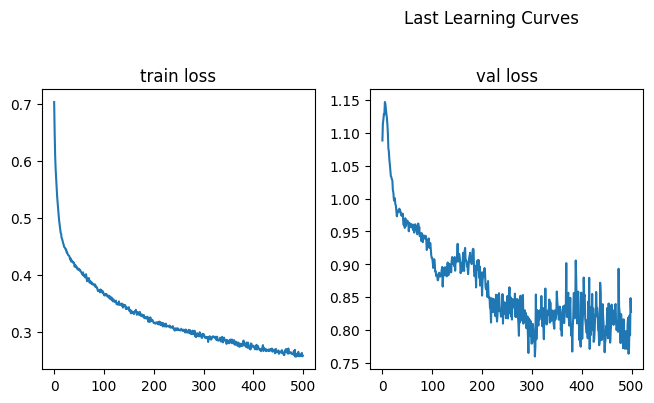

training SetTransformer_encoder on SAbDab-full
loading preprocessed data from ./data/processed_data_clip1_neg0_usepairTrue.pkl
model parameters:  439680
Epoch 0


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.28it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.98it/s]


Epoch 0: 
 Train Loss	0.8306 
 Val Loss	1.3513

Epoch 1


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.43it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.81it/s]


Epoch 1: 
 Train Loss	0.8285 
 Val Loss	1.4325

Epoch 2


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.47it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 87.15it/s]


Epoch 2: 
 Train Loss	0.7981 
 Val Loss	1.2754

Epoch 3


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.16it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.36it/s]


Epoch 3: 
 Train Loss	0.7750 
 Val Loss	1.2390

Epoch 4


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.16it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 97.46it/s]


Epoch 4: 
 Train Loss	0.7683 
 Val Loss	1.2081

Epoch 5


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.71it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 88.42it/s]


Epoch 5: 
 Train Loss	0.7579 
 Val Loss	1.2174

Epoch 6


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.38it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 95.56it/s]


Epoch 6: 
 Train Loss	0.7466 
 Val Loss	1.1714

Epoch 7


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.11it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.62it/s]


Epoch 7: 
 Train Loss	0.7359 
 Val Loss	1.1494

Epoch 8


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.93it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.76it/s]


Epoch 8: 
 Train Loss	0.7259 
 Val Loss	1.1433

Epoch 9


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.08it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 86.72it/s]


Epoch 9: 
 Train Loss	0.7174 
 Val Loss	1.1271

Epoch 10


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.50it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 150.08it/s]


Epoch 10: 
 Train Loss	0.7081 
 Val Loss	1.1119

Epoch 11


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.25it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 99.63it/s]


Epoch 11: 
 Train Loss	0.6972 
 Val Loss	1.1036

Epoch 12


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.99it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.90it/s]


Epoch 12: 
 Train Loss	0.6869 
 Val Loss	1.0966

Epoch 13


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.51it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 88.85it/s]


Epoch 13: 
 Train Loss	0.6777 
 Val Loss	1.0964

Epoch 14


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.43it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.78it/s]


Epoch 14: 
 Train Loss	0.6728 
 Val Loss	1.1030

Epoch 15


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.17it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 94.18it/s]


Epoch 15: 
 Train Loss	0.6649 
 Val Loss	1.0959

Epoch 16


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.94it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 98.25it/s]


Epoch 16: 
 Train Loss	0.6605 
 Val Loss	1.0907

Epoch 17


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.50it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.06it/s]


Epoch 17: 
 Train Loss	0.6539 
 Val Loss	1.0882

Epoch 18


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.94it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.87it/s]


Epoch 18: 
 Train Loss	0.6477 
 Val Loss	1.0844

Epoch 19


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.25it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 95.67it/s]


Epoch 19: 
 Train Loss	0.6419 
 Val Loss	1.0856

Epoch 20


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.19it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.82it/s]


Epoch 20: 
 Train Loss	0.6366 
 Val Loss	1.0888

Epoch 21


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.48it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.47it/s]


Epoch 21: 
 Train Loss	0.6340 
 Val Loss	1.0898

Epoch 22


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.01it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.99it/s]


Epoch 22: 
 Train Loss	0.6292 
 Val Loss	1.0896

Epoch 23


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.17it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 88.42it/s]


Epoch 23: 
 Train Loss	0.6244 
 Val Loss	1.0971

Epoch 24


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.57it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.53it/s]


Epoch 24: 
 Train Loss	0.6195 
 Val Loss	1.0949

Epoch 25


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.18it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.05it/s]


Epoch 25: 
 Train Loss	0.6156 
 Val Loss	1.1036

Epoch 26


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.15it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.14it/s]


Epoch 26: 
 Train Loss	0.6114 
 Val Loss	1.1064

Epoch 27


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.19it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.12it/s]


Epoch 27: 
 Train Loss	0.6074 
 Val Loss	1.1086

Epoch 28


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.52it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 156.50it/s]


Epoch 28: 
 Train Loss	0.6035 
 Val Loss	1.1111

Epoch 29


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.14it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 91.00it/s]


Epoch 29: 
 Train Loss	0.5995 
 Val Loss	1.1115

Epoch 30


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.02it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.84it/s]


Epoch 30: 
 Train Loss	0.5957 
 Val Loss	1.1099

Epoch 31


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.08it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 99.27it/s]


Epoch 31: 
 Train Loss	0.5921 
 Val Loss	1.1144

Epoch 32


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.81it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 94.30it/s]


Epoch 32: 
 Train Loss	0.5889 
 Val Loss	1.1191

Epoch 33


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.33it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 115.06it/s]


Epoch 33: 
 Train Loss	0.5855 
 Val Loss	1.1218

Epoch 34


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.16it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.86it/s]


Epoch 34: 
 Train Loss	0.5825 
 Val Loss	1.1228

Epoch 35


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.53it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 98.78it/s]


Epoch 35: 
 Train Loss	0.5796 
 Val Loss	1.1215

Epoch 36


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.01it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 91.19it/s]


Epoch 36: 
 Train Loss	0.5766 
 Val Loss	1.1189

Epoch 37


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.31it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.69it/s]


Epoch 37: 
 Train Loss	0.5736 
 Val Loss	1.1202

Epoch 38


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.57it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.59it/s]


Epoch 38: 
 Train Loss	0.5706 
 Val Loss	1.1226

Epoch 39


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.64it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 95.69it/s]


Epoch 39: 
 Train Loss	0.5675 
 Val Loss	1.1245

Epoch 40


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.21it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.84it/s]


Epoch 40: 
 Train Loss	0.5646 
 Val Loss	1.1281

Epoch 41


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.15it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.54it/s]


Epoch 41: 
 Train Loss	0.5617 
 Val Loss	1.1228

Epoch 42


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.26it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 96.87it/s]


Epoch 42: 
 Train Loss	0.5590 
 Val Loss	1.1240

Epoch 43


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.98it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 96.45it/s]


Epoch 43: 
 Train Loss	0.5562 
 Val Loss	1.1235

Epoch 44


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.03it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 95.58it/s]


Epoch 44: 
 Train Loss	0.5538 
 Val Loss	1.1210

Epoch 45


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.11it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 88.89it/s]


Epoch 45: 
 Train Loss	0.5511 
 Val Loss	1.1257

Epoch 46


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.02it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.92it/s]


Epoch 46: 
 Train Loss	0.5483 
 Val Loss	1.1287

Epoch 47


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.18it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 153.03it/s]


Epoch 47: 
 Train Loss	0.5457 
 Val Loss	1.1322

Epoch 48


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.15it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.95it/s]


Epoch 48: 
 Train Loss	0.5431 
 Val Loss	1.1328

Epoch 49


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.62it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.14it/s]


Epoch 49: 
 Train Loss	0.5405 
 Val Loss	1.1340

Epoch 50


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.87it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 92.42it/s]


Epoch 50: 
 Train Loss	0.5381 
 Val Loss	1.1363

Epoch 51


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.32it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 95.43it/s]


Epoch 51: 
 Train Loss	0.5356 
 Val Loss	1.1401

Epoch 52


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.27it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.65it/s]


Epoch 52: 
 Train Loss	0.5333 
 Val Loss	1.1417

Epoch 53


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.11it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.90it/s]


Epoch 53: 
 Train Loss	0.5308 
 Val Loss	1.1443

Epoch 54


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.43it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 93.86it/s]


Epoch 54: 
 Train Loss	0.5283 
 Val Loss	1.1435

Epoch 55


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.36it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 91.64it/s]


Epoch 55: 
 Train Loss	0.5259 
 Val Loss	1.1429

Epoch 56


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.35it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.19it/s]


Epoch 56: 
 Train Loss	0.5235 
 Val Loss	1.1437

Epoch 57


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.23it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 93.54it/s]


Epoch 57: 
 Train Loss	0.5210 
 Val Loss	1.1438

Epoch 58


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.30it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.99it/s]


Epoch 58: 
 Train Loss	0.5187 
 Val Loss	1.1447

Epoch 59


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.96it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 117.30it/s]


Epoch 59: 
 Train Loss	0.5164 
 Val Loss	1.1449

Epoch 60


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.33it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 97.22it/s]


Epoch 60: 
 Train Loss	0.5142 
 Val Loss	1.1441

Epoch 61


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.43it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 123.83it/s]


Epoch 61: 
 Train Loss	0.5120 
 Val Loss	1.1421

Epoch 62


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.33it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 118.27it/s]


Epoch 62: 
 Train Loss	0.5098 
 Val Loss	1.1412

Epoch 63


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.98it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.47it/s]


Epoch 63: 
 Train Loss	0.5076 
 Val Loss	1.1426

Epoch 64


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.45it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 164.68it/s]


Epoch 64: 
 Train Loss	0.5055 
 Val Loss	1.1414

Epoch 65


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.05it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 98.07it/s]


Epoch 65: 
 Train Loss	0.5033 
 Val Loss	1.1407

Epoch 66


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.13it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.70it/s]


Epoch 66: 
 Train Loss	0.5012 
 Val Loss	1.1400

Epoch 67


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.01it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 92.44it/s]


Epoch 67: 
 Train Loss	0.4991 
 Val Loss	1.1403

Epoch 68


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.06it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.12it/s]


Epoch 68: 
 Train Loss	0.4970 
 Val Loss	1.1403

Epoch 69


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.24it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.70it/s]


Epoch 69: 
 Train Loss	0.4949 
 Val Loss	1.1403

Epoch 70


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.88it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.85it/s]


Epoch 70: 
 Train Loss	0.4928 
 Val Loss	1.1409

Epoch 71


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.60it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.16it/s]


Epoch 71: 
 Train Loss	0.4908 
 Val Loss	1.1416

Epoch 72


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.52it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 95.00it/s]


Epoch 72: 
 Train Loss	0.4887 
 Val Loss	1.1425

Epoch 73


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.88it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.79it/s]


Epoch 73: 
 Train Loss	0.4868 
 Val Loss	1.1433

Epoch 74


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.27it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.91it/s]


Epoch 74: 
 Train Loss	0.4849 
 Val Loss	1.1431

Epoch 75


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.04it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.88it/s]


Epoch 75: 
 Train Loss	0.4829 
 Val Loss	1.1444

Epoch 76


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.36it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.59it/s]


Epoch 76: 
 Train Loss	0.4809 
 Val Loss	1.1440

Epoch 77


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.26it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.50it/s]


Epoch 77: 
 Train Loss	0.4790 
 Val Loss	1.1441

Epoch 78


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.65it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.08it/s]


Epoch 78: 
 Train Loss	0.4771 
 Val Loss	1.1439

Epoch 79


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.63it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 105.73it/s]


Epoch 79: 
 Train Loss	0.4753 
 Val Loss	1.1431

Epoch 80


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.22it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 85.84it/s]


Epoch 80: 
 Train Loss	0.4733 
 Val Loss	1.1427

Epoch 81


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.72it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.71it/s]


Epoch 81: 
 Train Loss	0.4714 
 Val Loss	1.1432

Epoch 82


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.37it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.93it/s]


Epoch 82: 
 Train Loss	0.4695 
 Val Loss	1.1431

Epoch 83


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.39it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 96.33it/s]


Epoch 83: 
 Train Loss	0.4677 
 Val Loss	1.1431

Epoch 84


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.26it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 220.12it/s]


Epoch 84: 
 Train Loss	0.4658 
 Val Loss	1.1433

Epoch 85


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.40it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.48it/s]


Epoch 85: 
 Train Loss	0.4639 
 Val Loss	1.1434

Epoch 86


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.33it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 97.95it/s]


Epoch 86: 
 Train Loss	0.4621 
 Val Loss	1.1434

Epoch 87


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.52it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.30it/s]


Epoch 87: 
 Train Loss	0.4603 
 Val Loss	1.1433

Epoch 88


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.52it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.65it/s]


Epoch 88: 
 Train Loss	0.4585 
 Val Loss	1.1433

Epoch 89


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.14it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 95.49it/s]


Epoch 89: 
 Train Loss	0.4567 
 Val Loss	1.1434

Epoch 90


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.28it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.74it/s]


Epoch 90: 
 Train Loss	0.4549 
 Val Loss	1.1436

Epoch 91


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.19it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 112.04it/s]


Epoch 91: 
 Train Loss	0.4532 
 Val Loss	1.1440

Epoch 92


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.27it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 109.46it/s]


Epoch 92: 
 Train Loss	0.4515 
 Val Loss	1.1451

Epoch 93


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.54it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.76it/s]


Epoch 93: 
 Train Loss	0.4498 
 Val Loss	1.1453

Epoch 94


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.24it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 95.04it/s]


Epoch 94: 
 Train Loss	0.4481 
 Val Loss	1.1446

Epoch 95


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.17it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.10it/s]


Epoch 95: 
 Train Loss	0.4464 
 Val Loss	1.1450

Epoch 96


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.48it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 95.50it/s]


Epoch 96: 
 Train Loss	0.4447 
 Val Loss	1.1436

Epoch 97


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.03it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 98.03it/s]


Epoch 97: 
 Train Loss	0.4431 
 Val Loss	1.1439

Epoch 98


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.84it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.45it/s]


Epoch 98: 
 Train Loss	0.4415 
 Val Loss	1.1433

Epoch 99


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.12it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 137.45it/s]


Epoch 99: 
 Train Loss	0.4399 
 Val Loss	1.1443

Epoch 100


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.31it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.64it/s]


Epoch 100: 
 Train Loss	0.4383 
 Val Loss	1.1449

Epoch 101


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.43it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.87it/s]


Epoch 101: 
 Train Loss	0.4368 
 Val Loss	1.1445

Epoch 102


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.98it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 124.25it/s]


Epoch 102: 
 Train Loss	0.4352 
 Val Loss	1.1452

Epoch 103


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.13it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 108.99it/s]


Epoch 103: 
 Train Loss	0.4337 
 Val Loss	1.1454

Epoch 104


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.92it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.70it/s]


Epoch 104: 
 Train Loss	0.4322 
 Val Loss	1.1463

Epoch 105


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.21it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 92.53it/s]


Epoch 105: 
 Train Loss	0.4307 
 Val Loss	1.1467

Epoch 106


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.72it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 92.98it/s]


Epoch 106: 
 Train Loss	0.4292 
 Val Loss	1.1481

Epoch 107


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.14it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 91.29it/s]


Epoch 107: 
 Train Loss	0.4278 
 Val Loss	1.1494

Epoch 108


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.28it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.42it/s]


Epoch 108: 
 Train Loss	0.4264 
 Val Loss	1.1516

Epoch 109


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.86it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 97.61it/s]


Epoch 109: 
 Train Loss	0.4250 
 Val Loss	1.1523

Epoch 110


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.49it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 88.92it/s]


Epoch 110: 
 Train Loss	0.4236 
 Val Loss	1.1522

Epoch 111


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.65it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 122.21it/s]


Epoch 111: 
 Train Loss	0.4222 
 Val Loss	1.1532

Epoch 112


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.93it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.92it/s]


Epoch 112: 
 Train Loss	0.4208 
 Val Loss	1.1538

Epoch 113


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.60it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.33it/s]


Epoch 113: 
 Train Loss	0.4194 
 Val Loss	1.1541

Epoch 114


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.89it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 106.94it/s]


Epoch 114: 
 Train Loss	0.4180 
 Val Loss	1.1542

Epoch 115


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.77it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 88.73it/s]


Epoch 115: 
 Train Loss	0.4167 
 Val Loss	1.1547

Epoch 116


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.22it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 133.61it/s]


Epoch 116: 
 Train Loss	0.4153 
 Val Loss	1.1548

Epoch 117


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.01it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 94.78it/s]


Epoch 117: 
 Train Loss	0.4139 
 Val Loss	1.1553

Epoch 118


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.17it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 110.46it/s]


Epoch 118: 
 Train Loss	0.4126 
 Val Loss	1.1563

Epoch 119


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.95it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 95.93it/s]


Epoch 119: 
 Train Loss	0.4113 
 Val Loss	1.1562

Epoch 120


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.89it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.83it/s]


Epoch 120: 
 Train Loss	0.4100 
 Val Loss	1.1565

Epoch 121


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.55it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 96.85it/s]


Epoch 121: 
 Train Loss	0.4087 
 Val Loss	1.1549

Epoch 122


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.98it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 107.87it/s]


Epoch 122: 
 Train Loss	0.4075 
 Val Loss	1.1528

Epoch 123


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.08it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 167.28it/s]


Epoch 123: 
 Train Loss	0.4062 
 Val Loss	1.1517

Epoch 124


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.65it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 92.51it/s]


Epoch 124: 
 Train Loss	0.4050 
 Val Loss	1.1507

Epoch 125


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.80it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.57it/s]


Epoch 125: 
 Train Loss	0.4037 
 Val Loss	1.1496

Epoch 126


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.42it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 99.74it/s]


Epoch 126: 
 Train Loss	0.4025 
 Val Loss	1.1481

Epoch 127


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.30it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.76it/s]


Epoch 127: 
 Train Loss	0.4013 
 Val Loss	1.1475

Epoch 128


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.33it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.55it/s]


Epoch 128: 
 Train Loss	0.4001 
 Val Loss	1.1462

Epoch 129


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.16it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 88.75it/s]


Epoch 129: 
 Train Loss	0.3989 
 Val Loss	1.1455

Epoch 130


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.11it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 88.92it/s]


Epoch 130: 
 Train Loss	0.3978 
 Val Loss	1.1451

Epoch 131


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.54it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.70it/s]


Epoch 131: 
 Train Loss	0.3966 
 Val Loss	1.1436

Epoch 132


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.69it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.94it/s]


Epoch 132: 
 Train Loss	0.3955 
 Val Loss	1.1429

Epoch 133


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.46it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 95.66it/s]


Epoch 133: 
 Train Loss	0.3943 
 Val Loss	1.1425

Epoch 134


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.91it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.83it/s]


Epoch 134: 
 Train Loss	0.3932 
 Val Loss	1.1415

Epoch 135


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.13it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 92.00it/s]


Epoch 135: 
 Train Loss	0.3921 
 Val Loss	1.1404

Epoch 136


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.33it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.95it/s]


Epoch 136: 
 Train Loss	0.3910 
 Val Loss	1.1398

Epoch 137


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.93it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 94.24it/s]


Epoch 137: 
 Train Loss	0.3899 
 Val Loss	1.1378

Epoch 138


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.40it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 129.37it/s]


Epoch 138: 
 Train Loss	0.3888 
 Val Loss	1.1370

Epoch 139


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.31it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.35it/s]


Epoch 139: 
 Train Loss	0.3877 
 Val Loss	1.1360

Epoch 140


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.48it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 112.37it/s]


Epoch 140: 
 Train Loss	0.3866 
 Val Loss	1.1354

Epoch 141


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.10it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 126.59it/s]


Epoch 141: 
 Train Loss	0.3856 
 Val Loss	1.1341

Epoch 142


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.35it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 95.79it/s]


Epoch 142: 
 Train Loss	0.3845 
 Val Loss	1.1335

Epoch 143


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.60it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.57it/s]


Epoch 143: 
 Train Loss	0.3835 
 Val Loss	1.1328

Epoch 144


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.10it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 95.62it/s]


Epoch 144: 
 Train Loss	0.3825 
 Val Loss	1.1323

Epoch 145


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.25it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.43it/s]


Epoch 145: 
 Train Loss	0.3815 
 Val Loss	1.1322

Epoch 146


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.04it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.71it/s]


Epoch 146: 
 Train Loss	0.3805 
 Val Loss	1.1317

Epoch 147


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.87it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 106.10it/s]


Epoch 147: 
 Train Loss	0.3795 
 Val Loss	1.1313

Epoch 148


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.40it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 92.73it/s]


Epoch 148: 
 Train Loss	0.3786 
 Val Loss	1.1306

Epoch 149


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.65it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.89it/s]


Epoch 149: 
 Train Loss	0.3776 
 Val Loss	1.1298

Epoch 150


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.32it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 88.69it/s]


Epoch 150: 
 Train Loss	0.3766 
 Val Loss	1.1288

Epoch 151


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.34it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 95.99it/s]


Epoch 151: 
 Train Loss	0.3757 
 Val Loss	1.1286

Epoch 152


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.29it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.65it/s]


Epoch 152: 
 Train Loss	0.3748 
 Val Loss	1.1274

Epoch 153


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.32it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 93.84it/s]


Epoch 153: 
 Train Loss	0.3739 
 Val Loss	1.1266

Epoch 154


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.27it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 93.30it/s]


Epoch 154: 
 Train Loss	0.3730 
 Val Loss	1.1253

Epoch 155


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.73it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 92.10it/s]


Epoch 155: 
 Train Loss	0.3721 
 Val Loss	1.1241

Epoch 156


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.35it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.55it/s]


Epoch 156: 
 Train Loss	0.3712 
 Val Loss	1.1235

Epoch 157


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.29it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.82it/s]


Epoch 157: 
 Train Loss	0.3704 
 Val Loss	1.1230

Epoch 158


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.86it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 91.11it/s]


Epoch 158: 
 Train Loss	0.3695 
 Val Loss	1.1216

Epoch 159


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.32it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.98it/s]


Epoch 159: 
 Train Loss	0.3687 
 Val Loss	1.1203

Epoch 160


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.88it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.82it/s]


Epoch 160: 
 Train Loss	0.3679 
 Val Loss	1.1190

Epoch 161


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.48it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 97.31it/s]


Epoch 161: 
 Train Loss	0.3670 
 Val Loss	1.1185

Epoch 162


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.40it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.83it/s]


Epoch 162: 
 Train Loss	0.3662 
 Val Loss	1.1178

Epoch 163


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.95it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.08it/s]


Epoch 163: 
 Train Loss	0.3654 
 Val Loss	1.1174

Epoch 164


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.77it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 87.44it/s]


Epoch 164: 
 Train Loss	0.3646 
 Val Loss	1.1161

Epoch 165


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.14it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.06it/s]


Epoch 165: 
 Train Loss	0.3639 
 Val Loss	1.1160

Epoch 166


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.20it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 88.83it/s]


Epoch 166: 
 Train Loss	0.3631 
 Val Loss	1.1154

Epoch 167


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.40it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.23it/s]


Epoch 167: 
 Train Loss	0.3623 
 Val Loss	1.1144

Epoch 168


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.09it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 123.44it/s]


Epoch 168: 
 Train Loss	0.3616 
 Val Loss	1.1127

Epoch 169


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.76it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 94.72it/s]


Epoch 169: 
 Train Loss	0.3608 
 Val Loss	1.1123

Epoch 170


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.86it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 87.89it/s]


Epoch 170: 
 Train Loss	0.3601 
 Val Loss	1.1111

Epoch 171


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.03it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 128.74it/s]


Epoch 171: 
 Train Loss	0.3593 
 Val Loss	1.1102

Epoch 172


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.80it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 80.78it/s]


Epoch 172: 
 Train Loss	0.3586 
 Val Loss	1.1100

Epoch 173


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.89it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 86.42it/s]


Epoch 173: 
 Train Loss	0.3578 
 Val Loss	1.1093

Epoch 174


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.45it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 94.62it/s]


Epoch 174: 
 Train Loss	0.3571 
 Val Loss	1.1086

Epoch 175


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.96it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 92.45it/s]


Epoch 175: 
 Train Loss	0.3564 
 Val Loss	1.1077

Epoch 176


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.73it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 95.77it/s]


Epoch 176: 
 Train Loss	0.3557 
 Val Loss	1.1073

Epoch 177


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.20it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 92.91it/s]


Epoch 177: 
 Train Loss	0.3550 
 Val Loss	1.1073

Epoch 178


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.84it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 85.68it/s]


Epoch 178: 
 Train Loss	0.3544 
 Val Loss	1.1074

Epoch 179


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.88it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.70it/s]


Epoch 179: 
 Train Loss	0.3537 
 Val Loss	1.1069

Epoch 180


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.25it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 93.29it/s]


Epoch 180: 
 Train Loss	0.3530 
 Val Loss	1.1065

Epoch 181


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.70it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 85.50it/s]


Epoch 181: 
 Train Loss	0.3524 
 Val Loss	1.1069

Epoch 182


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.13it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 86.41it/s]


Epoch 182: 
 Train Loss	0.3517 
 Val Loss	1.1076

Epoch 183


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.86it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 85.67it/s]


Epoch 183: 
 Train Loss	0.3510 
 Val Loss	1.1072

Epoch 184


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.35it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 86.62it/s]


Epoch 184: 
 Train Loss	0.3504 
 Val Loss	1.1074

Epoch 185


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.23it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 118.55it/s]


Epoch 185: 
 Train Loss	0.3497 
 Val Loss	1.1069

Epoch 186


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.93it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 84.09it/s]


Epoch 186: 
 Train Loss	0.3491 
 Val Loss	1.1063

Epoch 187


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.26it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 86.61it/s]


Epoch 187: 
 Train Loss	0.3484 
 Val Loss	1.1056

Epoch 188


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.61it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 85.72it/s]


Epoch 188: 
 Train Loss	0.3478 
 Val Loss	1.1048

Epoch 189


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.34it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.87it/s]


Epoch 189: 
 Train Loss	0.3471 
 Val Loss	1.1044

Epoch 190


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.05it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 86.63it/s]


Epoch 190: 
 Train Loss	0.3465 
 Val Loss	1.1052

Epoch 191


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.86it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 86.38it/s]


Epoch 191: 
 Train Loss	0.3458 
 Val Loss	1.1059

Epoch 192


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.60it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.75it/s]


Epoch 192: 
 Train Loss	0.3453 
 Val Loss	1.1054

Epoch 193


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.28it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 93.45it/s]


Epoch 193: 
 Train Loss	0.3447 
 Val Loss	1.1058

Epoch 194


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.59it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.76it/s]


Epoch 194: 
 Train Loss	0.3441 
 Val Loss	1.1055

Epoch 195


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.77it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 87.23it/s]


Epoch 195: 
 Train Loss	0.3435 
 Val Loss	1.1056

Epoch 196


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.84it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 83.91it/s]


Epoch 196: 
 Train Loss	0.3429 
 Val Loss	1.1057

Epoch 197


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.90it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 156.13it/s]


Epoch 197: 
 Train Loss	0.3423 
 Val Loss	1.1061

Epoch 198


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.78it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.79it/s]


Epoch 198: 
 Train Loss	0.3417 
 Val Loss	1.1058

Epoch 199


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.27it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 86.28it/s]


Epoch 199: 
 Train Loss	0.3412 
 Val Loss	1.1053

Epoch 200


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.39it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 83.48it/s]


Epoch 200: 
 Train Loss	0.3406 
 Val Loss	1.1052

Epoch 201


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.21it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 84.66it/s]


Epoch 201: 
 Train Loss	0.3400 
 Val Loss	1.1058

Epoch 202


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.92it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 84.35it/s]


Epoch 202: 
 Train Loss	0.3395 
 Val Loss	1.1058

Epoch 203


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.75it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 82.39it/s]


Epoch 203: 
 Train Loss	0.3389 
 Val Loss	1.1045

Epoch 204


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.58it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 86.26it/s]


Epoch 204: 
 Train Loss	0.3384 
 Val Loss	1.1046

Epoch 205


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.68it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.21it/s]


Epoch 205: 
 Train Loss	0.3378 
 Val Loss	1.1046

Epoch 206


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.77it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 124.86it/s]


Epoch 206: 
 Train Loss	0.3373 
 Val Loss	1.1047

Epoch 207


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.80it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.63it/s]


Epoch 207: 
 Train Loss	0.3367 
 Val Loss	1.1046

Epoch 208


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.10it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 117.05it/s]


Epoch 208: 
 Train Loss	0.3362 
 Val Loss	1.1051

Epoch 209


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.45it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.94it/s]


Epoch 209: 
 Train Loss	0.3356 
 Val Loss	1.1052

Epoch 210


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.57it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 147.88it/s]


Epoch 210: 
 Train Loss	0.3351 
 Val Loss	1.1047

Epoch 211


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.52it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 83.87it/s]


Epoch 211: 
 Train Loss	0.3346 
 Val Loss	1.1043

Epoch 212


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.74it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 83.51it/s]


Epoch 212: 
 Train Loss	0.3341 
 Val Loss	1.1046

Epoch 213


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.70it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 87.75it/s]


Epoch 213: 
 Train Loss	0.3336 
 Val Loss	1.1055

Epoch 214


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.77it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 83.72it/s]


Epoch 214: 
 Train Loss	0.3331 
 Val Loss	1.1061

Epoch 215


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.33it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 83.35it/s]


Epoch 215: 
 Train Loss	0.3326 
 Val Loss	1.1064

Epoch 216


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.63it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 86.16it/s]


Epoch 216: 
 Train Loss	0.3320 
 Val Loss	1.1070

Epoch 217


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.53it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 105.99it/s]


Epoch 217: 
 Train Loss	0.3315 
 Val Loss	1.1068

Epoch 218


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.28it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 85.96it/s]


Epoch 218: 
 Train Loss	0.3310 
 Val Loss	1.1073

Epoch 219


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.47it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 86.99it/s]


Epoch 219: 
 Train Loss	0.3306 
 Val Loss	1.1085

Epoch 220


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.27it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 86.70it/s]


Epoch 220: 
 Train Loss	0.3301 
 Val Loss	1.1088

Epoch 221


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.68it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 86.67it/s]


Epoch 221: 
 Train Loss	0.3296 
 Val Loss	1.1091

Epoch 222


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.41it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 87.45it/s]


Epoch 222: 
 Train Loss	0.3291 
 Val Loss	1.1094

Epoch 223


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.60it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 95.90it/s]


Epoch 223: 
 Train Loss	0.3287 
 Val Loss	1.1099

Epoch 224


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.69it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 151.34it/s]


Epoch 224: 
 Train Loss	0.3282 
 Val Loss	1.1097

Epoch 225


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.46it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 139.91it/s]


Epoch 225: 
 Train Loss	0.3278 
 Val Loss	1.1093

Epoch 226


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.05it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 84.34it/s]


Epoch 226: 
 Train Loss	0.3273 
 Val Loss	1.1090

Epoch 227


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.38it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 123.75it/s]


Epoch 227: 
 Train Loss	0.3269 
 Val Loss	1.1083

Epoch 228


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.84it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 93.64it/s]


Epoch 228: 
 Train Loss	0.3264 
 Val Loss	1.1080

Epoch 229


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.90it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 94.52it/s]


Epoch 229: 
 Train Loss	0.3259 
 Val Loss	1.1084

Epoch 230


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.48it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 86.75it/s]


Epoch 230: 
 Train Loss	0.3255 
 Val Loss	1.1085

Epoch 231


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.44it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 87.41it/s]


Epoch 231: 
 Train Loss	0.3250 
 Val Loss	1.1089

Epoch 232


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.86it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 92.09it/s]


Epoch 232: 
 Train Loss	0.3246 
 Val Loss	1.1086

Epoch 233


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.44it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 94.03it/s]


Epoch 233: 
 Train Loss	0.3242 
 Val Loss	1.1098

Epoch 234


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.97it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 83.68it/s]


Epoch 234: 
 Train Loss	0.3237 
 Val Loss	1.1097

Epoch 235


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.12it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 94.48it/s]


Epoch 235: 
 Train Loss	0.3233 
 Val Loss	1.1095

Epoch 236


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.80it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 112.72it/s]


Epoch 236: 
 Train Loss	0.3228 
 Val Loss	1.1094

Epoch 237


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.67it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 84.47it/s]


Epoch 237: 
 Train Loss	0.3225 
 Val Loss	1.1101

Epoch 238


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.84it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 118.57it/s]


Epoch 238: 
 Train Loss	0.3220 
 Val Loss	1.1107

Epoch 239


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.59it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 93.24it/s]


Epoch 239: 
 Train Loss	0.3217 
 Val Loss	1.1100

Epoch 240


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.77it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 84.60it/s]


Epoch 240: 
 Train Loss	0.3213 
 Val Loss	1.1100

Epoch 241


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.45it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.81it/s]


Epoch 241: 
 Train Loss	0.3208 
 Val Loss	1.1099

Epoch 242


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.57it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 92.98it/s]


Epoch 242: 
 Train Loss	0.3204 
 Val Loss	1.1101

Epoch 243


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.32it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.05it/s]


Epoch 243: 
 Train Loss	0.3200 
 Val Loss	1.1103

Epoch 244


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.97it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 91.74it/s]


Epoch 244: 
 Train Loss	0.3196 
 Val Loss	1.1104

Epoch 245


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.46it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 96.64it/s]


Epoch 245: 
 Train Loss	0.3192 
 Val Loss	1.1105

Epoch 246


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.78it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 85.87it/s]


Epoch 246: 
 Train Loss	0.3188 
 Val Loss	1.1104

Epoch 247


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.00it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 139.38it/s]


Epoch 247: 
 Train Loss	0.3184 
 Val Loss	1.1101

Epoch 248


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.73it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.34it/s]


Epoch 248: 
 Train Loss	0.3180 
 Val Loss	1.1103

Epoch 249


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.14it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 85.05it/s]


Epoch 249: 
 Train Loss	0.3176 
 Val Loss	1.1107

Epoch 250


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.97it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.44it/s]


Epoch 250: 
 Train Loss	0.3172 
 Val Loss	1.1111

Epoch 251


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.12it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 105.09it/s]


Epoch 251: 
 Train Loss	0.3168 
 Val Loss	1.1113

Epoch 252


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.11it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 87.89it/s]


Epoch 252: 
 Train Loss	0.3165 
 Val Loss	1.1113

Epoch 253


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.48it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.48it/s]


Epoch 253: 
 Train Loss	0.3161 
 Val Loss	1.1115

Epoch 254


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.68it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 98.84it/s]


Epoch 254: 
 Train Loss	0.3157 
 Val Loss	1.1116

Epoch 255


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.81it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 86.66it/s]


Epoch 255: 
 Train Loss	0.3154 
 Val Loss	1.1118

Epoch 256


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.72it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 86.64it/s]


Epoch 256: 
 Train Loss	0.3150 
 Val Loss	1.1120

Epoch 257


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.50it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 84.07it/s]


Epoch 257: 
 Train Loss	0.3146 
 Val Loss	1.1116

Epoch 258


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.06it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 86.70it/s]


Epoch 258: 
 Train Loss	0.3142 
 Val Loss	1.1120

Epoch 259


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.78it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 86.44it/s]


Epoch 259: 
 Train Loss	0.3138 
 Val Loss	1.1127

Epoch 260


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.89it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 84.65it/s]


Epoch 260: 
 Train Loss	0.3135 
 Val Loss	1.1130

Epoch 261


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.10it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 85.48it/s]


Epoch 261: 
 Train Loss	0.3131 
 Val Loss	1.1126

Epoch 262


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.10it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 85.63it/s]


Epoch 262: 
 Train Loss	0.3127 
 Val Loss	1.1124

Epoch 263


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.72it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 92.46it/s]


Epoch 263: 
 Train Loss	0.3124 
 Val Loss	1.1125

Epoch 264


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.42it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 96.61it/s]


Epoch 264: 
 Train Loss	0.3120 
 Val Loss	1.1119

Epoch 265


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.84it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 106.45it/s]


Epoch 265: 
 Train Loss	0.3116 
 Val Loss	1.1121

Epoch 266


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.09it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 92.49it/s]


Epoch 266: 
 Train Loss	0.3113 
 Val Loss	1.1125

Epoch 267


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.87it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.19it/s]


Epoch 267: 
 Train Loss	0.3109 
 Val Loss	1.1123

Epoch 268


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.49it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 97.75it/s]


Epoch 268: 
 Train Loss	0.3106 
 Val Loss	1.1125

Epoch 269


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.84it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 84.41it/s]


Epoch 269: 
 Train Loss	0.3103 
 Val Loss	1.1120

Epoch 270


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.42it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 99.63it/s]


Epoch 270: 
 Train Loss	0.3100 
 Val Loss	1.1121

Epoch 271


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.93it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 120.54it/s]


Epoch 271: 
 Train Loss	0.3097 
 Val Loss	1.1117

Epoch 272


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.69it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 84.44it/s]


Epoch 272: 
 Train Loss	0.3093 
 Val Loss	1.1121

Epoch 273


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.74it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 91.42it/s]


Epoch 273: 
 Train Loss	0.3090 
 Val Loss	1.1115

Epoch 274


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.73it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 133.40it/s]


Epoch 274: 
 Train Loss	0.3087 
 Val Loss	1.1107

Epoch 275


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.53it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 84.84it/s]


Epoch 275: 
 Train Loss	0.3083 
 Val Loss	1.1099

Epoch 276


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.86it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 121.55it/s]


Epoch 276: 
 Train Loss	0.3080 
 Val Loss	1.1097

Epoch 277


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.74it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 85.22it/s]


Epoch 277: 
 Train Loss	0.3076 
 Val Loss	1.1093

Epoch 278


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.18it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 110.71it/s]


Epoch 278: 
 Train Loss	0.3073 
 Val Loss	1.1095

Epoch 279


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.74it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 88.99it/s]


Epoch 279: 
 Train Loss	0.3070 
 Val Loss	1.1096

Epoch 280


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.80it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 84.90it/s]


Epoch 280: 
 Train Loss	0.3066 
 Val Loss	1.1092

Epoch 281


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.02it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 98.09it/s]


Epoch 281: 
 Train Loss	0.3063 
 Val Loss	1.1095

Epoch 282


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.33it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 91.00it/s]


Epoch 282: 
 Train Loss	0.3060 
 Val Loss	1.1096

Epoch 283


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.27it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 86.60it/s]


Epoch 283: 
 Train Loss	0.3057 
 Val Loss	1.1085

Epoch 284


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.32it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 83.87it/s]


Epoch 284: 
 Train Loss	0.3054 
 Val Loss	1.1089

Epoch 285


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.01it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 83.74it/s]


Epoch 285: 
 Train Loss	0.3051 
 Val Loss	1.1085

Epoch 286


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.91it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 83.59it/s]


Epoch 286: 
 Train Loss	0.3048 
 Val Loss	1.1087

Epoch 287


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.64it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 115.63it/s]


Epoch 287: 
 Train Loss	0.3044 
 Val Loss	1.1084

Epoch 288


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.53it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 84.12it/s]


Epoch 288: 
 Train Loss	0.3041 
 Val Loss	1.1086

Epoch 289


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.09it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 95.40it/s]


Epoch 289: 
 Train Loss	0.3038 
 Val Loss	1.1084

Epoch 290


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 37.68it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 98.88it/s]


Epoch 290: 
 Train Loss	0.3035 
 Val Loss	1.1084

Epoch 291


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.51it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 99.55it/s]


Epoch 291: 
 Train Loss	0.3031 
 Val Loss	1.1092

Epoch 292


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.08it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 83.12it/s]


Epoch 292: 
 Train Loss	0.3028 
 Val Loss	1.1092

Epoch 293


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.38it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 99.84it/s]


Epoch 293: 
 Train Loss	0.3025 
 Val Loss	1.1086

Epoch 294


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.58it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 129.00it/s]


Epoch 294: 
 Train Loss	0.3022 
 Val Loss	1.1082

Epoch 295


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.76it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.19it/s]


Epoch 295: 
 Train Loss	0.3019 
 Val Loss	1.1076

Epoch 296


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.36it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 84.99it/s]


Epoch 296: 
 Train Loss	0.3016 
 Val Loss	1.1068

Epoch 297


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.62it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 85.99it/s]


Epoch 297: 
 Train Loss	0.3013 
 Val Loss	1.1062

Epoch 298


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.51it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 91.37it/s]


Epoch 298: 
 Train Loss	0.3009 
 Val Loss	1.1067

Epoch 299


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.98it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 86.66it/s]


Epoch 299: 
 Train Loss	0.3006 
 Val Loss	1.1058

Epoch 300


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.88it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 88.09it/s]


Epoch 300: 
 Train Loss	0.3003 
 Val Loss	1.1056

Epoch 301


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.48it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 79.34it/s]


Epoch 301: 
 Train Loss	0.3000 
 Val Loss	1.1048

Epoch 302


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.63it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 93.05it/s]


Epoch 302: 
 Train Loss	0.2998 
 Val Loss	1.1048

Epoch 303


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.35it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 88.51it/s]


Epoch 303: 
 Train Loss	0.2995 
 Val Loss	1.1049

Epoch 304


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.33it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 122.55it/s]


Epoch 304: 
 Train Loss	0.2992 
 Val Loss	1.1052

Epoch 305


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.71it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 84.52it/s]


Epoch 305: 
 Train Loss	0.2989 
 Val Loss	1.1044

Epoch 306


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.74it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 87.81it/s]


Epoch 306: 
 Train Loss	0.2986 
 Val Loss	1.1036

Epoch 307


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.79it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 91.68it/s]


Epoch 307: 
 Train Loss	0.2984 
 Val Loss	1.1041

Epoch 308


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.56it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 83.48it/s]


Epoch 308: 
 Train Loss	0.2981 
 Val Loss	1.1033

Epoch 309


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.71it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 118.93it/s]


Epoch 309: 
 Train Loss	0.2978 
 Val Loss	1.1031

Epoch 310


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.00it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 83.59it/s]


Epoch 310: 
 Train Loss	0.2975 
 Val Loss	1.1029

Epoch 311


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.37it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 122.88it/s]


Epoch 311: 
 Train Loss	0.2972 
 Val Loss	1.1023

Epoch 312


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.77it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 82.51it/s]


Epoch 312: 
 Train Loss	0.2970 
 Val Loss	1.1017

Epoch 313


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.02it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 86.75it/s]


Epoch 313: 
 Train Loss	0.2967 
 Val Loss	1.1015

Epoch 314


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.52it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.47it/s]


Epoch 314: 
 Train Loss	0.2964 
 Val Loss	1.1011

Epoch 315


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.49it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 86.67it/s]


Epoch 315: 
 Train Loss	0.2961 
 Val Loss	1.1012

Epoch 316


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.40it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 83.94it/s]


Epoch 316: 
 Train Loss	0.2959 
 Val Loss	1.1010

Epoch 317


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.81it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 86.83it/s]


Epoch 317: 
 Train Loss	0.2956 
 Val Loss	1.1010

Epoch 318


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.82it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 85.45it/s]


Epoch 318: 
 Train Loss	0.2953 
 Val Loss	1.1005

Epoch 319


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.34it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 107.41it/s]


Epoch 319: 
 Train Loss	0.2951 
 Val Loss	1.1000

Epoch 320


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.79it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 85.93it/s]


Epoch 320: 
 Train Loss	0.2948 
 Val Loss	1.0997

Epoch 321


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.57it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 86.86it/s]


Epoch 321: 
 Train Loss	0.2945 
 Val Loss	1.0995

Epoch 322


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.89it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 94.27it/s]


Epoch 322: 
 Train Loss	0.2942 
 Val Loss	1.0989

Epoch 323


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.44it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 88.29it/s]


Epoch 323: 
 Train Loss	0.2940 
 Val Loss	1.0988

Epoch 324


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.36it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.94it/s]


Epoch 324: 
 Train Loss	0.2937 
 Val Loss	1.0982

Epoch 325


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.51it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 92.68it/s]


Epoch 325: 
 Train Loss	0.2934 
 Val Loss	1.0979

Epoch 326


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 37.58it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 86.77it/s]


Epoch 326: 
 Train Loss	0.2932 
 Val Loss	1.0973

Epoch 327


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 37.93it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 98.84it/s]


Epoch 327: 
 Train Loss	0.2929 
 Val Loss	1.0966

Epoch 328


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.14it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 85.99it/s]


Epoch 328: 
 Train Loss	0.2927 
 Val Loss	1.0972

Epoch 329


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 37.77it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 86.10it/s]


Epoch 329: 
 Train Loss	0.2924 
 Val Loss	1.0968

Epoch 330


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 37.65it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 86.54it/s]


Epoch 330: 
 Train Loss	0.2921 
 Val Loss	1.0958

Epoch 331


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 37.97it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 85.91it/s]


Epoch 331: 
 Train Loss	0.2919 
 Val Loss	1.0957

Epoch 332


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 37.69it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 129.75it/s]


Epoch 332: 
 Train Loss	0.2916 
 Val Loss	1.0951

Epoch 333


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.06it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 133.78it/s]


Epoch 333: 
 Train Loss	0.2914 
 Val Loss	1.0950

Epoch 334


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.88it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 96.59it/s]


Epoch 334: 
 Train Loss	0.2911 
 Val Loss	1.0948

Epoch 335


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.32it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 86.53it/s]


Epoch 335: 
 Train Loss	0.2908 
 Val Loss	1.0949

Epoch 336


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.03it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 83.84it/s]


Epoch 336: 
 Train Loss	0.2906 
 Val Loss	1.0946

Epoch 337


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.90it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 84.16it/s]


Epoch 337: 
 Train Loss	0.2903 
 Val Loss	1.0947

Epoch 338


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.38it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 140.66it/s]


Epoch 338: 
 Train Loss	0.2901 
 Val Loss	1.0944

Epoch 339


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.93it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 95.91it/s]


Epoch 339: 
 Train Loss	0.2898 
 Val Loss	1.0955

Epoch 340


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.48it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 88.93it/s]


Epoch 340: 
 Train Loss	0.2895 
 Val Loss	1.0948

Epoch 341


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.28it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 98.76it/s]


Epoch 341: 
 Train Loss	0.2893 
 Val Loss	1.0951

Epoch 342


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.76it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 97.08it/s]


Epoch 342: 
 Train Loss	0.2890 
 Val Loss	1.0951

Epoch 343


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.25it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 94.79it/s]


Epoch 343: 
 Train Loss	0.2888 
 Val Loss	1.0954

Epoch 344


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.62it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 95.33it/s]


Epoch 344: 
 Train Loss	0.2885 
 Val Loss	1.0957

Epoch 345


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.08it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 108.73it/s]


Epoch 345: 
 Train Loss	0.2883 
 Val Loss	1.0958

Epoch 346


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.85it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 94.90it/s]


Epoch 346: 
 Train Loss	0.2881 
 Val Loss	1.0951

Epoch 347


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.79it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 96.93it/s]


Epoch 347: 
 Train Loss	0.2879 
 Val Loss	1.0947

Epoch 348


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.13it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 84.00it/s]


Epoch 348: 
 Train Loss	0.2877 
 Val Loss	1.0950

Epoch 349


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.46it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 83.97it/s]


Epoch 349: 
 Train Loss	0.2874 
 Val Loss	1.0952

Epoch 350


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.47it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 84.65it/s]


Epoch 350: 
 Train Loss	0.2872 
 Val Loss	1.0952

Epoch 351


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.03it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 93.10it/s]


Epoch 351: 
 Train Loss	0.2869 
 Val Loss	1.0951

Epoch 352


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 37.90it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 85.60it/s]


Epoch 352: 
 Train Loss	0.2867 
 Val Loss	1.0953

Epoch 353


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.67it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.68it/s]


Epoch 353: 
 Train Loss	0.2865 
 Val Loss	1.0959

Epoch 354


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.00it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.04it/s]


Epoch 354: 
 Train Loss	0.2863 
 Val Loss	1.0959

Epoch 355


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.62it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.91it/s]


Epoch 355: 
 Train Loss	0.2860 
 Val Loss	1.0959

Epoch 356


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.94it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 168.67it/s]


Epoch 356: 
 Train Loss	0.2858 
 Val Loss	1.0955

Epoch 357


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.21it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.27it/s]


Epoch 357: 
 Train Loss	0.2856 
 Val Loss	1.0955

Epoch 358


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.60it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.99it/s]


Epoch 358: 
 Train Loss	0.2854 
 Val Loss	1.0949

Epoch 359


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.43it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.32it/s]


Epoch 359: 
 Train Loss	0.2852 
 Val Loss	1.0948

Epoch 360


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.23it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.68it/s]


Epoch 360: 
 Train Loss	0.2850 
 Val Loss	1.0950

Epoch 361


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.27it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.28it/s]


Epoch 361: 
 Train Loss	0.2847 
 Val Loss	1.0954

Epoch 362


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.52it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 92.42it/s]


Epoch 362: 
 Train Loss	0.2845 
 Val Loss	1.0957

Epoch 363


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.92it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 97.48it/s]


Epoch 363: 
 Train Loss	0.2843 
 Val Loss	1.0955

Epoch 364


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.80it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.09it/s]


Epoch 364: 
 Train Loss	0.2841 
 Val Loss	1.0955

Epoch 365


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.33it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 98.43it/s]


Epoch 365: 
 Train Loss	0.2839 
 Val Loss	1.0955

Epoch 366


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.42it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.76it/s]


Epoch 366: 
 Train Loss	0.2837 
 Val Loss	1.0951

Epoch 367


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.69it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.39it/s]


Epoch 367: 
 Train Loss	0.2835 
 Val Loss	1.0944

Epoch 368


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.28it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 108.48it/s]


Epoch 368: 
 Train Loss	0.2833 
 Val Loss	1.0944

Epoch 369


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 38.73it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 97.70it/s]


Epoch 369: 
 Train Loss	0.2831 
 Val Loss	1.0941

Epoch 370


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.31it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 95.19it/s]


Epoch 370: 
 Train Loss	0.2829 
 Val Loss	1.0935

Epoch 371


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.41it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 92.48it/s]


Epoch 371: 
 Train Loss	0.2826 
 Val Loss	1.0935

Epoch 372


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.15it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 127.06it/s]


Epoch 372: 
 Train Loss	0.2824 
 Val Loss	1.0930

Epoch 373


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.96it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.09it/s]


Epoch 373: 
 Train Loss	0.2822 
 Val Loss	1.0930

Epoch 374


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.11it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 119.22it/s]


Epoch 374: 
 Train Loss	0.2820 
 Val Loss	1.0926

Epoch 375


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.06it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 97.39it/s]


Epoch 375: 
 Train Loss	0.2818 
 Val Loss	1.0923

Epoch 376


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.01it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.95it/s]


Epoch 376: 
 Train Loss	0.2816 
 Val Loss	1.0919

Epoch 377


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.49it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.40it/s]


Epoch 377: 
 Train Loss	0.2813 
 Val Loss	1.0917

Epoch 378


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.60it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 94.96it/s]


Epoch 378: 
 Train Loss	0.2811 
 Val Loss	1.0913

Epoch 379


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.52it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.35it/s]


Epoch 379: 
 Train Loss	0.2809 
 Val Loss	1.0911

Epoch 380


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.13it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.22it/s]


Epoch 380: 
 Train Loss	0.2807 
 Val Loss	1.0908

Epoch 381


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.86it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 142.95it/s]


Epoch 381: 
 Train Loss	0.2806 
 Val Loss	1.0907

Epoch 382


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.57it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.91it/s]


Epoch 382: 
 Train Loss	0.2804 
 Val Loss	1.0901

Epoch 383


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.24it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.97it/s]


Epoch 383: 
 Train Loss	0.2802 
 Val Loss	1.0899

Epoch 384


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.29it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.35it/s]


Epoch 384: 
 Train Loss	0.2800 
 Val Loss	1.0898

Epoch 385


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.64it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.07it/s]


Epoch 385: 
 Train Loss	0.2798 
 Val Loss	1.0895

Epoch 386


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.67it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.49it/s]


Epoch 386: 
 Train Loss	0.2796 
 Val Loss	1.0887

Epoch 387


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.12it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.90it/s]


Epoch 387: 
 Train Loss	0.2794 
 Val Loss	1.0887

Epoch 388


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.83it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.73it/s]


Epoch 388: 
 Train Loss	0.2792 
 Val Loss	1.0884

Epoch 389


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.04it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.50it/s]


Epoch 389: 
 Train Loss	0.2790 
 Val Loss	1.0887

Epoch 390


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.63it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.17it/s]


Epoch 390: 
 Train Loss	0.2788 
 Val Loss	1.0886

Epoch 391


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.29it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.37it/s]


Epoch 391: 
 Train Loss	0.2786 
 Val Loss	1.0886

Epoch 392


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.24it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 86.30it/s]


Epoch 392: 
 Train Loss	0.2784 
 Val Loss	1.0887

Epoch 393


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.31it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.61it/s]


Epoch 393: 
 Train Loss	0.2782 
 Val Loss	1.0888

Epoch 394


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.23it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.14it/s]


Epoch 394: 
 Train Loss	0.2780 
 Val Loss	1.0886

Epoch 395


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.76it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 97.53it/s]


Epoch 395: 
 Train Loss	0.2779 
 Val Loss	1.0887

Epoch 396


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.39it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 91.01it/s]


Epoch 396: 
 Train Loss	0.2777 
 Val Loss	1.0887

Epoch 397


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.09it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.05it/s]


Epoch 397: 
 Train Loss	0.2775 
 Val Loss	1.0882

Epoch 398


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.34it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 98.59it/s]


Epoch 398: 
 Train Loss	0.2773 
 Val Loss	1.0880

Epoch 399


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.84it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 128.23it/s]


Epoch 399: 
 Train Loss	0.2771 
 Val Loss	1.0878

Epoch 400


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.32it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 98.26it/s]


Epoch 400: 
 Train Loss	0.2770 
 Val Loss	1.0875

Epoch 401


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.14it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.91it/s]


Epoch 401: 
 Train Loss	0.2768 
 Val Loss	1.0872

Epoch 402


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.79it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 169.46it/s]


Epoch 402: 
 Train Loss	0.2766 
 Val Loss	1.0871

Epoch 403


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.09it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 105.76it/s]


Epoch 403: 
 Train Loss	0.2764 
 Val Loss	1.0871

Epoch 404


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.36it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 96.97it/s]


Epoch 404: 
 Train Loss	0.2762 
 Val Loss	1.0867

Epoch 405


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.55it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 95.13it/s]


Epoch 405: 
 Train Loss	0.2760 
 Val Loss	1.0860

Epoch 406


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.44it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 97.95it/s]


Epoch 406: 
 Train Loss	0.2759 
 Val Loss	1.0854

Epoch 407


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.47it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.87it/s]


Epoch 407: 
 Train Loss	0.2757 
 Val Loss	1.0850

Epoch 408


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.45it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.18it/s]


Epoch 408: 
 Train Loss	0.2755 
 Val Loss	1.0849

Epoch 409


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.89it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.59it/s]


Epoch 409: 
 Train Loss	0.2753 
 Val Loss	1.0851

Epoch 410


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.07it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 88.85it/s]


Epoch 410: 
 Train Loss	0.2752 
 Val Loss	1.0851

Epoch 411


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.42it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.01it/s]


Epoch 411: 
 Train Loss	0.2750 
 Val Loss	1.0853

Epoch 412


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.28it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.07it/s]


Epoch 412: 
 Train Loss	0.2748 
 Val Loss	1.0853

Epoch 413


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.30it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 95.02it/s]


Epoch 413: 
 Train Loss	0.2746 
 Val Loss	1.0852

Epoch 414


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.04it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.65it/s]


Epoch 414: 
 Train Loss	0.2744 
 Val Loss	1.0850

Epoch 415


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.64it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 93.58it/s]


Epoch 415: 
 Train Loss	0.2742 
 Val Loss	1.0851

Epoch 416


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.27it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 96.31it/s]


Epoch 416: 
 Train Loss	0.2740 
 Val Loss	1.0847

Epoch 417


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.24it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.89it/s]


Epoch 417: 
 Train Loss	0.2739 
 Val Loss	1.0846

Epoch 418


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.32it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.87it/s]


Epoch 418: 
 Train Loss	0.2737 
 Val Loss	1.0842

Epoch 419


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.50it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 115.52it/s]


Epoch 419: 
 Train Loss	0.2735 
 Val Loss	1.0838

Epoch 420


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.24it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 92.97it/s]


Epoch 420: 
 Train Loss	0.2734 
 Val Loss	1.0832

Epoch 421


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.80it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 96.67it/s]


Epoch 421: 
 Train Loss	0.2733 
 Val Loss	1.0833

Epoch 422


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.32it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 95.89it/s]


Epoch 422: 
 Train Loss	0.2731 
 Val Loss	1.0833

Epoch 423


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.03it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.65it/s]


Epoch 423: 
 Train Loss	0.2730 
 Val Loss	1.0830

Epoch 424


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.39it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.26it/s]


Epoch 424: 
 Train Loss	0.2728 
 Val Loss	1.0830

Epoch 425


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.33it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 158.94it/s]


Epoch 425: 
 Train Loss	0.2726 
 Val Loss	1.0829

Epoch 426


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.69it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 94.53it/s]


Epoch 426: 
 Train Loss	0.2724 
 Val Loss	1.0828

Epoch 427


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.76it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 98.90it/s]


Epoch 427: 
 Train Loss	0.2722 
 Val Loss	1.0827

Epoch 428


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.41it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.82it/s]


Epoch 428: 
 Train Loss	0.2721 
 Val Loss	1.0827

Epoch 429


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.28it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 93.87it/s]


Epoch 429: 
 Train Loss	0.2719 
 Val Loss	1.0825

Epoch 430


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.09it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 107.25it/s]


Epoch 430: 
 Train Loss	0.2717 
 Val Loss	1.0822

Epoch 431


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.95it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 96.75it/s]


Epoch 431: 
 Train Loss	0.2715 
 Val Loss	1.0819

Epoch 432


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.48it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 97.89it/s]


Epoch 432: 
 Train Loss	0.2714 
 Val Loss	1.0821

Epoch 433


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.20it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 104.43it/s]


Epoch 433: 
 Train Loss	0.2713 
 Val Loss	1.0826

Epoch 434


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.55it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.03it/s]


Epoch 434: 
 Train Loss	0.2711 
 Val Loss	1.0825

Epoch 435


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.47it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.89it/s]


Epoch 435: 
 Train Loss	0.2710 
 Val Loss	1.0820

Epoch 436


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.47it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.59it/s]


Epoch 436: 
 Train Loss	0.2708 
 Val Loss	1.0816

Epoch 437


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.35it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.94it/s]


Epoch 437: 
 Train Loss	0.2706 
 Val Loss	1.0819

Epoch 438


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.89it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.59it/s]


Epoch 438: 
 Train Loss	0.2704 
 Val Loss	1.0823

Epoch 439


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.18it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.24it/s]


Epoch 439: 
 Train Loss	0.2703 
 Val Loss	1.0821

Epoch 440


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.46it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.88it/s]


Epoch 440: 
 Train Loss	0.2701 
 Val Loss	1.0822

Epoch 441


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.36it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.85it/s]


Epoch 441: 
 Train Loss	0.2699 
 Val Loss	1.0819

Epoch 442


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.66it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.68it/s]


Epoch 442: 
 Train Loss	0.2698 
 Val Loss	1.0817

Epoch 443


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.42it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.90it/s]


Epoch 443: 
 Train Loss	0.2696 
 Val Loss	1.0814

Epoch 444


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.23it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 91.63it/s]


Epoch 444: 
 Train Loss	0.2695 
 Val Loss	1.0816

Epoch 445


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.48it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 88.48it/s]


Epoch 445: 
 Train Loss	0.2693 
 Val Loss	1.0817

Epoch 446


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.22it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 99.83it/s]


Epoch 446: 
 Train Loss	0.2691 
 Val Loss	1.0814

Epoch 447


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.60it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 96.98it/s]


Epoch 447: 
 Train Loss	0.2690 
 Val Loss	1.0813

Epoch 448


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.43it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 97.98it/s]


Epoch 448: 
 Train Loss	0.2688 
 Val Loss	1.0812

Epoch 449


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.48it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 102.10it/s]


Epoch 449: 
 Train Loss	0.2687 
 Val Loss	1.0807

Epoch 450


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.02it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.67it/s]


Epoch 450: 
 Train Loss	0.2685 
 Val Loss	1.0806

Epoch 451


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.48it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.09it/s]


Epoch 451: 
 Train Loss	0.2684 
 Val Loss	1.0804

Epoch 452


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.47it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 133.34it/s]


Epoch 452: 
 Train Loss	0.2683 
 Val Loss	1.0802

Epoch 453


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.37it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.70it/s]


Epoch 453: 
 Train Loss	0.2681 
 Val Loss	1.0798

Epoch 454


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.73it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.29it/s]


Epoch 454: 
 Train Loss	0.2680 
 Val Loss	1.0796

Epoch 455


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.83it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 156.85it/s]


Epoch 455: 
 Train Loss	0.2678 
 Val Loss	1.0790

Epoch 456


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.48it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 97.66it/s]


Epoch 456: 
 Train Loss	0.2677 
 Val Loss	1.0785

Epoch 457


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.40it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 108.16it/s]


Epoch 457: 
 Train Loss	0.2675 
 Val Loss	1.0781

Epoch 458


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.20it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 97.63it/s]


Epoch 458: 
 Train Loss	0.2674 
 Val Loss	1.0781

Epoch 459


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.20it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 173.24it/s]


Epoch 459: 
 Train Loss	0.2672 
 Val Loss	1.0774

Epoch 460


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.16it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 99.89it/s]


Epoch 460: 
 Train Loss	0.2671 
 Val Loss	1.0767

Epoch 461


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.38it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.93it/s]


Epoch 461: 
 Train Loss	0.2669 
 Val Loss	1.0765

Epoch 462


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.47it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 88.97it/s]


Epoch 462: 
 Train Loss	0.2668 
 Val Loss	1.0765

Epoch 463


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.93it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.96it/s]


Epoch 463: 
 Train Loss	0.2666 
 Val Loss	1.0767

Epoch 464


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.23it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.64it/s]


Epoch 464: 
 Train Loss	0.2664 
 Val Loss	1.0764

Epoch 465


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.35it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.10it/s]


Epoch 465: 
 Train Loss	0.2663 
 Val Loss	1.0759

Epoch 466


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.45it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 115.96it/s]


Epoch 466: 
 Train Loss	0.2661 
 Val Loss	1.0754

Epoch 467


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.09it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 88.52it/s]


Epoch 467: 
 Train Loss	0.2660 
 Val Loss	1.0752

Epoch 468


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.40it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 93.62it/s]


Epoch 468: 
 Train Loss	0.2658 
 Val Loss	1.0754

Epoch 469


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.33it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 95.31it/s]


Epoch 469: 
 Train Loss	0.2657 
 Val Loss	1.0750

Epoch 470


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.07it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 94.81it/s]


Epoch 470: 
 Train Loss	0.2655 
 Val Loss	1.0746

Epoch 471


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.68it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 95.36it/s]


Epoch 471: 
 Train Loss	0.2654 
 Val Loss	1.0742

Epoch 472


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.28it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.87it/s]


Epoch 472: 
 Train Loss	0.2653 
 Val Loss	1.0740

Epoch 473


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.32it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 94.98it/s]


Epoch 473: 
 Train Loss	0.2651 
 Val Loss	1.0738

Epoch 474


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.49it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.99it/s]


Epoch 474: 
 Train Loss	0.2650 
 Val Loss	1.0733

Epoch 475


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.45it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 98.99it/s]


Epoch 475: 
 Train Loss	0.2649 
 Val Loss	1.0728

Epoch 476


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.99it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 129.47it/s]


Epoch 476: 
 Train Loss	0.2647 
 Val Loss	1.0725

Epoch 477


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.15it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 94.08it/s]


Epoch 477: 
 Train Loss	0.2646 
 Val Loss	1.0721

Epoch 478


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.33it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.02it/s]


Epoch 478: 
 Train Loss	0.2644 
 Val Loss	1.0716

Epoch 479


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.05it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.92it/s]


Epoch 479: 
 Train Loss	0.2643 
 Val Loss	1.0710

Epoch 480


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.68it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 92.53it/s]


Epoch 480: 
 Train Loss	0.2641 
 Val Loss	1.0709

Epoch 481


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.33it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 107.87it/s]


Epoch 481: 
 Train Loss	0.2640 
 Val Loss	1.0708

Epoch 482


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.56it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 101.53it/s]


Epoch 482: 
 Train Loss	0.2638 
 Val Loss	1.0705

Epoch 483


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.53it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 160.44it/s]


Epoch 483: 
 Train Loss	0.2637 
 Val Loss	1.0703

Epoch 484


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.53it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.11it/s]


Epoch 484: 
 Train Loss	0.2635 
 Val Loss	1.0698

Epoch 485


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.29it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 88.85it/s]


Epoch 485: 
 Train Loss	0.2634 
 Val Loss	1.0696

Epoch 486


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.37it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 105.02it/s]


Epoch 486: 
 Train Loss	0.2632 
 Val Loss	1.0697

Epoch 487


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.53it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.13it/s]


Epoch 487: 
 Train Loss	0.2631 
 Val Loss	1.0694

Epoch 488


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.57it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.05it/s]


Epoch 488: 
 Train Loss	0.2629 
 Val Loss	1.0693

Epoch 489


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.02it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 100.42it/s]


Epoch 489: 
 Train Loss	0.2629 
 Val Loss	1.0686

Epoch 490


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.44it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.88it/s]


Epoch 490: 
 Train Loss	0.2627 
 Val Loss	1.0681

Epoch 491


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.38it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 97.36it/s]


Epoch 491: 
 Train Loss	0.2626 
 Val Loss	1.0676

Epoch 492


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.59it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 99.15it/s]


Epoch 492: 
 Train Loss	0.2624 
 Val Loss	1.0672

Epoch 493


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.55it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 96.24it/s]


Epoch 493: 
 Train Loss	0.2623 
 Val Loss	1.0666

Epoch 494


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.65it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 92.42it/s]


Epoch 494: 
 Train Loss	0.2621 
 Val Loss	1.0664

Epoch 495


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.21it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 90.10it/s]


Epoch 495: 
 Train Loss	0.2620 
 Val Loss	1.0658

Epoch 496


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.52it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 158.24it/s]


Epoch 496: 
 Train Loss	0.2618 
 Val Loss	1.0653

Epoch 497


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.98it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 87.18it/s]


Epoch 497: 
 Train Loss	0.2617 
 Val Loss	1.0657

Epoch 498


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 39.79it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 103.28it/s]


Epoch 498: 
 Train Loss	0.2616 
 Val Loss	1.0652

Epoch 499


100%|█████████████████████████████████████████| 334/334 [00:08<00:00, 40.07it/s]


lr:  6e-05


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 89.97it/s]


Epoch 499: 
 Train Loss	0.2615 
 Val Loss	1.0652

==================SetTransformer_encoder================


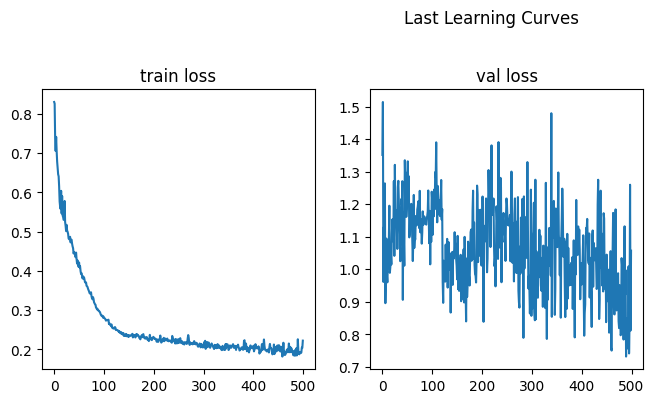

In [86]:
para_len = 72
epi_len = 48
kfold = 10

# how to choose epitope: 0 - random AA sequence as epitope; 1 - k-nearest AA as epitope
seq_clip_mode = 1 #0
# how to generate negative sample: 0 - random sample with dissimilarity rate 90% 1 - random sequence;
neg_sample_mode = 0 #1

data_type = "seq" + str(seq_clip_mode) + "_" + "neg" + str(neg_sample_mode)

batch_size = 16 #128 #16
clip_norm = 1 # gradient clipping

use_L2 = True
# use_L2 = False

use_pair = True
# use_pair = False

# folds_path = None
if use_pair==False:
    folds_path = "./data/processed_data_clip1_neg0.pkl"
elif use_pair==True:
    folds_path = "./data/processed_data_clip1_neg0_usepairTrue.pkl"
else:
    folds_path = None

# model name
# model_name = "demo"
# model_name = "lstm"
# model_name = "mlp"
# model_name = "InteractTransformer"
# model_name = "InteractTransformerLSTM"
# model_name = "SetTransformer"
# model_name = "SetCoAttnTransformer"
# model_name = "SetModel"
# model_name = "SetModel_ablation"
# model_name = "EnsembleModel"
# model_name = "PESI"

model_list = ["masonscnn", 
              "lstm", 
              "InteractTransformer", 
              "SetTransformer"]

for model_name in model_list[1:]:
# for model_name in ["masonscnn"]:
    
    if use_pair==True:
        model_name += "_encoder"

    print("training {} on SAbDab-full".format(model_name))
    
    os.makedirs("./results/SAbDab/full/{}/{}/".format(data_type, model_name), exist_ok=True)


    train_dataset = SAbDabDataset(data=data, epi_seq_length=epi_len, \
                                  seq_clip_mode=seq_clip_mode, neg_sample_mode=neg_sample_mode, \
                                  is_train_test_full="full", is_shuffle=True, \
                                  folds_path=folds_path, save_path=None, K=48, data_augment=False, \
                                  use_pair=use_pair)
    test_dataset = SeqDataset(data_path="../SARS-SAbDab_Shaun/CoV-AbDab_extract.csv", \
                              is_train_test_full="full", use_pair=use_pair)

    func = pair_collate_fn if use_pair else collate_fn
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, \
                                               collate_fn=func)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, \
                                               collate_fn=func)

    if model_name=="masonscnn":
        model = MasonsCNN(amino_ft_dim=len(vocab), 
                          max_antibody_len=100, 
                          max_virus_len=100, 
                          h_dim=512, 
                          dropout=0.1).cuda()
        epochs = 300
        lr = 1e-4
        
    elif model_name=="masonscnn_encoder":
        model = CNNEncoder().cuda()
        
        epochs = 500
        lr = 1e-4
        l2_coef = 3e-5

    elif model_name=="lstm":
        model = BiLSTM(embed_size=32, 
                       hidden=64, 
                       num_layers=1, 
                       dropout=0.5, 
                       use_pretrain=False).cuda()

        epochs = 300
        lr = 1e-4
        
    elif model_name=="lstm_encoder":
        model = BiLSTMEncoder(embed_size=64, hidden=64, num_layers=1).cuda()
        
        epochs = 500
        lr = 1e-4
        l2_coef = 3e-4

    elif model_name=="InteractTransformer":
        model = InteractTransformer(embed_size=32, 
                                    num_encoder_layers=1, 
                                    nhead=2, 
                                    dropout=0.3).cuda()
        epochs = 500
        lr = 6e-5
        
    elif model_name=="InteractTransformer_encoder":
        model = IntTransEncoder(embed_size=32, num_encoder_layers=1, nhead=2, dropout=0.5).cuda()
        
        epochs = 500
        lr = 6e-5
        l2_coef = 5e-4
        
    elif model_name=="InteractCoAttnTransformer":
        model = InteractTransformer(embed_size=32, 
                                    num_encoder_layers=1, 
                                    nhead=2, 
                                    dropout=0.5, 
                                    use_coattn=True).cuda()
        epochs = 500
        lr = 6e-5

    elif model_name=="InteractTransformerLSTM":
        model = InteractTransformerLSTM(embed_size=32, 
                                        hidden=64, 
                                        num_encoder_layers=1, 
                                        num_lstm_layers=1, 
                                        nhead=2, 
                                        dropout=0.5, 
                                        use_coattn=False).cuda()
        epochs = 500
        lr = 6e-5

    elif model_name=="SetTransformer":
        model = SetTransformer(dim_input=32, 
                               num_outputs=32, 
                               dim_output=32, 
                               dim_hidden=128, 
                               num_inds=6, 
                               num_heads=4, 
                               ln=True, 
                               dropout=0.5, 
                               use_coattn=False, 
                               share=False).cuda()
        epochs = 500
        lr = 6e-5
        l2_coef = 5e-4
        
    elif model_name=="SetTransformer_encoder":
        model = SetEncoder(embed_size=32, 
                           num_outputs=32, 
                           dim_output=32, 
                           hidden=128, 
                           num_inds=6, 
                           num_heads=4, 
                           ln=True, 
                           dropout=0.5).cuda()
        epochs = 500
        lr = 6e-5
        l2_coef = 5e-4
        
    elif model_name=="SetCoAttnTransformer":
        model = SetTransformer(dim_input=32, 
                               num_outputs=32, 
                               dim_output=32, 
                               dim_hidden=128, 
                               num_inds=6, 
                               num_heads=4, 
                               ln=True, 
                               dropout=0.5, 
                               use_coattn=True, 
                               share=False).cuda()
        epochs = 500
        lr = 6e-5
        l2_coef = 5e-4

    elif model_name=="SetModel":
        model = SetModel(embed_size=32, 
                         hidden=64, 
                         num_layers=1, 
                         dropout=0.3, 
                         k4kmer=3, 
                         use_pretrain=False, 
                         use_coattn=False, 
                         seq_encoder_type="transformer", 
                         num_heads=2, 
                         num_inds=6, 
                         num_outputs=6, 
                         ln=True).cuda()
        epochs = 500
        lr = 3e-5
        
    elif model_name=="SetCoAttnModel":
        model = SetModel(embed_size=32, 
                         hidden=64, 
                         num_layers=1, 
                         dropout=0.3, 
                         k4kmer=3, 
                         use_pretrain=False, 
                         use_coattn=True, 
                         seq_encoder_type="transformer", 
                         num_heads=2, 
                         num_inds=6, 
                         num_outputs=6, 
                         ln=True).cuda()
        epochs = 500
        lr = 3e-5
        
    elif model_name=="EnsembleModel":
        model = EnsembleModel(embed_size=16, 
                      hidden=64, 
                      max_len=100, 
                      num_encoder_layers=1, 
                      num_heads=2, 
                      num_inds=6, 
                      num_outputs=6, 
                      ln=False, 
                      dropout=0.5, 
                      use_coattn=False).cuda()
        
        epochs = 500
        lr = 6e-5
        
#     elif model_name=="EnsembleModel1":
#         model = EnsembleModel(embed_size=16, 
#                       hidden=64, 
#                       max_len=100, 
#                       num_encoder_layers=1, 
#                       num_heads=2, 
#                       num_inds=6, 
#                       num_outputs=6, 
#                       ln=True, 
#                       dropout=0.5, 
#                       use_coattn=True).cuda()
        
#         epochs = 500
#         lr = 3e-5

    elif model_name=="PESI":
        model = PESI(embed_size=8, 
                     hidden=64, 
                     max_len=100, 
                     num_heads=2, 
                     num_inds=6, 
                     num_outputs=6, 
                     ln=True, 
                     dropout=0.5, 
                     use_coattn=True).cuda()
        
        epochs = 200
        lr = 5e-5
        l2_coef = 5e-4

    else:
        pass


    print("model parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

    criterion = nn.BCELoss() if use_pair==False else None
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-6, last_epoch=-1)

    loss_buf = []
    val_loss_buf = []
    val_acc_buf = []
    val_f1_buf = []
    val_auc_buf = []
    best_train_loss = float("inf")
    best_val_loss = float("inf")

    for epoch in range(epochs):

        print("Epoch {}".format(epoch))

        loss_tmp = []
        if use_pair==False:
            for i, (para, epi, label) in enumerate(tqdm(train_loader)):
                optimizer.zero_grad()

                if use_pair==False:
                    pred = model(para, epi)
                    loss = criterion(pred.view(-1), label.view(-1).cuda())

                if use_L2 == True:
                    param_l2_loss = 0
                    for name, param in model.named_parameters():
                        if 'bias' not in name:
                            param_l2_loss += torch.norm(param, p=2)
                    param_l2_loss = l2_coef * param_l2_loss
                    loss += param_l2_loss

                loss.backward()

                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)

                optimizer.step()

                loss_tmp.append(loss.item())
                
            loss_buf.append(np.mean(loss_tmp))
                
        else:
            for i, (para, epi_pos, epi_neg) in enumerate(tqdm(train_loader)):
                optimizer.zero_grad()

                y_pred_anc = model(para)
                y_pred_pos = model(epi_pos)
                y_pred_neg = model(epi_neg)
                
                if len(y_pred_anc.shape)==3:
                    y_pred_anc = torch.nn.functional.normalize(torch.mean(y_pred_anc, dim=1), p=2, dim=1)
                    y_pred_pos = torch.nn.functional.normalize(torch.mean(y_pred_pos, dim=1), p=2, dim=1)
                    y_pred_neg = torch.nn.functional.normalize(torch.mean(y_pred_neg, dim=1), p=2, dim=1)
                
                elif len(y_pred_anc.shape)==2:
                    y_pred_anc = torch.nn.functional.normalize(y_pred_anc, p=2, dim=1)
                    y_pred_pos = torch.nn.functional.normalize(y_pred_pos, p=2, dim=1)
                    y_pred_neg = torch.nn.functional.normalize(y_pred_neg, p=2, dim=1)
                
                loss = - (torch.dist(y_pred_anc, y_pred_pos, 2) - torch.dist(y_pred_anc, y_pred_neg, 2)).sigmoid().log().sum()

                if use_L2 == True:
                    param_l2_loss = 0
                    for name, param in model.named_parameters():
                        if 'bias' not in name:
                            param_l2_loss += torch.norm(param, p=2)
                    param_l2_loss = l2_coef * param_l2_loss
                    loss += param_l2_loss

                loss.backward()

                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)

                optimizer.step()

                loss_tmp.append(loss.item())

            loss_buf.append(np.mean(loss_tmp))

    #     scheduler.step()
        print("lr: ", optimizer.param_groups[0]['lr'])
#         print("train loss {:.4f}\n".format(np.mean(loss_buf)))


        # evaluate
        if use_pair==False:
        
            with torch.no_grad():

                model.eval()

                preds = []
                labels = []
                val_loss_tmp = []
                for i, (para, epi, label) in enumerate(tqdm(test_loader)):

                    pred = model(para, epi)
                    val_loss = criterion(pred.view(-1), label.view(-1).cuda())

                    preds.append(pred.detach().cpu().view(-1))
                    labels.append(label.view(-1))
                    val_loss_tmp.append(val_loss.item())

                preds = torch.hstack(preds).view(-1)
                labels = torch.hstack(labels).view(-1)

                acc = accuracy_score(y_true=labels, y_pred=torch.round(preds))
                f1 = f1_score(y_true=labels, y_pred=torch.round(preds))
                auc = roc_auc_score(y_true=labels, y_score=preds)

                val_acc_buf.append(acc)
                val_f1_buf.append(f1)
                val_auc_buf.append(auc)
                val_loss_buf.append(np.mean(val_loss_tmp))

                print("Epoch {}: \n Train Loss\t{:.4f} \n Val Loss\t{:.4f} \n Val Acc\t{:.4f} \n Val F1\t\t{:.4f} \n Val AUC\t{:.4f}".format(epoch, np.mean(loss_buf), np.mean(val_loss_buf), acc, f1, auc))

                if np.mean(val_loss_tmp)<best_val_loss:
                    best_val_loss = np.mean(val_loss_tmp)
                    torch.save(model, "./results/SAbDab/full/{}/{}/model_best.pth".format(data_type, model_name))
                    np.save("./results/SAbDab/full/{}/{}/val_acc_best.npy".format(data_type, model_name), acc)
                    np.save("./results/SAbDab/full/{}/{}/val_f1_best.npy".format(data_type, model_name), f1)
                    np.save("./results/SAbDab/full/{}/{}/val_auc_best.npy".format(data_type, model_name), auc)

        else:
#             if np.mean(loss_tmp)<best_train_loss:
#                 best_train_loss = np.mean(loss_tmp)
#                 torch.save(model, "./results/SAbDab/full/{}/{}/model_best.pth".format(data_type, model_name))
            with torch.no_grad():

                model.eval()

                preds = []
                labels = []
                val_loss_tmp = []
                for i, (para1, epi_pos1, epi_neg1) in enumerate(tqdm(test_loader)):

                    y_pred_anc1 = model(para1)
                    y_pred_pos1 = model(epi_pos1)
                    y_pred_neg1 = model(epi_neg1)
                    
                    if len(y_pred_anc1.shape)==3:
                        y_pred_anc1 = torch.nn.functional.normalize(torch.mean(y_pred_anc1, dim=1), p=2, dim=1)
                        y_pred_pos1 = torch.nn.functional.normalize(torch.mean(y_pred_pos1, dim=1), p=2, dim=1)
                        y_pred_neg1 = torch.nn.functional.normalize(torch.mean(y_pred_neg1, dim=1), p=2, dim=1)

                    elif len(y_pred_anc1.shape)==2:
                        y_pred_anc1 = torch.nn.functional.normalize(y_pred_anc1, p=2, dim=1)
                        y_pred_pos1 = torch.nn.functional.normalize(y_pred_pos1, p=2, dim=1)
                        y_pred_neg1 = torch.nn.functional.normalize(y_pred_neg1, p=2, dim=1)

                    val_loss = - (torch.dist(y_pred_anc1, y_pred_pos1, 2) - torch.dist(y_pred_anc1, y_pred_neg1, 2)).sigmoid().log().sum()

                    if use_L2 == True:
                        param_l2_loss1 = 0
                        for name, param in model.named_parameters():
                            if 'bias' not in name:
                                param_l2_loss1 += torch.norm(param, p=2)
                        param_l2_loss1 = l2_coef * param_l2_loss1
                        val_loss += param_l2_loss1

                    val_loss_tmp.append(val_loss.item())

                val_loss_buf.append(np.mean(val_loss_tmp))
                print("Epoch {}: \n Train Loss\t{:.4f} \n Val Loss\t{:.4f}\n".format(epoch, np.mean(loss_buf), np.mean(val_loss_buf)))

                if np.mean(val_loss_tmp)<best_val_loss:
                    best_val_loss = np.mean(val_loss_tmp)
                    torch.save(model, "./results/SAbDab/full/{}/{}/model_best.pth".format(data_type, model_name))
                    


        torch.cuda.empty_cache()

        model.train()



    torch.save(model, "./results/SAbDab/full/{}/{}/model.pth".format(data_type, model_name))
    np.save("./results/SAbDab/full/{}/{}/loss_buf.npy".format(data_type, model_name), np.array(loss_buf))
    np.save("./results/SAbDab/full/{}/{}/val_loss_buf.npy".format(data_type, model_name), np.array(val_loss_buf))
    if use_pair==False:
        
        np.save("./results/SAbDab/full/{}/{}/val_acc_buf.npy".format(data_type, model_name), np.array(val_acc_buf))
        np.save("./results/SAbDab/full/{}/{}/val_f1_buf.npy".format(data_type, model_name), np.array(val_f1_buf))
        np.save("./results/SAbDab/full/{}/{}/val_auc_buf.npy".format(data_type, model_name), np.array(val_auc_buf))


    #     break
    
    evaluate(model_name, use_pair=True)

==================masonscnn_encoder================


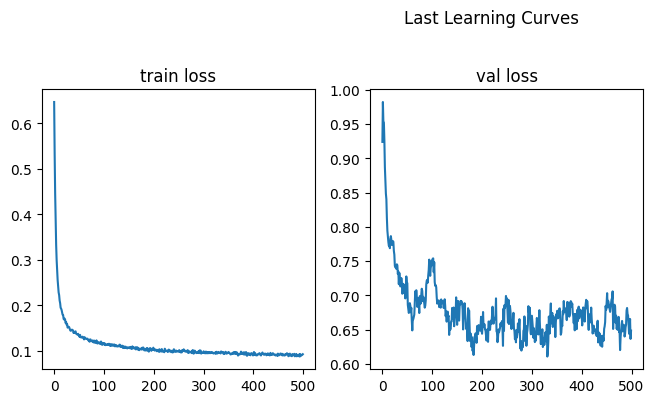

In [85]:
evaluate("masonscnn_encoder", use_pair=True)

==================lstm_encoder================


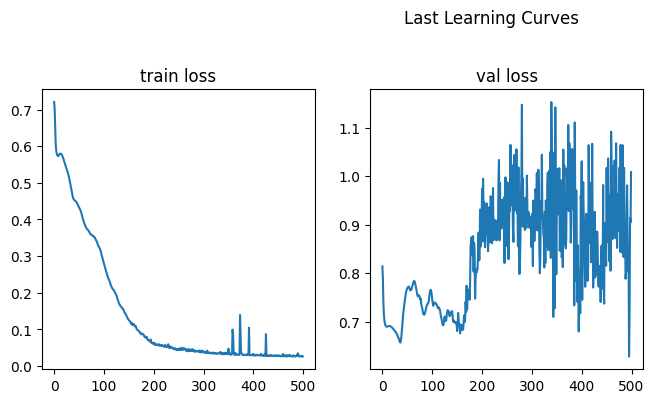

In [87]:
evaluate("lstm_encoder", use_pair=True)

==================InteractTransformer_encoder================


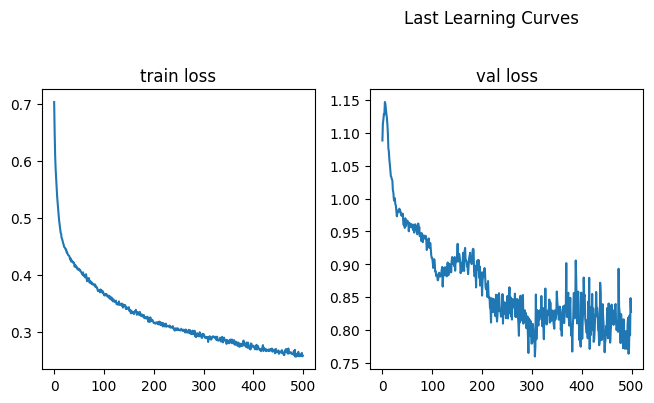

In [90]:
evaluate("InteractTransformer_encoder", use_pair=True)

==================SetTransformer_encoder================


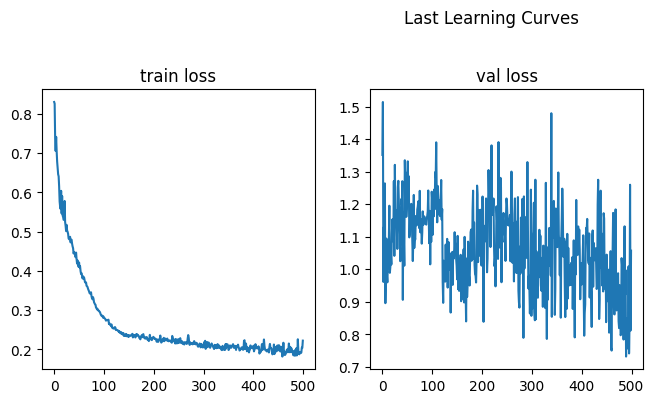

In [91]:
evaluate("SetTransformer_encoder", use_pair=True)